<a href="https://colab.research.google.com/github/Imran012x/Transfer-Models/blob/main/Hilsha_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✅ Step 1: Colab-Setup


In [1]:
import os
from google.colab import drive

drive_path = '/content/drive'

if os.path.exists(drive_path) and os.path.ismount(drive_path):
    print("Google Drive is already connected ✅")
else:
    drive.mount(drive_path)
    print("Google Drive connection done ✅")


# # Upload a file
# uploaded = files.upload()
# # Get the file name
# file_name = list(uploaded.keys())[0]
# print(f"Uploaded file: {file_name}")


# import zipfile
# import os
# # with zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_224_11k.zip', 'r') as zip_ref:
# #     zip_ref.extractall('')
# with zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_org_8407.zip', 'r') as zip_ref:
#     zip_ref.extractall('')

Google Drive is already connected ✅


# ✅ Step 2: Import & Config & Env Setup

In [2]:
#1. IMPORTS AND INITIAL SETUP
# ================================================================================================================================
# Purpose: Import all required libraries and set up warnings to suppress unnecessary messages.



!pip install pytorch-gradcam optuna captum -q  # Uncomment if running in a new environment


import sys
import numpy
import pandas
import seaborn as sns

print(f"python_version: {sys.version.split()[0]}")
print(f"numpy_version: {numpy.__version__}")
print(f"pandas_version: {pandas.__version__}")
print(f"seaborn_version: {sns.__version__}\n")




# ============================================================
# Standard Library
# ============================================================
import os
import sys
import gc
import time
import json
import zipfile
import logging
import random
import warnings
import traceback
import logging
import subprocess
import threading
import traceback
from pathlib import Path
from threading import Lock
import multiprocessing as mp
from itertools import combinations
from datetime import datetime, timedelta
from collections import Counter, defaultdict
from typing import Tuple, Dict, Any, Optional
from concurrent.futures import ThreadPoolExecutor, as_completed

# ============================================================
# Data Handling & Utilities
# ============================================================
import numpy as np
import pandas as pd
from tqdm import tqdm

# ============================================================
# Visualization
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# ============================================================
# System & Resource Monitoring
# ============================================================
import psutil
import pynvml

# ============================================================
# Machine Learning
# ============================================================
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, accuracy_score,
    precision_score, recall_score, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# ============================================================
# Deep Learning - PyTorch
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, SubsetRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms

# ============================================================
# Augmentation
# ============================================================
import albumentations as A
from albumentations.pytorch import ToTensorV2


# ============================================================
# Explainable AI (XAI)
# ============================================================

import torch.autograd as autograd
from captum.attr import LRP

# Optuna
import optuna
import optuna.logging



# ============================================================
# Hyperparameter Optimization
# ============================================================
try:
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Warning: Optuna not available. Using default hyperparameters.")



#For DeprecationWarning / FutureWarning specifically:
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)

# Hide all pip warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


# ---
# 2. CONFIGURATION
# ================================================================================================================================
# Purpose: Define configuration settings and initialize the environment.

class Config:


    OUTPUT_DIR = '/content/drive/MyDrive/Hilsha'

    # Dataset parameters
    NUM_CLASSES = 5
    CLASS_NAMES = ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']
    INPUT_SIZE = 224

    # Training parameters
    BATCH_SIZE = 32 #Will Change Dynamically
    DATALOADER_NUM_WORKERS = 1 #Will Change Dynamically
    # Dynamically adjust batch size and workers
    EPOCHS = 40
    PIN_MEMORY = True
    USE_MIXED_PRECISION = True #True
    COMPILE_MODEL = True
    PATIENCE = 4
    LEARNING_RATE = 1e-5
    WEIGHT_DECAY = 1e-4

    # Hyperparameter tuning
    OPTUNA_TRIALS = 100
    OPTUNA_EPOCHS = 10

    # Models to train
    # MODELS = ['resnet50','efficientnet_b0','mobilenet_v3_large','vgg16', 'densenet121']
    MODELS = [
        # 'resnet50',
        'efficientnet_b0'
        # 'mobilenet_v3_large',
        # 'vgg16',
        # 'densenet121',
        # 'inception_v3'
        # 'vit_b_16',
        # 'convnext_base',
        # 'regnet_y_32gf'
    ]


    # Ensemble methods
    ENSEMBLE_METHODS = ['simple_average', 'weighted_average', 'confidence_based', 'learnable_weighted']

    # Device
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    SEED = 42




def setup_environment():
    """Setup random seeds, directories, and dynamically adjust batch size and workers"""

    os.environ['PYTHONHASHSEED'] = str(Config.SEED)  # For hash seed reproducibility
    random.seed(Config.SEED)
    np.random.seed(Config.SEED)
    torch.manual_seed(Config.SEED)
    torch.cuda.manual_seed_all(Config.SEED)  # For multi-GPU if applicable
    #Guard for GPU determinism (optional, but helpful if you want exact reproducibility across runs):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    warnings.filterwarnings("ignore")


    torch.manual_seed(Config.SEED)
    np.random.seed(Config.SEED)

    directories = [
        Config.OUTPUT_DIR,
        f"{Config.OUTPUT_DIR}/models",
        f"{Config.OUTPUT_DIR}/visualizations",
        f"{Config.OUTPUT_DIR}/reports",
        f"{Config.OUTPUT_DIR}/xai_visualizations"
    ]

    for directory in directories:
        Path(directory).mkdir(parents=True, exist_ok=True)#With exist_ok=True:Python will not raise an error if already exists.Or else raise a FileExistsError
        #& parents=True → creates all missing parent directories in the path.

    # Ensure all output directories exist
    os.makedirs(f"{Config.OUTPUT_DIR}/best_model", exist_ok=True)
    os.makedirs(f"{Config.OUTPUT_DIR}/model_results", exist_ok=True)
    os.makedirs(f"{Config.OUTPUT_DIR}/kfold_results", exist_ok=True)
    os.makedirs(f"{Config.OUTPUT_DIR}/visualizations", exist_ok=True)

    print(f"Using device: {Config.DEVICE}")
    print(f"PyTorch version: {torch.__version__}")
    print(f"Dynamic BATCH_SIZE: {Config.BATCH_SIZE}, DATALOADER_NUM_WORKERS: {Config.DATALOADER_NUM_WORKERS}")
    print("-" * 70)


def worker_init_fn(worker_id):
    seed = Config.SEED + worker_id
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


python_version: 3.12.11
numpy_version: 1.26.4
pandas_version: 2.2.2
seaborn_version: 0.13.2



# ✅ Step 3: Pre-processing & Save

In [3]:

# # Check GPU availability
# print("GPU Available:", torch.cuda.is_available())
# print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


# # Define fish classes and dataset paths
# fish_classes = ['ilish', 'chandana', 'sardin', 'sardinella', 'punctatus'] #0,1,2,3,4
# zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_org_8407.zip').extractall('/content/.hidden_fish')
# data_dir = '/content/.hidden_fish'

# image_limits = {
#     'ilish': 3000,
#     'chandana': 1185,
#     'sardin': 2899,
#     'sardinella': 370,
#     'punctatus': 953
# }

# # Settings
# total_images = sum(image_limits.values())
# batch_size = 100
# num_threads = 4


# # Output paths
# output_dir = '/content/drive/MyDrive/Hilsha'
# os.makedirs(output_dir, exist_ok=True)
# labels_file = os.path.join(output_dir, 'Y_labels.npy')
# xdata_file = os.path.join(output_dir, 'X_data.npy')

# save_lock = threading.Lock()  # for thread-safe writes -> Prevents race conditions when multiple threads write to the same list.

# # Function to gather image paths
# def get_image_paths(class_name, max_images):
#     path = os.path.join(data_dir, class_name)
#     files = sorted(os.listdir(path))
#     random.shuffle(files)
#     return [os.path.join(path, f) for f in files[:max_images]]

# # Load and preprocess batch
# def load_and_preprocess_batch(image_paths, start_idx, batch_size, class_idx):
#     end_idx = min(start_idx + batch_size, len(image_paths))
#     batch_paths = image_paths[start_idx:end_idx]
#     batch_images = []

#     for img_path in batch_paths:
#         img = Image.open(img_path).resize((224, 224)).convert('RGB')
#         img_tensor = torch.tensor(np.array(img), dtype=torch.uint8).permute(2, 0, 1)  # C x H x W
#         batch_images.append(img_tensor)

#     batch_tensor = torch.stack(batch_images)  # B x C x H x W
#     batch_labels = np.full((len(batch_images),), class_idx, dtype=np.int32)
#     return batch_tensor, batch_labels

# # Process one batch and return tensors & labels (no file saving)
# def process_batch(image_paths, start_idx, batch_size, class_idx):
#     return load_and_preprocess_batch(image_paths, start_idx, batch_size, class_idx)

# def preprocess_and_save_all(overwrite=True):
#     if os.path.exists(labels_file) and os.path.exists(xdata_file) and not overwrite:
#         print("Preprocessed data already exists. Set overwrite=True to reprocess.")
#         return

#     all_images = []
#     all_labels = []
#     processed_count = 0

#     for idx, class_name in enumerate(fish_classes):
#         print(f"\nProcessing class: {class_name}")
#         image_paths = get_image_paths(class_name, image_limits[class_name])
#         total_batches = (len(image_paths) + batch_size - 1) // batch_size
#         #It ensures ceiling division — rounding up, not down.
#         # Normal division: 103 / 20 = 5.15 → floor division // 20 = 5 (❌ missing last 3 images)
#         # This trick: (103 + 20 - 1) // 20 = 122 // 20 = 6 ✅

#         with ThreadPoolExecutor(max_workers=num_threads) as executor:
#             futures = []
#             for start in range(0, len(image_paths), batch_size):
#                 futures.append(executor.submit(process_batch, image_paths, start, batch_size, idx))

#             for future in tqdm(as_completed(futures), total=total_batches, desc=class_name):#taqaddum (تقدّم) – Arabic for "progress".
#                 # futures: List of tasks (from ThreadPoolExecutor or ProcessPoolExecutor).
#                 # as_completed(futures): Yields each future as it finishes (not in order).

#                 batch_tensor, batch_labels = future.result()
#                 with save_lock: #Locks this section so that only one thread can update the shared lists safely.
#                     all_images.append(batch_tensor)
#                     all_labels.append(batch_labels)
#                     processed_count += batch_tensor.size(0)
#                     print(f"Processed batch with {batch_tensor.size(0)} images, total processed: {processed_count}/{total_images}")
#                 gc.collect()

#     # Combine all tensors and labels
#     X = torch.cat(all_images, dim=0).numpy()
#     Y = np.concatenate(all_labels, axis=0)

#     # Save final arrays
#     np.save(xdata_file, X, allow_pickle=False)#Malicious .npy -> import os;os.system("rm -rf /")  # ← Dangerous command
#     np.save(labels_file, Y, allow_pickle=False)

#     print(f"\n✅ Done! Saved {processed_count} images in {xdata_file}")
#     print(f"X_data shape: {X.shape}, Y_labels shape: {Y.shape}")

#     if processed_count != total_images:
#         raise ValueError(f"Expected {total_images} images, but processed {processed_count}")

# # Run preprocessing and save directly to X_data.npy and Y_labels.npy
# preprocess_and_save_all(overwrite=True)










class FishDataset(Dataset):
    def __init__(self, images, labels, transform=None):

        self.images = self._preprocess_images(images)
        self.labels = labels.astype(np.int64)
        self.transform = transform #Here means: Medium,Heavy or Any

    def _preprocess_images(self, images):
        """Preprocess images to ensure proper format and normalization"""
        if images.max() > 1.5: #👉 The threshold 1.5 is just a safe cutoff to distinguish between the two cases.
            #Because some normalized images can have values slightly above 1.0 (e.g., after augmentations, rounding, or scaling bugs).
            images = images.astype(np.float32) / 255.0

        if len(images.shape) == 4 and images.shape[1] == 3: #If input is (batch, channels, height, width) → convert to (batch, height, width, channels) (common for TensorFlow).
            images = np.transpose(images, (0, 2, 3, 1))
        return images.astype(np.float32)

    def __len__(self):
        """Return the total number of samples in the dataset"""
        return len(self.images)




    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:  #Applies an Albumentations transform pipeline (it returns a dict, so you take ['image']).
            image = self.transform(image=image)['image'] #
        else:
            image = torch.from_numpy(image).permute(2, 0, 1)
        #With transform → advanced augmentations.
        #Without transform → just convert to PyTorch format.


        # Convert label to plain Python int to avoid CUDA tensor creation in workers.That wastes memory and slows down training.
        if isinstance(label, np.ndarray):
            label = int(label.item())
        elif hasattr(label, 'item'):
            label = int(label.item())
        else:
            label = int(label)


        return image, label  # Plain Python int, not torch.tensor
        # return image, torch.tensor(int(label), dtype=torch.long)




    # def __getitem__(self, idx):
    #     image = self.images[idx]  # H x W x C
    #     label = self.labels[idx]

    #     # Ensure image has 3 channels
    #     if image.ndim == 2:  # grayscale H x W
    #         image = np.stack([image]*3, axis=-1)
    #     elif image.shape[-1] == 4:  # RGBA
    #         image = image[:, :, :3]

    #     # Apply Albumentations transform if any
    #     if self.transform:
    #         image = self.transform(image=image)['image']  # may already be tensor

    #     # Convert to PyTorch tensor C x H x W if it's a numpy array
    #     if isinstance(image, np.ndarray):
    #         image = torch.from_numpy(image).permute(2, 0, 1).float()
    #     elif isinstance(image, torch.Tensor) and image.ndim == 3 and image.shape[0] != 3:
    #         # If transform returns H x W x C tensor, permute to C x H x W
    #         image = image.permute(2, 0, 1).float()
    #     # else assume it's already C x H x W

    #     # Convert label to tensor
    #     label = int(label) if not isinstance(label, torch.Tensor) else label.long()

    #     return image, torch.tensor(label, dtype=torch.long)




        # class MyClass:
        #     def greet(self):
        #         print("Hello!")
        # obj = MyClass()
        # print(hasattr(obj, 'greet'))   # True, because obj has a method greet
        # print(hasattr(obj, 'name'))    # False, no attribute called name
        # # Using hasattr with .item()
        # import torch
        # x = torch.tensor(5)  # scalar tensor
        # print(hasattr(x, 'item'))      # True
        # print(x.item())                # 5

        # return image, torch.tensor(label, dtype=torch.long)  # <-- ensure label is tensor



from albumentations import (
    Compose, Resize, HorizontalFlip, VerticalFlip, RandomRotate90,
    ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur,
    GaussNoise, CoarseDropout, ElasticTransform, GridDistortion,
    RandomFog, RandomRain, ColorJitter, Normalize
)
from albumentations.pytorch import ToTensorV2

class DataManager:
    @staticmethod  #In Python, @staticmethod is used to define a method that belongs to a class but doesn’t access self or cls.

    # class DataManager:
    # staticmethod
    # def greet(name):
    #     return f"Hello, {name}!"
    # # Call without creating an instance
    # print(DataManager.greet("Imran"))  # Output: Hello, Imran!
    # # Call with an instance
    # dm = DataManager()
    # print(dm.greet("Imran"))           # Output: Hello, Imran!

    # class MyClass:
    #     count = 0

    #     staticmethod
    #     def greet(name):
    #         return f"Hello, {name}!"

    #     classmethod
    #     def increment_count(cls):
    #         cls.count += 1
    #         return cls.count

    # # Static method
    # print(MyClass.greet("Imran"))      # Hello, Imran!
    # # Class method
    # print(MyClass.increment_count())   # 1
    # print(MyClass.increment_count())   # 2
    #Static method → independent of class/instance.
    #Class method → works with the class itself (cls), can modify class variables.



    def get_transforms(is_training=True, augmentation_strength='medium'):
        """Get data transforms with configurable augmentation strength"""

        # Determine correct resize for InceptionV3
        resize_size = 299 if Config.MODELS == 'inception_v3' else Config.INPUT_SIZE

        if is_training:
            if augmentation_strength == 'light':
                return Compose([
                    Resize(resize_size, resize_size),
                    HorizontalFlip(p=0.3),
                    # Original line: RandomRotate90(p=0.3),
                    RandomRotate90(p=0.2),  # RandomRotate90 — reduce probability
                    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])
            elif augmentation_strength == 'heavy':
                return Compose([
                    Resize(resize_size, resize_size),
                    HorizontalFlip(p=0.7),
                    VerticalFlip(p=0.5),
                    # Original line: RandomRotate90(p=0.7),
                    RandomRotate90(p=0.3),  # RandomRotate90 — reduce probability
                    # Original line: ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
                    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.3),  # safer
                    RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
                    GaussianBlur(blur_limit=(3, 9), p=0.5),
                    GaussNoise(var_limit=(10.0, 80.0), p=0.4),
                    # Original line: CoarseDropout(max_holes=12, max_height=25, max_width=25, p=0.5),
                    CoarseDropout(max_holes=6, max_height=15, max_width=15, p=0.3),  # smaller holes
                    # Original line: ElasticTransform(p=0.3),
                    ElasticTransform(p=0.1),  # reduce probability
                    # Original line: GridDistortion(p=0.3),
                    GridDistortion(p=0.1),  # reduce probability
                    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=0.3),
                    RandomRain(blur_value=3, p=0.2),
                    ColorJitter(hue=0.1, p=0.5),
                    ToTensorV2()
                ])
            else:  # medium
                return Compose([
                    Resize(resize_size, resize_size),
                    HorizontalFlip(p=0.5),
                    VerticalFlip(p=0.3),
                    # Original line: RandomRotate90(p=0.5),
                    RandomRotate90(p=0.3),  # RandomRotate90 — reduce probability
                    # Original line: ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.1),
                    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.1),  # safe
                    RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
                    GaussianBlur(blur_limit=(3, 7), p=0.4),
                    GaussNoise(var_limit=(10.0, 50.0), p=0.3),
                    # Original line: CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.4),
                    CoarseDropout(max_holes=6, max_height=15, max_width=15, p=0.3),  # smaller holes
                    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])
        else:
            return Compose([
                Resize(resize_size, resize_size),  # validation/test resize
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])




    @staticmethod
    def load_and_balance_data():
        """Load data and apply SMOTE"""
        print("Loading and preprocessing data...")

        # # Check GPU availability
        # print("GPU Available:", torch.cuda.is_available())
        # print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


        # # Define fish classes and dataset paths
        # fish_classes = ['ilish', 'chandana', 'sardin', 'sardinella', 'punctatus'] #0,1,2,3,4
        # zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_org_8407.zip').extractall('/content/.hidden_fish')
        # data_dir = '/content/.hidden_fish'

        # image_limits = {
        #     'ilish': 3000,
        #     'chandana': 1185,
        #     'sardin': 2899,
        #     'sardinella': 370,
        #     'punctatus': 953
        # }

        # # Settings
        # total_images = sum(image_limits.values())
        # batch_size = 100
        # num_threads = 4


        # # Output paths
        # output_dir = '/content/drive/MyDrive/Hilsha'
        # os.makedirs(output_dir, exist_ok=True)
        # labels_file = os.path.join(output_dir, 'Y_labels.npy')
        # xdata_file = os.path.join(output_dir, 'X_data.npy')

        # save_lock = threading.Lock()  # for thread-safe writes -> Prevents race conditions when multiple threads write to the same list.

        # # Function to gather image paths
        # def get_image_paths(class_name, max_images):
        #     path = os.path.join(data_dir, class_name)
        #     files = sorted(os.listdir(path))
        #     random.shuffle(files)
        #     return [os.path.join(path, f) for f in files[:max_images]]

        # # Load and preprocess batch
        # def load_and_preprocess_batch(image_paths, start_idx, batch_size, class_idx):
        #     end_idx = min(start_idx + batch_size, len(image_paths))
        #     batch_paths = image_paths[start_idx:end_idx]
        #     batch_images = []

        #     for img_path in batch_paths:
        #         img = Image.open(img_path).resize((224, 224)).convert('RGB')
        #         img_tensor = torch.tensor(np.array(img), dtype=torch.uint8).permute(2, 0, 1)  # C x H x W
        #         batch_images.append(img_tensor)

        #     batch_tensor = torch.stack(batch_images)  # B x C x H x W
        #     batch_labels = np.full((len(batch_images),), class_idx, dtype=np.int32)
        #     return batch_tensor, batch_labels

        # # Process one batch and return tensors & labels (no file saving)
        # def process_batch(image_paths, start_idx, batch_size, class_idx):
        #     return load_and_preprocess_batch(image_paths, start_idx, batch_size, class_idx)

        # def preprocess_and_save_all(overwrite=True):
        #     if os.path.exists(labels_file) and os.path.exists(xdata_file) and not overwrite:
        #         print("Preprocessed data already exists. Set overwrite=True to reprocess.")
        #         return

        #     all_images = []
        #     all_labels = []
        #     processed_count = 0

        #     for idx, class_name in enumerate(fish_classes):
        #         print(f"\nProcessing class: {class_name}")
        #         image_paths = get_image_paths(class_name, image_limits[class_name])
        #         total_batches = (len(image_paths) + batch_size - 1) // batch_size
        #         #It ensures ceiling division — rounding up, not down.
        #         # Normal division: 103 / 20 = 5.15 → floor division // 20 = 5 (❌ missing last 3 images)
        #         # This trick: (103 + 20 - 1) // 20 = 122 // 20 = 6 ✅

        #         with ThreadPoolExecutor(max_workers=num_threads) as executor:
        #             futures = []
        #             for start in range(0, len(image_paths), batch_size):
        #                 futures.append(executor.submit(process_batch, image_paths, start, batch_size, idx))

        #             for future in tqdm(as_completed(futures), total=total_batches, desc=class_name):#taqaddum (تقدّم) – Arabic for "progress".
        #                 # futures: List of tasks (from ThreadPoolExecutor or ProcessPoolExecutor).
        #                 # as_completed(futures): Yields each future as it finishes (not in order).

        #                 batch_tensor, batch_labels = future.result()
        #                 with save_lock: #Locks this section so that only one thread can update the shared lists safely.
        #                     all_images.append(batch_tensor)
        #                     all_labels.append(batch_labels)
        #                     processed_count += batch_tensor.size(0)
        #                     print(f"Processed batch with {batch_tensor.size(0)} images, total processed: {processed_count}/{total_images}")
        #                 gc.collect()

        #     # Combine all tensors and labels
        #     X = torch.cat(all_images, dim=0).numpy()
        #     Y = np.concatenate(all_labels, axis=0)

        #     # Save final arrays
        #     np.save(xdata_file, X, allow_pickle=False)#Malicious .npy -> import os;os.system("rm -rf /")  # ← Dangerous command
        #     np.save(labels_file, Y, allow_pickle=False)

        #     print(f"\n✅ Done! Saved {processed_count} images in {xdata_file}")
        #     print(f"X_data shape: {X.shape}, Y_labels shape: {Y.shape}")

        #     if processed_count != total_images:
        #         raise ValueError(f"Expected {total_images} images, but processed {processed_count}")

        # # Run preprocessing and save directly to X_data.npy and Y_labels.npy
        # preprocess_and_save_all(overwrite=True)







        # X = np.load(Config.DATA_FILE)
        # Y = np.load(Config.LABELS_FILE)







        # # Your data path
        # output_dir = '/content/drive/MyDrive/Hilsha'
        # data_file = os.path.join(output_dir, 'X_data.npy')
        # labels_file = os.path.join(output_dir, 'Y_labels.npy')

        # # Readable size format
        # def sizeof_fmt(num, suffix='B'):
        #     for unit in ['', 'K', 'M', 'G', 'T']:
        #         if abs(num) < 1024.0:
        #             return f"{num:3.2f} {unit}{suffix}"
        #         num /= 1024.0
        #     return f"{num:.2f} T{suffix}"

        # # Main loader
        # def load_preprocessed_data(as_torch=True, normalize=True, to_device=None):
        #     # Check file existence #cpu,cuda (CUDA stands for Compute Unified Device Architecture.)
        #     for path in [data_file, labels_file]:
        #         if not os.path.exists(path):
        #             raise FileNotFoundError(f"Missing: {path}")

        #     # Print file sizes
        #     print(f"📁 X_data.npy: {sizeof_fmt(os.path.getsize(data_file))}")
        #     print(f"📁 Y_labels.npy: {sizeof_fmt(os.path.getsize(labels_file))}")

        #     # Load with mmap
        #     X = np.load(data_file, mmap_mode='r')
        #     Y = np.load(labels_file, mmap_mode='r')

        #     print(f"✅ X shape: {X.shape}, dtype: {X.dtype}")
        #     print(f"✅ Y shape: {Y.shape}, dtype: {Y.dtype}")

        #     # Sanity check
        #     if len(X) != len(Y):
        #         raise ValueError("Mismatch between number of samples in X and Y")

        #     # Convert to torch
        #     if as_torch:
        #         X = torch.from_numpy(X)
        #         Y = torch.from_numpy(Y)

        #         if normalize and X.dtype == torch.uint8:
        #             X = X.float() / 255.0

        #         if to_device:
        #             X = X.to(to_device)
        #             Y = Y.to(to_device)

        #         print(f"🧠 Torch tensors ready on {to_device or 'CPU'}")

        #     return X, Y

        # # 🔁 Example call
        # X, Y = load_preprocessed_data(
        #     as_torch=True,
        #     normalize=True,
        #     to_device='cuda' if torch.cuda.is_available() else 'cpu'
        # )

        # print(f"\nOriginal data shape: {X.shape}")
        # # print(f"Original class distribution: {np.bincount(Y)}")
        # class_dist = np.bincount(Y.cpu().numpy()) if torch.is_tensor(Y) else np.bincount(Y)
        # print(f"Original class distribution: {class_dist}")






        # print("Applying SMOTE for class balancing...")
        # X_flat = X.reshape(X.shape[0], -1)
        # smote = SMOTE(random_state=Config.SEED, k_neighbors=min(5, np.bincount(Y).min()-1))
        # X_balanced_flat, Y_balanced = smote.fit_resample(X_flat, Y)
        # X_balanced = X_balanced_flat.reshape(-1, *X.shape[1:])
        # print(f"Balanced data shape: {X_balanced.shape}")
        # print(f"Balanced class distribution: {np.bincount(Y_balanced)}")
        # return X_balanced, Y_balanced



        # Remove SMOTE completely and use WeightedRandomSampler only
        # Using WeightedRandomSampler instead of SMOTE
        # Compute weights and create sampler during DataLoader, not here
        # return X, Y
        # # Example data
        # X = torch.randn(100, 3, 32, 32)  # 100 images
        # Y = torch.randint(0, 5, (100,))  # 5 classes, imbalanced
        # # Compute class weights
        # class_counts = torch.bincount(Y)
        # class_weights = 1.0 / class_counts.float()
        # sample_weights = class_weights[Y]  # assign weight to each sample
        # # Create sampler
        # sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        # # Create DataLoader
        # dataset = TensorDataset(X, Y)
        # loader = DataLoader(dataset, batch_size=16, sampler=sampler)



        print("Applying SMOTE for class balancing...")
        # Apply SMOTE with reduced k_neighbors and combine with WeightedRandomSampler
        X_flat = X.reshape(X.shape[0], -1)
        smote = SMOTE(random_state=Config.SEED, k_neighbors=3, sampling_strategy='not majority')
        # smote = SMOTE(random_state=Config.SEED, k_neighbors=2, sampling_strategy= 'auto')
        X_balanced_flat, Y_balanced = smote.fit_resample(X_flat, Y)
        X_balanced = X_balanced_flat.reshape(-1, *X.shape[1:])
        # Ensures WeightedRandomSampler is still used in DataLoader
        print(f"Balanced data shape: {X_balanced.shape}")
        print(f"Balanced class distribution: {np.bincount(Y_balanced)}")
        return X_balanced, Y_balanced
        # Benefit: Using a smaller k_neighbors=3 reduces the risk of generating unnatural
        # image artifacts, while sampling_strategy='not majority' balances classes more conservatively.
        # Retaining WeightedRandomSampler in the DataLoader further ensures balanced sampling during
        # training, maintaining smoothness and preventing accuracy drops by avoiding over-reliance
        # on SMOTE-generated samples.



        # print("Applying SMOTE for class balancing...")

        # X_flat = X.cpu().numpy().reshape(X.shape[0], -1) if torch.is_tensor(X) else X.reshape(X.shape[0], -1)
        # Y_np = Y.cpu().numpy() if torch.is_tensor(Y) else Y

        # smote = SMOTE(random_state=Config.SEED, k_neighbors=3, sampling_strategy='not majority')
        # X_balanced_flat, Y_balanced = smote.fit_resample(X_flat, Y_np)
        # X_balanced = X_balanced_flat.reshape(-1, *X.shape[1:])

        # print(f"Balanced data shape: {X_balanced.shape}")
        # print(f"Balanced class distribution: {np.bincount(Y_balanced)}")
        # return X_balanced, Y_balanced






    @staticmethod
    def create_data_loaders(X, Y, test_size=0.2, batch_size=None, augmentation_strength='medium',persistent_workers=True):


        X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=test_size, random_state=Config.SEED, stratify=Y)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=Config.SEED, stratify=y_temp)

        print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
        print(f"Using optimized batch size: {batch_size}")



        train_dataset = FishDataset(X_train, y_train,DataManager.get_transforms(True, augmentation_strength))
        val_dataset = FishDataset(X_val, y_val, DataManager.get_transforms(False))
        test_dataset = FishDataset(X_test, y_test, DataManager.get_transforms(False))


        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        #compute_class_weight('balanced', ...) gives higher weight to minority classes.
        sample_weights = [class_weights[y] for y in y_train]
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
        # Samples with higher weights are more likely to be picked in each batch.
        # replacement=True allows oversampling of minority classes. ✅


        # Conditionally set prefetch_factor based on num_workers
        prefetch_factor = 2 if Config.DATALOADER_NUM_WORKERS > 0 else None
        # pin_memory=Config.PIN_MEMORY if 'cuda' in Config.DEVICE else False
        pin_memory = Config.PIN_MEMORY if 'cuda' in str(Config.DEVICE) else False #Or,pin_memory = Config.PIN_MEMORY if Config.DEVICE.type == 'cuda' else False
        num_workers = Config.DATALOADER_NUM_WORKERS if torch.cuda.is_available() else 0
        use_prefetch = num_workers > 0


        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            # sampler=sampler, #Imbalanced dataset → use sampler.Balanced dataset → use shuffle=True.
            shuffle=True,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available(),
            prefetch_factor=2 if use_prefetch else None,  # Only use prefetch_factor when num_workers > 0
            # persistent_workers=Config.DATALOADER_NUM_WORKERS > 0,
            # persistent_workers=False,
            worker_init_fn=worker_init_fn  # Add this
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available(),
            prefetch_factor=2 if use_prefetch else None,  # Only use prefetch_factor when num_workers > 0
            # persistent_workers=Config.DATALOADER_NUM_WORKERS > 0,
            # persistent_workers=False,
            worker_init_fn=worker_init_fn  # Add this
        )
        fake_test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available(),
            prefetch_factor=2 if use_prefetch else None,  # Only use prefetch_factor when num_workers > 0
            # persistent_workers=Config.DATALOADER_NUM_WORKERS > 0,
            # persistent_workers=False, #False is slow but exact reproductivity ensures & workers reset each epoch).
            worker_init_fn=worker_init_fn  # Add this
        )

        return train_loader, val_loader, fake_test_loader, (X_val, y_val), (X_test, y_test)



# ✅ Step 4: Loading

In [4]:
DATA_FILE = '/content/drive/MyDrive/Hilsha/X_data.npy'
LABEL_FILE = '/content/drive/MyDrive/Hilsha/Y_labels.npy'


X = np.load(DATA_FILE)
Y = np.load(LABEL_FILE)

# ✅ Step 5:Data Visualization [From Processed Image]


In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# from collections import Counter
# import os
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import warnings
# warnings.filterwarnings('ignore')


# # Scientific plotting setup
# plt.style.use('seaborn-v0_8')
# sns.set_palette("husl")
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['font.size'] = 12
# plt.rcParams['axes.titlesize'] = 14
# plt.rcParams['axes.labelsize'] = 12
# plt.rcParams['xtick.labelsize'] = 10
# plt.rcParams['ytick.labelsize'] = 10
# plt.rcParams['legend.fontsize'] = 10
# plt.rcParams['figure.titlesize'] = 16

# class FishDatasetNumpyAnalyzer:
#     """Comprehensive analysis suite for fish species dataset from NumPy arrays"""

#     def __init__(self, X_data, Y_labels, output_dir='./fish_classification_results'):
#         self.X_data = X_data
#         self.Y_labels = Y_labels
#         self.output_dir = output_dir
#         self.create_output_dirs()

#         # Dataset metadata
#         self.n_samples = X_data.shape[0]
#         self.image_shape = X_data.shape[1:]
#         self.unique_labels = np.unique(Y_labels)
#         self.n_classes = len(self.unique_labels)

#         # Determine image format (channels first vs channels last)
#         self.channels_first = self._detect_channels_first()

#         # Create label mapping if labels are numeric
#         if np.issubdtype(Y_labels.dtype, np.number):
#             self.label_names = [f"Species_{i}" for i in self.unique_labels]
#             self.label_to_name = dict(zip(self.unique_labels, self.label_names))
#         else:
#             self.label_names = self.unique_labels.tolist()
#             self.label_to_name = dict(zip(self.unique_labels, self.label_names))

#         print(f"Dataset loaded: {self.n_samples} samples, {self.n_classes} classes")
#         print(f"Image shape: {self.image_shape}")
#         print(f"Data type: {X_data.dtype}")
#         print(f"Channels first format: {self.channels_first}")

#     def _detect_channels_first(self):
#         """Detect if images are in channels-first format"""
#         if len(self.image_shape) == 3:
#             # If first dimension is small (1-4), likely channels first
#             # If last dimension is small (1-4), likely channels last
#             if self.image_shape[0] <= 4 and self.image_shape[0] < min(self.image_shape[1], self.image_shape[2]):
#                 return True
#             elif self.image_shape[2] <= 4 and self.image_shape[2] < min(self.image_shape[0], self.image_shape[1]):
#                 return False
#             else:
#                 # Default assumption based on common formats
#                 return self.image_shape[0] <= 4
#         return False

#     def _prepare_image_for_display(self, img):
#         """Convert image to proper format for matplotlib display"""
#         if len(img.shape) == 3:
#             if self.channels_first:
#                 # Convert from (C, H, W) to (H, W, C)
#                 img = np.transpose(img, (1, 2, 0))

#             # Handle different channel counts
#             if img.shape[2] == 1:  # Grayscale with channel dimension
#                 img = img.squeeze(axis=2)
#                 return img, 'gray'
#             elif img.shape[2] == 3:  # RGB
#                 return img, None
#             elif img.shape[2] == 4:  # RGBA
#                 return img[:, :, :3], None  # Drop alpha channel
#             else:
#                 # Multi-channel, use first channel as grayscale
#                 return img[:, :, 0], 'gray'
#         else:  # 2D grayscale
#             return img, 'gray'

#     def create_output_dirs(self):
#         """Create organized output directory structure"""
#         dirs = [
#             self.output_dir,
#             f"{self.output_dir}/figures",
#             f"{self.output_dir}/statistics",
#             f"{self.output_dir}/sample_images",
#             f"{self.output_dir}/reports"
#         ]
#         for dir_path in dirs:
#             os.makedirs(dir_path, exist_ok=True)

#     def analyze_data_properties(self):
#         """Analyze basic properties of the loaded data"""
#         print("Analyzing data properties...")

#         properties = {
#             'dataset_size': self.n_samples,
#             'n_classes': self.n_classes,
#             'image_shape': self.image_shape,
#             'channels_first': self.channels_first,
#             'data_type': str(self.X_data.dtype),
#             'data_range': {
#                 'min': float(self.X_data.min()),
#                 'max': float(self.X_data.max()),
#                 'mean': float(self.X_data.mean()),
#                 'std': float(self.X_data.std())
#             },
#             'class_distribution': dict(Counter(self.Y_labels)),
#             'memory_usage_mb': self.X_data.nbytes / (1024 * 1024)
#         }

#         # Per-class statistics
#         class_stats = {}
#         for label in self.unique_labels:
#             mask = self.Y_labels == label
#             class_data = self.X_data[mask]
#             class_stats[self.label_to_name[label]] = {
#                 'count': int(np.sum(mask)),
#                 'mean_intensity': float(class_data.mean()),
#                 'std_intensity': float(class_data.std()),
#                 'min_intensity': float(class_data.min()),
#                 'max_intensity': float(class_data.max())
#             }

#         properties['class_statistics'] = class_stats
#         self.data_properties = properties

#         return properties

#     def plot_class_distribution(self, figsize=(15, 8)):
#         """Visualize class distribution"""
#         class_counts = Counter(self.Y_labels)
#         class_names = [self.label_to_name[label] for label in class_counts.keys()]
#         counts = list(class_counts.values())

#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

#         # Bar plot
#         bars = ax1.bar(range(len(class_names)), counts, color='skyblue', alpha=0.7)
#         ax1.set_title('Class Distribution', fontweight='bold')
#         ax1.set_xlabel('Species')
#         ax1.set_ylabel('Number of Samples')
#         ax1.set_xticks(range(len(class_names)))
#         ax1.set_xticklabels(class_names, rotation=45, ha='right')

#         # Add value labels on bars
#         for bar, count in zip(bars, counts):
#             height = bar.get_height()
#             ax1.text(bar.get_x() + bar.get_width()/2., height,
#                     f'{count}', ha='center', va='bottom')

#         # Pie chart
#         ax2.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
#         ax2.set_title('Class Distribution (%)', fontweight='bold')

#         plt.tight_layout()
#         plt.savefig(f'{self.output_dir}/figures/class_distribution.png', bbox_inches='tight')
#         plt.show()

#     def plot_sample_images(self, samples_per_class=5, figsize=(20, 12)):
#         """Display sample images from each class"""
#         n_classes = len(self.unique_labels)

#         fig, axes = plt.subplots(n_classes, samples_per_class, figsize=figsize)
#         if n_classes == 1:
#             axes = axes.reshape(1, -1)
#         elif samples_per_class == 1:
#             axes = axes.reshape(-1, 1)

#         fig.suptitle('Sample Images by Class', fontsize=16, fontweight='bold')

#         for i, label in enumerate(self.unique_labels):
#             # Get indices for this class
#             class_indices = np.where(self.Y_labels == label)[0]

#             # Sample random images from this class
#             if len(class_indices) >= samples_per_class:
#                 sample_indices = np.random.choice(class_indices, samples_per_class, replace=False)
#             else:
#                 sample_indices = class_indices

#             for j in range(samples_per_class):
#                 if j < len(sample_indices):
#                     img = self.X_data[sample_indices[j]].copy()

#                     # Prepare image for display
#                     display_img, cmap = self._prepare_image_for_display(img)

#                     # Normalize if needed
#                     if display_img.max() > 1:
#                         display_img = display_img.astype(float) / 255.0

#                     axes[i, j].imshow(display_img, cmap=cmap)
#                     axes[i, j].axis('off')

#                     if j == 0:  # Label the first column with class names
#                         axes[i, j].set_ylabel(self.label_to_name[label],
#                                             rotation=90, fontsize=12, va='center')
#                 else:
#                     axes[i, j].axis('off')

#         plt.tight_layout()
#         plt.savefig(f'{self.output_dir}/figures/sample_images.png', bbox_inches='tight')
#         plt.show()

#     def plot_pixel_intensity_analysis(self, figsize=(20, 12)):
#         """Analyze pixel intensity distributions"""
#         fig, axes = plt.subplots(2, 3, figsize=figsize)
#         fig.suptitle('Pixel Intensity Analysis', fontsize=16, fontweight='bold')

#         # Overall intensity distribution
#         axes[0, 0].hist(self.X_data.flatten(), bins=100, alpha=0.7, color='blue', density=True)
#         axes[0, 0].set_title('Overall Pixel Intensity Distribution')
#         axes[0, 0].set_xlabel('Pixel Intensity')
#         axes[0, 0].set_ylabel('Density')

#         # Mean intensity per image
#         mean_intensities = np.mean(self.X_data.reshape(self.n_samples, -1), axis=1)
#         axes[0, 1].hist(mean_intensities, bins=50, alpha=0.7, color='green', density=True)
#         axes[0, 1].set_title('Mean Intensity per Image')
#         axes[0, 1].set_xlabel('Mean Intensity')
#         axes[0, 1].set_ylabel('Density')

#         # Standard deviation per image
#         std_intensities = np.std(self.X_data.reshape(self.n_samples, -1), axis=1)
#         axes[0, 2].hist(std_intensities, bins=50, alpha=0.7, color='red', density=True)
#         axes[0, 2].set_title('Intensity Standard Deviation per Image')
#         axes[0, 2].set_xlabel('Std Intensity')
#         axes[0, 2].set_ylabel('Density')

#         # Class-wise intensity comparison
#         class_intensities = []
#         class_labels = []
#         for label in self.unique_labels:
#             mask = self.Y_labels == label
#             class_data = self.X_data[mask]
#             class_mean_intensities = np.mean(class_data.reshape(np.sum(mask), -1), axis=1)
#             class_intensities.extend(class_mean_intensities)
#             class_labels.extend([self.label_to_name[label]] * len(class_mean_intensities))

#         intensity_df = pd.DataFrame({
#             'intensity': class_intensities,
#             'class': class_labels
#         })

#         # Create boxplot data
#         box_data = [intensity_df[intensity_df['class'] == name]['intensity'].values
#                    for name in self.label_names]

#         axes[1, 0].boxplot(box_data, labels=self.label_names)
#         axes[1, 0].set_title('Mean Intensity by Class')
#         axes[1, 0].set_ylabel('Mean Intensity')
#         axes[1, 0].tick_params(axis='x', rotation=45)

#         # Average image intensity heatmap by class
#         avg_images = np.zeros((len(self.unique_labels), *self.image_shape))
#         for i, label in enumerate(self.unique_labels):
#             mask = self.Y_labels == label
#             avg_images[i] = np.mean(self.X_data[mask], axis=0)

#         # Calculate average intensity across spatial dimensions
#         if len(self.image_shape) == 3:
#             if self.channels_first:
#                 # Average across height and width for each channel
#                 avg_intensities = np.mean(avg_images, axis=(2, 3))  # Shape: (n_classes, n_channels)
#             else:
#                 # Average across height and width for each channel
#                 avg_intensities = np.mean(avg_images, axis=(1, 2))  # Shape: (n_classes, n_channels)
#         else:
#             # Grayscale images - average across spatial dimensions
#             avg_intensities = np.mean(avg_images, axis=(1, 2))  # Shape: (n_classes,)
#             avg_intensities = avg_intensities.reshape(-1, 1)  # Make it 2D for heatmap

#         im = axes[1, 1].imshow(avg_intensities, cmap='viridis', aspect='auto')
#         axes[1, 1].set_title('Average Intensity by Class')
#         axes[1, 1].set_ylabel('Class Index')
#         axes[1, 1].set_yticks(range(len(self.unique_labels)))
#         axes[1, 1].set_yticklabels([self.label_to_name[label] for label in self.unique_labels])

#         if len(self.image_shape) == 3:
#             if self.channels_first:
#                 n_channels = self.image_shape[0]
#             else:
#                 n_channels = self.image_shape[2]

#             if n_channels > 1:
#                 axes[1, 1].set_xlabel('Channel')
#                 axes[1, 1].set_xticks(range(n_channels))
#                 if n_channels == 3:
#                     axes[1, 1].set_xticklabels(['R', 'G', 'B'])
#                 else:
#                     axes[1, 1].set_xticklabels([f'Ch{i}' for i in range(n_channels)])
#         else:
#             axes[1, 1].set_xlabel('Intensity')

#         plt.colorbar(im, ax=axes[1, 1])

#         # Channel analysis for color images
#         if len(self.image_shape) == 3:
#             if self.channels_first:
#                 n_channels = self.image_shape[0]
#                 channel_means = np.mean(self.X_data, axis=(0, 2, 3))  # Average over batch, height, width
#             else:
#                 n_channels = self.image_shape[2]
#                 channel_means = np.mean(self.X_data, axis=(0, 1, 2))  # Average over batch, height, width

#             if n_channels > 1:
#                 colors = ['red', 'green', 'blue'] if n_channels == 3 else ['gray'] * n_channels
#                 axes[1, 2].bar(range(n_channels), channel_means, color=colors)
#                 axes[1, 2].set_title('Mean Intensity by Channel')
#                 axes[1, 2].set_xlabel('Channel')
#                 axes[1, 2].set_ylabel('Mean Intensity')
#                 if n_channels == 3:
#                     axes[1, 2].set_xticks(range(3))
#                     axes[1, 2].set_xticklabels(['Red', 'Green', 'Blue'])
#                 else:
#                     axes[1, 2].set_xticks(range(n_channels))
#                     axes[1, 2].set_xticklabels([f'Ch{i}' for i in range(n_channels)])
#             else:
#                 axes[1, 2].text(0.5, 0.5, 'Single Channel\n(Grayscale)',
#                                ha='center', va='center', transform=axes[1, 2].transAxes)
#                 axes[1, 2].set_title('Channel Information')
#         else:
#             axes[1, 2].text(0.5, 0.5, 'Single Channel\n(Grayscale)',
#                            ha='center', va='center', transform=axes[1, 2].transAxes)
#             axes[1, 2].set_title('Channel Information')

#         plt.tight_layout()
#         plt.savefig(f'{self.output_dir}/figures/pixel_intensity_analysis.png', bbox_inches='tight')
#         plt.show()

#     def perform_dimensionality_reduction(self, n_components=2, sample_size=5000):
#         """Perform PCA and t-SNE for visualization"""
#         print("Performing dimensionality reduction...")

#         # Sample data if too large
#         if self.n_samples > sample_size:
#             indices = np.random.choice(self.n_samples, sample_size, replace=False)
#             X_sample = self.X_data[indices]
#             Y_sample = self.Y_labels[indices]
#         else:
#             X_sample = self.X_data
#             Y_sample = self.Y_labels

#         # Flatten images
#         X_flat = X_sample.reshape(len(X_sample), -1)

#         # Normalize data
#         X_normalized = (X_flat - X_flat.mean()) / (X_flat.std() + 1e-8)

#         # PCA
#         print("Computing PCA...")
#         pca = PCA(n_components=n_components)
#         X_pca = pca.fit_transform(X_normalized)

#         # t-SNE
#         print("Computing t-SNE...")
#         tsne = TSNE(n_components=n_components, random_state=42, perplexity=30)
#         X_tsne = tsne.fit_transform(X_normalized)

#         # Plot results
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

#         # PCA plot
#         scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1],
#                               c=Y_sample, cmap='tab10', alpha=0.6)
#         ax1.set_title(f'PCA Visualization\nExplained Variance: {pca.explained_variance_ratio_.sum():.3f}')
#         ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
#         ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')

#         # Add colorbar for PCA
#         cbar1 = plt.colorbar(scatter1, ax=ax1)
#         cbar1.set_label('Class')

#         # t-SNE plot
#         scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1],
#                               c=Y_sample, cmap='tab10', alpha=0.6)
#         ax2.set_title('t-SNE Visualization')
#         ax2.set_xlabel('t-SNE 1')
#         ax2.set_ylabel('t-SNE 2')

#         # Add colorbar for t-SNE
#         cbar2 = plt.colorbar(scatter2, ax=ax2)
#         cbar2.set_label('Class')

#         plt.tight_layout()
#         plt.savefig(f'{self.output_dir}/figures/dimensionality_reduction.png', bbox_inches='tight')
#         plt.show()

#         return pca, X_pca, X_tsne

#     def create_data_summary_report(self):
#         """Create comprehensive data summary"""
#         if not hasattr(self, 'data_properties'):
#             self.analyze_data_properties()

#         summary = f"""
# FISH SPECIES DATASET - DATA ANALYSIS REPORT
# {'='*60}

# Dataset Overview:
# - Total samples: {self.data_properties['dataset_size']:,}
# - Number of classes: {self.data_properties['n_classes']}
# - Image dimensions: {self.data_properties['image_shape']}
# - Channels first format: {self.data_properties['channels_first']}
# - Data type: {self.data_properties['data_type']}
# - Memory usage: {self.data_properties['memory_usage_mb']:.1f} MB

# Data Range:
# - Minimum value: {self.data_properties['data_range']['min']:.3f}
# - Maximum value: {self.data_properties['data_range']['max']:.3f}
# - Mean value: {self.data_properties['data_range']['mean']:.3f}
# - Standard deviation: {self.data_properties['data_range']['std']:.3f}

# Class Distribution:
# """

#         for class_name, stats in self.data_properties['class_statistics'].items():
#             summary += f"\n{class_name}:\n"
#             summary += f"  - Sample count: {stats['count']:,}\n"
#             summary += f"  - Mean intensity: {stats['mean_intensity']:.3f}\n"
#             summary += f"  - Std intensity: {stats['std_intensity']:.3f}\n"
#             summary += f"  - Intensity range: {stats['min_intensity']:.3f} - {stats['max_intensity']:.3f}\n"

#         # Save report
#         with open(f'{self.output_dir}/reports/data_summary.txt', 'w') as f:
#             f.write(summary)

#         print(summary)
#         return summary

#     def run_complete_analysis(self, sample_size_dr=5000):
#         """Run complete analysis pipeline"""
#         print("Starting comprehensive NumPy dataset analysis...")
#         print("=" * 60)

#         # Step 1: Analyze data properties
#         self.analyze_data_properties()

#         # Step 2: Create visualizations
#         print("\nGenerating visualizations...")
#         self.plot_class_distribution()
#         self.plot_sample_images()
#         self.plot_pixel_intensity_analysis()

#         # Step 3: Dimensionality reduction
#         pca, X_pca, X_tsne = self.perform_dimensionality_reduction(sample_size=sample_size_dr)

#         # Step 4: Generate report
#         print("\nGenerating comprehensive report...")
#         self.create_data_summary_report()

#         print(f"\nAnalysis complete! Results saved to: {self.output_dir}")
#         print("\nGenerated files:")
#         print("- Figures: class_distribution.png, sample_images.png, pixel_intensity_analysis.png, dimensionality_reduction.png")
#         print("- Reports: data_summary.txt")

#         return pca, X_pca, X_tsne


# # Usage example:
# analyzer = FishDatasetNumpyAnalyzer(X_Loaded, Y_Loaded, output_dir='./fish_classification_results')
# pca_model, X_pca_result, X_tsne_result = analyzer.run_complete_analysis(sample_size_dr=3000)
# print("\nDataset analysis completed successfully!")
# print("All visualizations and reports have been generated.")

# ✅ Step 6: Model Architecture

In [6]:

class ModelFactory:
    @staticmethod
    # def create_model(model_name, num_classes=Config.NUM_CLASSES, dropout_rate=0.5, hidden_dim_multiplier=0.5):
    def create_model(model_name, params=None, num_classes=Config.NUM_CLASSES, dropout_rate=0.5, hidden_dim_multiplier=0.5):
        #Create model with configurable architecture
        if params is None:
            params = {}
        dropout_rate = params.get('dropout', 0.5)
        hidden_dim_multiplier = params.get('hidden_dim_multiplier', 0.5)


        """Create model with configurable architecture"""
        if params is None:
            params = {}
        dropout_rate = params.get('dropout', dropout_rate)
        hidden_dim_multiplier = params.get('hidden_dim_multiplier', hidden_dim_multiplier)

        # Enhanced mapping for fold and ensemble models to base architectures
        original_model_name = model_name.lower()
        model_name = original_model_name
        if '_fold_' in model_name:
            model_name = model_name.split('_fold_')[0]
        elif '_for_ensemble' in model_name:
            model_name = model_name.split('_for_ensemble')[0]
        # elif 'mobilenet_v3_large' in model_name:  # Explicit for MobileNet variants
        #     model_name = 'mobilenet_v3_large'
        # elif 'vgg16' in model_name:
        #     model_name = 'vgg16'
        # elif 'densenet121' in model_name:
        #     model_name = 'densenet121'
        # elif 'inception_v3' in model_name:
        #     model_name = 'inception_v3'




        if model_name == 'resnet50':
            model = models.resnet50(weights='IMAGENET1K_V2')
            # Partial unfreeze for better accuracy: unfreeze layer4 and fc
            for name, param in model.named_parameters():
                param.requires_grad = False
                # if "layer4" in name or "fc" in name:
                if "layer3" in name or "layer4" in name or "fc" in name:
                    param.requires_grad = True

            num_features = model.fc.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.fc = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif model_name == 'efficientnet_b0':
            model = models.efficientnet_b0(weights='IMAGENET1K_V1')
            # Partial unfreeze: last blocks
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "_blocks.15" in name or "_blocks.16" in name or "classifier" in name:
                    param.requires_grad = True
            num_features = model.classifier[1].in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif model_name == 'mobilenet_v3_large':
            model = models.mobilenet_v3_large(weights='IMAGENET1K_V2')
            # Partial unfreeze: last features
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "features.12" in name or "features.13" in name or "classifier" in name:
                    param.requires_grad = True
            num_features = 960
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif model_name == 'vgg16':
            model = models.vgg16(weights='IMAGENET1K_V1')
            # Partial unfreeze: classifier and last features
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "classifier" in name or "features.28" in name:
                    param.requires_grad = True
            hidden_dim = int(4096 * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 4096),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(4096, hidden_dim),
                nn.ReLU(True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_dim, num_classes)
            )

        elif model_name == 'densenet121':
            model = models.densenet121(weights='IMAGENET1K_V1')
            # Partial unfreeze: denseblock4 and classifier
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "denseblock4" in name or "classifier" in name:
                    param.requires_grad = True
            num_features = model.classifier.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        # elif model_name == 'inception_v3':
        #     model = models.inception_v3(weights='IMAGENET1K_V1')
        #     # Partial unfreeze: Mixed_7a, Mixed_7b, Mixed_7c and classifiers
        #     for name, param in model.named_parameters():
        #         param.requires_grad = False
        #         if any(layer in name for layer in ["Mixed_7a", "Mixed_7b", "Mixed_7c", "fc", "AuxLogits"]):
        #             param.requires_grad = True

        #     num_features = model.fc.in_features
        #     hidden_dim = int(num_features * hidden_dim_multiplier)

        #     # Main classifier
        #     model.fc = nn.Sequential(
        #         nn.Dropout(dropout_rate),
        #         nn.Linear(num_features, hidden_dim),
        #         nn.ReLU(inplace=True),
        #         nn.BatchNorm1d(hidden_dim),
        #         nn.Dropout(dropout_rate / 2),
        #         nn.Linear(hidden_dim, num_classes)
        #     )


        elif model_name == 'inception_v3':
            # Load pretrained InceptionV3 with aux_logits=True (required for pretrained weights)
            model = models.inception_v3(weights='IMAGENET1K_V1', aux_logits=True)

            # Disable aux_logits for inference
            model.aux_logits = False

            # Your existing code remains the same
            for name, param in model.named_parameters():
                param.requires_grad = False
                if any(layer in name for layer in ["Mixed_7a", "Mixed_7b", "Mixed_7c", "fc"]):
                    param.requires_grad = True

            num_features = model.fc.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)

            model.fc = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

            # Remove AuxLogits since we're not using it
            if hasattr(model, 'AuxLogits'):
                model.AuxLogits = None




        elif model_name == 'vit_b_16':
            model = models.vit_b_16(weights='IMAGENET1K_V1')
            # Partial unfreeze: last encoder layers and head
            for name, param in model.named_parameters():
                param.requires_grad = False
                if any(layer in name for layer in ["encoder.layers.10", "encoder.layers.11", "heads"]):
                    param.requires_grad = True

            num_features = model.heads.head.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.heads.head = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif model_name == 'convnext_base':
            model = models.convnext_base(weights='IMAGENET1K_V1')
            # Partial unfreeze: last stages and classifier
            for name, param in model.named_parameters():
                param.requires_grad = False
                if any(layer in name for layer in ["features.7", "classifier"]):
                    param.requires_grad = True

            num_features = model.classifier[2].in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                model.classifier[0],  # Keep the LayerNorm
                model.classifier[1],  # Keep the Flatten
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif model_name == 'regnet_y_32gf':
            model = models.regnet_y_32gf(weights='IMAGENET1K_V2')
            # Partial unfreeze: last trunk stage and fc
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "trunk_output" in name or "fc" in name:
                    param.requires_grad = True

            num_features = model.fc.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.fc = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif model_name == 'cnn':
            # class SimpleCNN(nn.Module):

            class SimpleCNN(nn.Module):
                def __init__(self, num_classes=5, dropout_rate=0.3, hidden_dim_multiplier=0.3):
                    super(SimpleCNN, self).__init__()

                    # More conservative feature extractor to prevent overfitting
                    self.features = nn.Sequential(
                        # Block 1 - Start small
                        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.Dropout2d(0.1),  # Spatial dropout in conv layers
                        nn.MaxPool2d(2, 2),  # 224 -> 112

                        # Block 2
                        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.Dropout2d(0.15),
                        nn.MaxPool2d(2, 2),  # 112 -> 56

                        # Block 3
                        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.Dropout2d(0.2),
                        nn.MaxPool2d(2, 2),  # 56 -> 28

                        # Block 4 - Add one more conv before pooling
                        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.Dropout2d(0.25),
                        nn.MaxPool2d(2, 2),  # 28 -> 14

                        # Block 5 - Final feature extraction
                        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.Dropout2d(0.3),
                        nn.AdaptiveAvgPool2d((7, 7))  # Fixed spatial size
                    )

                    # Calculate features after adaptive pooling
                    conv_output_size = 256 * 7 * 7  # 12544

                    # Much smaller hidden dimension to prevent overfitting
                    hidden_dim = int(conv_output_size * hidden_dim_multiplier)
                    hidden_dim = max(64, min(hidden_dim, 512))  # Smaller range

                    # Simple but effective classifier
                    self.classifier = nn.Sequential(
                        nn.Dropout(dropout_rate),
                        nn.Linear(conv_output_size, hidden_dim),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(hidden_dim),
                        nn.Dropout(dropout_rate * 0.5),
                        nn.Linear(hidden_dim, num_classes)
                    )

                    # Initialize weights properly
                    self._initialize_weights()

                def _initialize_weights(self):
                    for m in self.modules():
                        if isinstance(m, nn.Conv2d):
                            # Use smaller initialization for better gradient flow
                            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                            if m.bias is not None:
                                nn.init.zeros_(m.bias)
                        elif isinstance(m, nn.Linear):
                            # Smaller initialization for linear layers
                            nn.init.xavier_uniform_(m.weight, gain=0.5)
                            if m.bias is not None:
                                nn.init.zeros_(m.bias)
                        elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                            if m.weight is not None:
                                nn.init.ones_(m.weight)
                            if m.bias is not None:
                                nn.init.zeros_(m.bias)

                def forward(self, x):
                    # Feature extraction
                    x = self.features(x)

                    # Flatten
                    x = torch.flatten(x, 1)

                    # Classification with gradient clipping
                    x = self.classifier(x)

                    # Clip outputs to prevent extreme values
                    x = torch.clamp(x, min=-10, max=10)

                    return x

            # # Example usage
            # model = SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate, hidden_dim_multiplier=hidden_dim_multiplier)
            # model = model.to(Config.DEVICE)  # Move to device right after creation
            model = SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate, hidden_dim_multiplier=hidden_dim_multiplier)

        else:
            raise ValueError(f"Unsupported model: {model_name}")

        return model

In [7]:
# ---
# 6. ENSEMBLE METHODS
# ================================================================================================================================
# Purpose: Implement ensemble methods (simple, weighted, confidence-based, learnable).

class EnsembleManager:
    def __init__(self, models_dict, val_data):
        self.models = models_dict
        self.X_val, self.y_val = val_data
        self.model_predictions = self._get_predictions()
        self.histories = {}

    def _get_predictions(self):
        print("Getting model predictions for ensemble...")
        predictions = {}

        val_dataset = FishDataset(self.X_val, self.y_val, DataManager.get_transforms(False))
        val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

        for name, model in self.models.items():
            model.eval()
            all_preds = []
            all_probs = []
            all_losses = []
            all_labels = []
            total = 0
            correct = 0
            criterion = nn.CrossEntropyLoss()

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
                    outputs = model(images)
                    probabilities = torch.softmax(outputs, dim=1)
                    loss = criterion(outputs, labels).item()

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    all_preds.extend(predicted.cpu().numpy())
                    all_probs.extend(probabilities.cpu().numpy())
                    all_losses.append(loss)
                    all_labels.extend(labels.cpu().numpy())

            accuracy = correct / total
            f1 = f1_score(self.y_val, all_preds, average='macro')
            avg_loss = np.mean(all_losses)

            predictions[name] = {
                'predictions': np.array(all_preds),
                'probabilities': np.array(all_probs),
                'loss': avg_loss,
                'accuracy': accuracy,
                'f1': f1,
                'true_labels': np.array(all_labels)
            }

            print(f"  {name}: F1 = {f1:.4f}, Acc = {accuracy:.4f}, Loss = {avg_loss:.4f}")

        return predictions

    def simple_average_ensemble(self, model_combo):
        selected_probs = [self.model_predictions[name]['probabilities'] for name in model_combo]
        avg_probs = np.mean(selected_probs, axis=0)
        predictions = np.argmax(avg_probs, axis=1)

        accuracy = accuracy_score(self.y_val, predictions)
        f1 = f1_score(self.y_val, predictions, average='macro')
        loss = np.mean([self.model_predictions[name]['loss'] for name in model_combo])

        avg_probs = np.mean(selected_probs, axis=0) if selected_probs else np.zeros((len(self.y_val), Config.NUM_CLASSES))

        return {
            'accuracy': accuracy,
            'f1': f1,
            'loss': loss,
            'predictions': predictions,
            'models': model_combo,
            # 'probabilities': avg_probs,
            'probabilities': avg_probs if avg_probs.ndim == 2 else np.zeros((0, Config.NUM_CLASSES)),
            'true_labels': self.y_val
        }

    def weighted_average_ensemble(self, model_combo):
        weights = []
        selected_probs = []

        for name in model_combo:
            f1 = self.model_predictions[name]['f1']
            weights.append(f1)
            selected_probs.append(self.model_predictions[name]['probabilities'])

        weights = np.array(weights) / np.sum(weights)
        weighted_probs = np.average(selected_probs, axis=0, weights=weights)
        predictions = np.argmax(weighted_probs, axis=1)

        accuracy = accuracy_score(self.y_val, predictions)
        f1 = f1_score(self.y_val, predictions, average='macro')
        loss = np.average([self.model_predictions[name]['loss'] for name in model_combo], weights=weights)

        return {
            'accuracy': accuracy,
            'f1': f1,
            'loss': loss,
            'predictions': predictions,
            'weights': weights,
            'models': model_combo,
            'probabilities': weighted_probs,
            'true_labels': self.y_val
        }

    def confidence_based_ensemble(self, model_combo):
        final_predictions = []
        all_probs = []

        for i in range(len(self.y_val)):
            confidences = []
            probs = []

            for name in model_combo:
                prob = self.model_predictions[name]['probabilities'][i]
                confidence = np.max(prob)
                confidences.append(confidence)
                probs.append(prob)

            confidences = np.array(confidences)
            weights = confidences / np.sum(confidences) if np.sum(confidences) > 0 else np.ones(len(confidences)) / len(confidences)

            final_prob = np.average(probs, axis=0, weights=weights)
            final_predictions.append(np.argmax(final_prob))
            all_probs.append(final_prob)

        predictions = np.array(final_predictions)
        accuracy = accuracy_score(self.y_val, predictions)
        f1 = f1_score(self.y_val, predictions, average='macro')
        loss = np.mean([self.model_predictions[name]['loss'] for name in model_combo])

        return {
            'accuracy': accuracy,
            'f1': f1,
            'loss': loss,
            'predictions': predictions,
            'models': model_combo,
            'probabilities': np.array(all_probs),
            'true_labels': self.y_val
        }

    def learnable_weighted_ensemble(self, model_combo, epochs=30):
        print(f"Training learnable weighted ensemble with {len(model_combo)} models...")

        selected_probs = []
        for name in model_combo:
            selected_probs.append(self.model_predictions[name]['probabilities'])

        ensemble_input = np.stack(selected_probs, axis=1)

        X_ensemble = torch.FloatTensor(ensemble_input).to(Config.DEVICE)
        y_ensemble = torch.LongTensor(self.y_val).to(Config.DEVICE)

        ensemble_model = LearnableWeightedEnsemble(
            num_models=len(model_combo),
            num_classes=Config.NUM_CLASSES
        ).to(Config.DEVICE)

        optimizer = optim.AdamW(ensemble_model.parameters(), lr=1e-3, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        history = {'train_loss': [], 'train_acc': [], 'val_f1': []}
        best_loss = float('inf')

        for epoch in range(epochs):
            ensemble_model.train()
            optimizer.zero_grad()
            predictions, weights = ensemble_model(X_ensemble)
            loss = criterion(predictions, y_ensemble)
            loss.backward()
            optimizer.step()
            scheduler.step()

            accuracy = accuracy_score(y_ensemble.cpu().numpy(), predictions.argmax(dim=1).cpu().numpy())
            f1 = f1_score(y_ensemble.cpu().numpy(), predictions.argmax(dim=1).cpu().numpy(), average='macro')

            history['train_loss'].append(loss.item())
            history['train_acc'].append(accuracy)
            history['val_f1'].append(f1)

            print(f"Ensemble Epoch {epoch+1}/{epochs}: Loss = {loss.item():.4f}, "
                  f"Acc = {accuracy:.4f}, F1 = {f1:.4f}")

            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(ensemble_model.state_dict(), f"{Config.OUTPUT_DIR}/models/learnable_ensemble_{'+'.join(model_combo)}.pt")

        ensemble_model.load_state_dict(torch.load(f"{Config.OUTPUT_DIR}/models/learnable_ensemble_{'+'.join(model_combo)}.pt"))
        ensemble_model.eval()
        with torch.no_grad():
            final_predictions, learned_weights = ensemble_model(X_ensemble)
            predictions = final_predictions.argmax(dim=1).cpu().numpy()
            probabilities = torch.softmax(final_predictions, dim=1).cpu().numpy()
            avg_weights = learned_weights.mean(dim=0).cpu().numpy()

        accuracy = accuracy_score(self.y_val, predictions)
        f1 = f1_score(self.y_val, predictions, average='macro')
        loss = np.mean([self.model_predictions[name]['loss'] for name in model_combo])

        self.histories[f"learnable_weighted_{'+'.join(model_combo)}"] = history

        return {
            'accuracy': accuracy,
            'f1': f1,
            'loss': loss,
            'predictions': predictions,
            'models': model_combo,
            'learned_weights': avg_weights,
            'probabilities': probabilities,
            'true_labels': self.y_val
        }

    def test_ensemble_combinations(self):
        print("Testing ensemble combinations...")

        model_names = list(self.models.keys())
        all_results = {}
        best_result = None
        best_score = 0

        for size in range(2, min(len(model_names) + 1, 5)):
            print(f"Testing {size}-model combinations...")

            for combo in list(combinations(model_names, size))[:5]:
                combo_name = f"combo_{size}_{'+'.join(combo)}"

                for method_name in Config.ENSEMBLE_METHODS:
                    full_name = f"{combo_name}_{method_name}"

                    try:
                        if method_name == 'simple_average':
                            result = self.simple_average_ensemble(combo)
                        elif method_name == 'weighted_average':
                            result = self.weighted_average_ensemble(combo)
                        elif method_name == 'confidence_based':
                            result = self.confidence_based_ensemble(combo)
                        elif method_name == 'learnable_weighted':
                            result = self.learnable_weighted_ensemble(combo)

                        # Verify result contains required keys
                        required_keys = ['accuracy', 'f1', 'loss', 'predictions', 'models', 'probabilities', 'true_labels']
                        if not all(key in result for key in required_keys):
                            missing = [key for key in required_keys if key not in result]
                            print(f"  {full_name}: Missing keys {missing}")
                            continue
                        # Ensure probabilities is 2D
                        if 'probabilities' in result and (result['probabilities'].ndim != 2 or result['probabilities'].shape[1] != Config.NUM_CLASSES):
                            result['probabilities'] = np.zeros((len(result['true_labels']), Config.NUM_CLASSES))

                        all_results[full_name] = result
                        print(f"  {full_name}: F1 = {result['f1']:.4f}, Acc = {result['accuracy']:.4f}, "
                              f"Loss = {result['loss']:.4f}, True Labels Shape = {result['true_labels'].shape}")

                        if result['f1'] > best_score:
                            best_score = result['f1']
                            best_result = (full_name, result)

                    except Exception as e:
                        print(f"  {full_name}: FAILED - {str(e)}")

        if best_result:
            print(f"\n✓ Best ensemble: {best_result[0]} (F1: {best_result[1]['f1']:.4f})")
        else:
            print("\nNo valid ensemble results generated.")

        return all_results, best_result





# LEARNABLE WEIGHTED ENSEMBLE MODEL
# ===============================================================================================================================
# Purpose: Define a neural network for learning optimal ensemble weights.

class LearnableWeightedEnsemble(nn.Module):
    """Ensemble model with per-class adaptive weights and attention"""
    def __init__(self, num_models, num_classes, hidden_dim=128, num_heads=4):
        super(LearnableWeightedEnsemble, self).__init__()
        self.num_models = num_models
        self.num_classes = num_classes

        # Attention mechanism to learn relations between model predictions
        self.attention = nn.MultiheadAttention(embed_dim=num_classes, num_heads=num_heads, batch_first=True)

        # Weight network outputs per-class weights for each model
        self.weight_network = nn.Sequential(
            nn.Linear(num_classes, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid()  # Per-class weight scaling
        )

        # Prediction head: combines weighted predictions + raw predictions
        self.prediction_head = nn.Sequential(
            nn.Linear(num_classes * (num_models + 1), hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes * 2),
            nn.ReLU(),
            nn.Linear(num_classes * 2, num_classes)
        )

    def forward(self, model_predictions):
        """
        model_predictions: (batch, num_models, num_classes)
        Returns:
            final_predictions: logits for classification
            weights: learned per-class weights for each model
        """
        batch_size = model_predictions.size(0)

        # --- Step 1: Attention over model predictions --- #The model looks at how predictions of different models relate to each other.
        attn_output, _ = self.attention(model_predictions, model_predictions, model_predictions)
        # shape: (batch, num_models, num_classes)


        # --- Step 2: Per-class weights for each model ---
        #Learns a weight for each model for each class.
        #softmax ensures weights across models sum to 1 for each class.
        #Basically: “For class 0, I trust model 2 more; for class 1, I trust model 0 more.”
        weights = self.weight_network(attn_output)  # (batch, num_models, num_classes)
        weights = F.softmax(weights, dim=1)  # normalize over models


        # --- Step 3: Weighted average across models ---
        #Combines the models’ predictions using the learned weights → smarter than a plain average.
        weighted_avg = torch.sum(model_predictions * weights, dim=1)  # (batch, num_classes)


        # --- Step 4: Residual connection with raw predictions ---
        #Combines the weighted average and all raw predictions.Gives the network more info to refine the final prediction.
        flat_preds = model_predictions.view(batch_size, -1)  # (batch, num_models * num_classes)
        final_input = torch.cat([weighted_avg, flat_preds], dim=1)  # (batch, num_classes + num_models*num_classes)


        # --- Step 5: Final refined prediction ---
        #A small feed-forward network refines the predictions.Output: (batch_size, num_classes) → logits for each class.
        final_predictions = self.prediction_head(final_input)  # (batch, num_classes)

        return final_predictions, weights
        #It learns which model is best for each class, combines their predictions smartly using attention, and produces a refined final prediction.

    # def entropy_regularization(self, weights):
    #     """Encourage diverse weight usage (optional loss term)."""
    #     # weights: (batch, num_models, num_classes)
    #     entropy = -torch.sum(weights * torch.log(weights + 1e-8), dim=1)  # (batch, num_classes)
    #     return torch.mean(entropy)


# ✅ Step 7: 📊 Optuna Trials [Hyper-parameter Tuning]




In [8]:

# # Optimized for maximum GPU utilization and enhanced user experience
# from threading import Lock
# from termcolor import colored, cprint

# import warnings
# from optuna.exceptions import ExperimentalWarning
# # Suppress only ExperimentalWarning
# warnings.filterwarnings("ignore", category=ExperimentalWarning)
# import optuna
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# # # Configure logging
# # logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# # logger = logging.getLogger(__name__)

# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, WeightedRandomSampler
# import numpy as np
# import os
# import gc
# import psutil
# import time
# import json
# import traceback
# from tqdm import tqdm
# from sklearn.model_selection import train_test_split
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import f1_score
# from typing import Dict, Any, Tuple


# def worker_init_fn(worker_id):
#     #Initialize worker with different random seed
#     np.random.seed(torch.initial_seed() % 2**32 + worker_id)

# class Optuna_DataManager:

#     @staticmethod
#     def create_data_loaders(X, Y, train_batch_size=64, val_batch_size=128,
#                                     test_size=0.2, augmentation_strength='medium',
#                                     num_workers=8, pin_memory=True, persistent_workers=True):

#         # Split data strategically
#         X_temp, X_test, y_temp, y_test = train_test_split(
#             X, Y, test_size=test_size, random_state=42, stratify=Y
#         )
#         X_train, X_val, y_train, y_val = train_test_split(
#             X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
#         )

#         # OPTIMIZATION: Delete intermediate variables immediately to save CPU RAM
#         del X_temp, y_temp
#         gc.collect()

#         cprint(f"📊 Data Distribution:", 'cyan', attrs=['bold'])
#         print(f"   Train: {len(X_train):,} samples")
#         print(f"   Val:   {len(X_val):,} samples")
#         print(f"   Test:  {len(X_test):,} samples")
#         print(f"   Batch: Train={train_batch_size}, Val={val_batch_size}")

#         # Create datasets with transforms (assuming these classes exist)
#         # You need to define these or import them
#         try:
#             # from your_data_module import FishDataset, DataManager  # Replace with actual imports
#             train_dataset = FishDataset(X_train, y_train, DataManager.get_transforms(True, augmentation_strength))
#             val_dataset = FishDataset(X_val, y_val, DataManager.get_transforms(False))
#             test_dataset = FishDataset(X_test, y_test, DataManager.get_transforms(False))
#         except ImportError:
#             raise ImportError("FishDataset and DataManager classes not found. Please ensure they are imported.")
#         except Exception as e:
#             raise Exception(f"Error creating datasets: {e}")

#         # OPTIMIZATION: More efficient class weight calculation to save memory
#         unique_classes, class_counts = np.unique(y_train, return_counts=True)
#         class_weights = len(y_train) / (len(unique_classes) * class_counts)
#         class_weight_dict = dict(zip(unique_classes, class_weights))
#         sample_weights = [class_weight_dict[y] for y in y_train]
#         sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

#         # Clean up intermediate weight calculations
#         del class_weights, class_weight_dict, sample_weights

#         # OPTIMIZATION: Reduce CPU workers to save RAM, prioritize GPU feeding
#         if num_workers is None:
#             if torch.cuda.is_available():
#                 # More conservative worker count to save CPU RAM
#                 num_workers = min(os.cpu_count() // 2, 8)  # Reduced from 16
#             else:
#                 num_workers = 2  # Minimal for CPU-only
#         else:
#             # Cap the provided num_workers to save CPU RAM
#             num_workers = min(num_workers, os.cpu_count() // 2, 8)

#         # OPTIMIZATION: Reduce prefetch factor to save CPU memory
#         prefetch_factor = 2 if torch.cuda.is_available() else 1  # Reduced from 4

#         # Create GPU-optimized data loaders
#         train_loader = DataLoader(
#             train_dataset,
#             batch_size=train_batch_size,
#             sampler=sampler,
#             num_workers=num_workers,
#             pin_memory=pin_memory and torch.cuda.is_available(),
#             prefetch_factor=prefetch_factor,
#             persistent_workers=persistent_workers and num_workers > 0,
#             worker_init_fn=worker_init_fn,
#             drop_last=True
#         )

#         val_loader = DataLoader(
#             val_dataset,
#             batch_size=val_batch_size,
#             shuffle=False,
#             num_workers=num_workers,
#             pin_memory=pin_memory and torch.cuda.is_available(),
#             prefetch_factor=prefetch_factor,
#             persistent_workers=persistent_workers and num_workers > 0,
#             worker_init_fn=worker_init_fn
#         )

#         fake_test_loader = DataLoader(
#             test_dataset,
#             batch_size=val_batch_size,
#             shuffle=False,
#             num_workers=num_workers,
#             pin_memory=pin_memory and torch.cuda.is_available(),
#             prefetch_factor=prefetch_factor,
#             persistent_workers=persistent_workers and num_workers > 0,
#             worker_init_fn=worker_init_fn
#         )

#         return train_loader, val_loader, fake_test_loader, (X_val, y_val), (X_test, y_test)


# def setup_maximum_gpu_utilization() -> Tuple[int, float, float]:
#     """Setup GPU optimizations with proper error handling"""
#     print("\n" + "="*40)
#     cprint("🚀 SETTING UP MAXIMUM GPU UTILIZATION", 'red', attrs=['bold'])
#     print("="*40)

#     gpu_memory_gb = 0.0
#     if torch.cuda.is_available():
#         # Aggressive GPU optimizations
#         torch.cuda.empty_cache()
#         torch.backends.cudnn.benchmark = True
#         torch.backends.cudnn.deterministic = False
#         torch.backends.cudnn.enabled = True

#         # Maximum performance settings
#         if hasattr(torch.backends.cuda.matmul, 'allow_tf32'):
#             torch.backends.cuda.matmul.allow_tf32 = True
#         if hasattr(torch.backends.cudnn, 'allow_tf32'):
#             torch.backends.cudnn.allow_tf32 = True

#         # Fixed: Proper Flash Attention setup
#         if hasattr(torch.backends.cuda, 'enable_flash_sdp'):
#             torch.backends.cuda.enable_flash_sdp(True)

#         # OPTIMIZATION: Use more aggressive GPU memory (increased to 95%)
#         torch.cuda.set_per_process_memory_fraction(0.95)

#         # Get GPU specifications
#         for i in range(torch.cuda.device_count()):
#             gpu_props = torch.cuda.get_device_properties(i)
#             gpu_memory_gb = max(gpu_memory_gb, gpu_props.total_memory / 1e9)

#             cprint(f"🎮 GPU {i}: {gpu_props.name}", 'green', attrs=['bold'])
#             print(f"   Memory: {gpu_memory_gb:.1f}GB")
#             print(f"   Compute: {gpu_props.major}.{gpu_props.minor}")
#             print(f"   Cores: {gpu_props.multi_processor_count}")

#         # Set multi-GPU if available
#         if torch.cuda.device_count() > 1:
#             cprint(f"🔥 Using {torch.cuda.device_count()} GPUs!", 'red', attrs=['bold'])
#     else:
#         cprint("⚠️  No GPU available - using CPU only", 'yellow', attrs=['bold'])

#     # OPTIMIZATION: Conservative CPU optimizations to save RAM
#     cpu_count = os.cpu_count()
#     optimal_threads = min(cpu_count // 2, 8)  # More conservative to save CPU RAM

#     torch.set_num_threads(optimal_threads)
#     os.environ['OMP_NUM_THREADS'] = str(optimal_threads)
#     os.environ['MKL_NUM_THREADS'] = str(optimal_threads)
#     os.environ['NUMEXPR_NUM_THREADS'] = str(optimal_threads)

#     # Memory information
#     memory_info = psutil.virtual_memory()
#     available_ram = memory_info.available / (1024**3)
#     total_ram = memory_info.total / (1024**3)

#     cprint(f"💻 CPU: {cpu_count} cores (using {optimal_threads})", 'blue', attrs=['bold'])
#     cprint(f"🧠 RAM: {total_ram:.1f}GB total, {available_ram:.1f}GB available", 'blue', attrs=['bold'])

#     return optimal_threads, available_ram, gpu_memory_gb


# def get_maximum_batch_sizes(model_name: str, available_ram_gb: float, gpu_memory_gb: float) -> Tuple[int, int]:
#     """Calculate maximum batch sizes for full GPU utilization - ENHANCED for better GPU usage"""

#     # OPTIMIZATION: More aggressive base batch sizes for better GPU utilization
#     base_batch_sizes = {
#         'resnet50': {'train': 96, 'val': 192},           # Increased from 64/128
#         'efficientnet_b0': {'train': 128, 'val': 256},   # Increased from 96/192
#         'mobilenet_v3_large': {'train': 160, 'val': 320}, # Increased from 128/256
#         'vgg16': {'train': 48, 'val': 96},               # Increased from 32/64
#         'densenet121': {'train': 64, 'val': 128},        # Increased from 48/96
#         'inception_v3': {'train': 56, 'val': 112},       # Increased from 40/80
#         'vit_b_16': {'train': 48, 'val': 96},            # Increased from 32/64
#         'convnext_base': {'train': 48, 'val': 96},       # Increased from 36/72
#         'regnet_y_32gf': {'train': 32, 'val': 64}       # Increased from 24/48
#     }

#     # OPTIMIZATION: More aggressive GPU memory scaling
#     if gpu_memory_gb >= 24:  # High-end GPU (RTX 4090, A100)
#         gpu_multiplier = 2.5  # Increased from 1.8
#     elif gpu_memory_gb >= 16:  # Mid-range GPU (RTX 4080, 3090)
#         gpu_multiplier = 2.0  # Increased from 1.5
#     elif gpu_memory_gb >= 12:  # RTX 4070Ti, 3080Ti
#         gpu_multiplier = 1.7  # New tier
#     elif gpu_memory_gb >= 8:   # Entry-level GPU (RTX 3070, 4060Ti)
#         gpu_multiplier = 1.3  # Increased from 1.2
#     else:
#         gpu_multiplier = 1.0

#     # RAM scaling - less conservative since we're prioritizing GPU
#     ram_multiplier = min(1.5, available_ram_gb / 16)  # Reduced impact
#     total_multiplier = gpu_multiplier * 0.8 + ram_multiplier * 0.2  # 80% GPU focus, 20% RAM

#     model_key = model_name.lower()
#     if model_key not in base_batch_sizes:
#         model_key = 'resnet50'

#     base_train = base_batch_sizes[model_key]['train']
#     base_val = base_batch_sizes[model_key]['val']

#     train_batch = int(base_train * total_multiplier)
#     val_batch = int(base_val * total_multiplier)

#     # OPTIMIZATION: Higher minimum viable sizes for better GPU utilization
#     train_batch = max(32, train_batch)  # Increased from 16
#     val_batch = max(64, val_batch)      # Increased from 32

#     return train_batch, val_batch


# class HyperparameterOptimizer:
#     """Enhanced hyperparameter optimizer with proper error handling"""

#     def __init__(self, model_name: str, train_loader, val_loader, n_trials: int = 100,
#                   train_batch_size: int = 64, val_batch_size: int = 128, X = None , Y = None ):
#         self.model_name = model_name
#         self.train_loader = train_loader
#         self.val_loader = val_loader
#         self.n_trials = n_trials
#         self.train_batch_size = train_batch_size  # ADD THIS
#         self.val_batch_size = val_batch_size      # ADD THIS
#         self.X = X  # ADD THIS
#         self.Y = Y  # ADD THIS

#         # Set Google Drive path
#         self.drive_path = '/content/drive/MyDrive/Hilsha'
#         os.makedirs(self.drive_path, exist_ok=True)

#         # Use all available GPUs
#         if torch.cuda.is_available():
#             self.device = torch.device('cuda:0')
#             self.use_multi_gpu = torch.cuda.device_count() > 1
#         else:
#             self.device = torch.device('cpu')
#             self.use_multi_gpu = False

#         self.lock = Lock()
#         self.best_accuracy = 0.0
#         self.current_trial = 0

#         # Track best trial information
#         self.best_trial_info = {
#             'trial_number': 0,
#             'accuracy': 0.0,
#             'train_loss': 0.0,
#             'val_loss': 0.0,
#             'train_acc': 0.0,
#             'val_acc': 0.0,
#             'train_f1': 0.0,
#             'val_f1': 0.0,
#             'hyperparameters': {}
#         }

#     def suggest_hyperparameters(self, trial) -> Dict[str, Any]:
#         return {
#             # More conservative learning rate range for better convergence
#             'lr': trial.suggest_float('lr', 5e-6, 5e-3, log=True),

#             # Wider weight decay range for better regularization
#             'weight_decay': trial.suggest_float('weight_decay', 1e-7, 5e-2, log=True),

#             # Add RMSprop which works well for many vision models
#             'optimizer': trial.suggest_categorical('optimizer', ['adamw', 'adam', 'sgd', 'rmsprop']),

#             # Add more scheduler options including warmup restart
#             'scheduler': trial.suggest_categorical('scheduler', ['cosine', 'cosine_warm', 'step', 'plateau']),

#             # Reduce label smoothing max for better accuracy
#             'label_smoothing': trial.suggest_float('label_smoothing', 0.0, 0.15),

#             # More conservative gradient clipping
#             'gradient_clip': trial.suggest_float('gradient_clip', 0.5, 1.5),

#             # Extended warmup range
#             'warmup_epochs': trial.suggest_int('warmup_epochs', 0, 5),

#             # Model-specific dropout based on architecture
#             'dropout': self._get_model_specific_dropout(trial),

#             # Flexible batch size multipliers
#             # Get batch multipliers first
#             'train_batch_multiplier': trial.suggest_categorical('train_batch_multiplier', [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]),
#             'val_batch_multiplier': trial.suggest_categorical('val_batch_multiplier', [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]),

#             # Calculate and round to nearest power of 2 for GPU efficiency
#             'train_batch_size': max(8, 2 ** round(__import__('math').log2(max(8, int(self.train_batch_size * trial.params['train_batch_multiplier']))))),
#             'val_batch_size': max(16, 2 ** round(__import__('math').log2(max(16, int(self.val_batch_size * trial.params['val_batch_multiplier'])))))
#         }

#     def _get_model_specific_dropout(self, trial):
#         """Get model-specific dropout ranges"""
#         if 'vgg' in self.model_name.lower():
#             # VGG needs higher dropout
#             return trial.suggest_float('dropout', 0.3, 0.7)
#         elif 'mobilenet' in self.model_name.lower():
#             # MobileNet is already regularized
#             return trial.suggest_float('dropout', 0.1, 0.4)
#         elif 'efficientnet' in self.model_name.lower():
#             # EfficientNet has built-in regularization
#             return trial.suggest_float('dropout', 0.1, 0.4)
#         elif 'inception' in self.model_name.lower():
#             # Inception needs moderate dropout
#             return trial.suggest_float('dropout', 0.2, 0.5)
#         else:
#             # ResNet, DenseNet - standard range
#             return trial.suggest_float('dropout', 0.1, 0.5)

#     def create_model_with_params(self, params: Dict[str, Any]):
#         """Create model with parameters - you need to implement this"""
#         # This is a placeholder - implement your model creation logic
#         try:
#             # from your_model_module import ModelFactory  # Replace with actual import
#             model = ModelFactory.create_model(self.model_name, params)
#             if self.use_multi_gpu:
#                 model = nn.DataParallel(model)
#             return model.to(self.device)
#         except ImportError:
#             raise ImportError("ModelFactory not found. Please ensure it is imported.")
#         except Exception as e:
#             raise Exception(f"Error creating model: {e}")

#     def display_hyperparameters(self, trial_num: int, params: Dict[str, Any]):
#         """Display hyperparameters in a formatted way"""
#         print("\n" + "🔧" * 40)
#         cprint(f"📋 TRIAL {trial_num} HYPERPARAMETERS - {self.model_name.upper()}", 'cyan', attrs=['bold'])
#         print("🔧" * 40)

#         # Display batch configuration with multipliers
#         cprint("  🎯 BATCH CONFIGURATION:", 'yellow', attrs=['bold'])
#         print(f"    🔹 {'base_train_batch':<20}: {self.train_batch_size}")
#         print(f"    🔹 {'train_multiplier':<20}: {params.get('train_batch_multiplier', 1.0)}")
#         print(f"    🔹 {'final_train_batch':<20}: {params['train_batch_size']}")
#         print(f"    🔹 {'base_val_batch':<20}: {self.val_batch_size}")
#         print(f"    🔹 {'val_multiplier':<20}: {params.get('val_batch_multiplier', 1.0)}")
#         print(f"    🔹 {'final_val_batch':<20}: {params['val_batch_size']}")

#         # Display other hyperparameters
#         cprint("  🎯 HYPERPARAMETERS:", 'yellow', attrs=['bold'])
#         skip_keys = ['train_batch_size', 'val_batch_size', 'train_batch_multiplier', 'val_batch_multiplier']
#         for key, value in params.items():
#             if key not in skip_keys:
#                 if isinstance(value, float):
#                     print(f"    🔹 {key:<20}: {value:.8f}")
#                 else:
#                     print(f"    🔹 {key:<20}: {value}")
#         print("🔧" * 40)

#     def display_best_trial_status(self):
#         """Display current best trial information"""
#         # print("\n" + "🏆" * 40)
#         cprint(f"👑 CURRENT BEST TRIAL STATUS - {self.model_name.upper()}", 'red', attrs=['bold'])
#         print("🏆" * 40)

#         if self.best_trial_info['trial_number'] > 0:
#             cprint(f"  🥇 Best Trial : #{self.best_trial_info['trial_number']}", 'yellow', attrs=['bold'])
#             cprint(f"  🎯 Best Accuracy: {self.best_trial_info['accuracy']:.4f}%", 'green', attrs=['bold'])

#             # Display metrics
#             print(f"  📊 METRICS:")
#             print(f"    🔸 Train Loss:     {self.best_trial_info['train_loss']:.6f}")
#             print(f"    🔸 Val Loss:       {self.best_trial_info['val_loss']:.6f}")
#             print(f"    🔸 Train Accuracy: {self.best_trial_info['train_acc']:.4f}%")
#             print(f"    🔸 Val Accuracy:   {self.best_trial_info['val_acc']:.4f}%")
#             print(f"    🔸 Train F1:       {self.best_trial_info['train_f1']:.4f}%")
#             print(f"    🔸 Val F1:         {self.best_trial_info['val_f1']:.4f}%")
#         else:
#             cprint("  🔄 No trials completed yet", 'yellow')

#         # print("🏆" * 80)

#     def create_optimizer_and_scheduler(self, model, params: Dict[str, Any], steps_per_epoch: int):
#         """Create optimizer and scheduler with GPU optimizations"""

#         # Create optimizer
#         if params['optimizer'] == 'adamw':
#             optimizer = torch.optim.AdamW(
#                 model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'],
#                 betas=(0.9, 0.999), eps=1e-8
#             )
#         elif params['optimizer'] == 'adam':
#             optimizer = torch.optim.Adam(
#                 model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'],
#                 betas=(0.9, 0.999), eps=1e-8
#             )
#         elif params['optimizer'] == 'sgd':
#             optimizer = torch.optim.SGD(
#                 model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'],
#                 momentum=0.9, nesterov=True
#             )
#         else:  # rmsprop
#             optimizer = torch.optim.RMSprop(
#                 model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'],
#                 momentum=0.9, alpha=0.99
#             )

#         # Create scheduler
#         if params['scheduler'] == 'cosine':
#             scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8)
#         elif params['scheduler'] == 'cosine_warm':
#             scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2)
#         elif params['scheduler'] == 'step':
#             scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)
#         else:  # plateau
#             scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#                 optimizer, mode='max', patience=2, factor=0.5
#             )

#         return optimizer, scheduler

#     def train_and_validate(self, model, params: Dict[str, Any], train_loader, val_loader, epochs: int=None, trial=None) -> Tuple[float, Dict]:
#         #Enhanced training with comprehensive metrics and GPU utilization
#         if epochs is None:
#             epochs = Config.OPTUNA_EPOCHS

#         steps_per_epoch = len(train_loader)
#         optimizer, scheduler = self.create_optimizer_and_scheduler(model, params, steps_per_epoch)
#         criterion = nn.CrossEntropyLoss(label_smoothing=params.get('label_smoothing', 0.0))
#         scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

#         # OPTIMIZATION: Enable aggressive GPU optimizations
#         if torch.cuda.is_available():
#             torch.backends.cudnn.benchmark = True
#             torch.backends.cudnn.deterministic = False
#             # Reset peak memory stats for accurate monitoring
#             torch.cuda.reset_peak_memory_stats()

#         # OPTIMIZATION: Use larger gradient accumulation for better GPU utilization
#         gradient_accumulation_steps = max(1, 128 // params.get('train_batch_size', train_loader.batch_size))

#         best_val_acc = 0.0
#         metrics_history = []
#         patience = 0  # লুপের বাইরে initialize
#         epoch_best_f1 = 0.0

#         for epoch in range(epochs):
#             # OPTIMIZATION: Aggressive memory cleanup each epoch
#             if torch.cuda.is_available():
#                 torch.cuda.empty_cache()

#             # Training phase
#             model.train()
#             train_loss = 0.0
#             train_correct = 0
#             train_total = 0
#             train_preds = []
#             train_targets = []

#             accumulated_loss = 0

#             train_pbar = tqdm(
#                 train_loader,
#                 desc=f"  🏃 Epoch {epoch+1:2d} Train",
#                 leave=False,
#                 ncols=100
#             )

#             for batch_idx, (data, targets) in enumerate(train_pbar):
#                 data, targets = data.to(self.device, non_blocking=True), targets.to(self.device, non_blocking=True)

#                 if scaler and torch.cuda.is_available():
#                     # OPTIMIZATION: More aggressive mixed precision usage
#                     with torch.cuda.amp.autocast(enabled=True):
#                         outputs = model(data)
#                         loss = criterion(outputs, targets) / gradient_accumulation_steps

#                     scaler.scale(loss).backward()
#                     accumulated_loss += loss.item()

#                     # OPTIMIZATION: Better gradient accumulation for larger effective batch size
#                     if (batch_idx + 1) % gradient_accumulation_steps == 0:
#                         scaler.unscale_(optimizer)
#                         torch.nn.utils.clip_grad_norm_(model.parameters(), params.get('gradient_clip', 1.0))
#                         scaler.step(optimizer)
#                         scaler.update()
#                         optimizer.zero_grad()
#                 else:
#                     outputs = model(data)
#                     loss = criterion(outputs, targets) / gradient_accumulation_steps
#                     loss.backward()

#                     if (batch_idx + 1) % gradient_accumulation_steps == 0:
#                         torch.nn.utils.clip_grad_norm_(model.parameters(), params.get('gradient_clip', 1.0))
#                         optimizer.step()
#                         optimizer.zero_grad()

#                 # Metrics calculation
#                 train_loss += loss.item() * gradient_accumulation_steps * data.size(0)
#                 _, predicted = torch.max(outputs, 1)
#                 train_total += targets.size(0)
#                 train_correct += (predicted == targets).sum().item()

#                 train_preds.extend(predicted.cpu().numpy())
#                 train_targets.extend(targets.cpu().numpy())

#                 # Update progress bar
#                 current_acc = 100 * train_correct / train_total
#                 train_pbar.set_postfix({
#                     'Loss': f'{loss.item() * gradient_accumulation_steps:.4f}',
#                     'Acc': f'{current_acc:.2f}%'
#                 })

#             # Validation phase
#             model.eval()
#             val_loss = 0.0
#             val_correct = 0
#             val_total = 0
#             val_preds = []
#             val_targets = []

#             with torch.no_grad():
#                 for data, targets in val_loader:
#                     data, targets = data.to(self.device, non_blocking=True), targets.to(self.device, non_blocking=True)

#                     if scaler and torch.cuda.is_available():
#                         with torch.cuda.amp.autocast():
#                             outputs = model(data)
#                             loss = criterion(outputs, targets)
#                     else:
#                         outputs = model(data)
#                         loss = criterion(outputs, targets)

#                     val_loss += loss.item() * data.size(0)
#                     _, predicted = torch.max(outputs, 1)
#                     val_total += targets.size(0)
#                     val_correct += (predicted == targets).sum().item()

#                     val_preds.extend(predicted.cpu().numpy())
#                     val_targets.extend(targets.cpu().numpy())

#             # Calculate metrics
#             train_accuracy = 100 * train_correct / train_total
#             val_accuracy = 100 * val_correct / val_total
#             avg_train_loss = train_loss / train_total
#             avg_val_loss = val_loss / val_total

#             train_f1 = f1_score(train_targets, train_preds, average='weighted') * 100
#             val_f1 = f1_score(val_targets, val_preds, average='weighted') * 100

#             val_wrong = val_total - val_correct

#             # Print epoch results
#             print(f"    📊 TL:{avg_train_loss:.4f} VL:{avg_val_loss:.4f} | " +
#                   f"TA:{train_accuracy:.2f}% VA:{val_accuracy:.2f}% | " +
#                   f"TF1:{train_f1:.2f}% VF1:{val_f1:.2f}% | " +
#                   f"WP:{val_wrong}")

#             # Store metrics
#             epoch_metrics = {
#                 'epoch': epoch + 1,
#                 'train_loss': avg_train_loss,
#                 'val_loss': avg_val_loss,
#                 'train_acc': train_accuracy,
#                 'val_acc': val_accuracy,
#                 'train_f1': train_f1,
#                 'val_f1': val_f1,
#                 'wrong_predictions': val_wrong
#             }
#             metrics_history.append(epoch_metrics)

#             # Update best accuracy
#             if val_accuracy > best_val_acc:
#                 best_val_acc = val_accuracy

#             # Update scheduler
#             if params['scheduler'] == 'plateau':
#                 scheduler.step(val_accuracy)
#             else:
#                 scheduler.step()

#             # Early stopping for optimization speed
#             if epoch+1 >= 5 and val_accuracy < 50.0:
#                 print(f"⚠️ Early stopping cause epoch {epoch+1} but still not satisfactory accuracy obtain.")
#                 break

#             # Early stopping for not improvement
#             if val_f1 > epoch_best_f1 * 1.001:  # improvement condition (0.1% increment)
#                 epoch_best_f1 = val_f1
#                 patience = 0  # reset patience, কারণ improvement হয়েছে
#             else:
#                 patience += 1  # no improvement, patience বাড়াও
#             if patience > Config.PATIENCE:
#                 print(f"⚠️ Early stopping: No improvement for {Config.PATIENCE} consecutive epochs")
#                 break

#             #Early stopping for trial level pruning
#             # Report intermediate value for pruning
#             if trial is not None:
#                 trial.report(val_accuracy, epoch)
#                 # Check if trial should be pruned
#                 if trial.should_prune():
#                     print(f"    ⚠️ Early stopping at epoch {epoch+1}: Low accuracy probability detected")
#                     print(f"    🔄 Pruning trial - proceeding to next hyperparameter combination")
#                     raise optuna.exceptions.TrialPruned()

#         return best_val_acc, {'history': metrics_history, 'best_epoch_metrics': max(metrics_history, key=lambda x: x['val_acc'])}

#     def objective(self, trial) -> float:
#       """Enhanced objective function with detailed progress tracking"""
#       self.current_trial += 1

#       print("\n" + "█" * 100)
#       cprint(f"🔥 TRIAL {self.current_trial:3d}/{self.n_trials} STARTING - {self.model_name.upper()}", 'red', attrs=['bold'])
#       print("█" * 100)

#       try:
#           with self.lock:
#               if torch.cuda.is_available():
#                   torch.cuda.empty_cache()
#                   for i in range(torch.cuda.device_count()):
#                       memory_used = torch.cuda.memory_allocated(i) / 1e9
#                       memory_total = torch.cuda.get_device_properties(i).total_memory / 1e9
#                       print(f"  🎮 GPU {i}: {memory_used:.1f}/{memory_total:.1f}GB ({memory_used/memory_total*100:.1f}%)")
#               gc.collect()

#           # Get hyperparameters
#           params = self.suggest_hyperparameters(trial)
#           self.display_hyperparameters(self.current_trial, params)

#           # Recreate data loaders with new batch sizes if they differ significantly
#           current_train_batch = params['train_batch_size']
#           current_val_batch = params['val_batch_size']

#           # Only recreate loaders if batch size changed significantly
#           if (abs(current_train_batch - self.train_loader.batch_size) > 8 or
#               abs(current_val_batch - self.val_loader.batch_size) > 16):

#               train_loader, val_loader, _, _, _ = Optuna_DataManager.create_data_loaders(
#                   self.X, self.Y,
#                   train_batch_size=current_train_batch,
#                   val_batch_size=current_val_batch,
#                   num_workers=4,  # OPTIMIZATION: Reduced workers to save CPU RAM
#                   pin_memory=True,
#                   persistent_workers=True
#               )
#               using_new_loaders = True  # ADD THIS FLAG
#           else:
#               train_loader = self.train_loader
#               val_loader = self.val_loader
#               using_new_loaders = False  # ADD THIS FLAG

#           # Create and train model
#           model = self.create_model_with_params(params)
#           best_acc, detailed_metrics = self.train_and_validate(
#               model, params, train_loader, val_loader, trial=trial  # PASS THE LOADERS
#           )

#           # SUCCESS HANDLING - Move this BEFORE the except blocks
#           best_epoch_metrics = detailed_metrics['best_epoch_metrics']

#           # Trial completion summary
#           print("  " + "─" * 80)
#           cprint(f"  ✅ TRIAL {self.current_trial} COMPLETED", 'green', attrs=['bold'])
#           cprint(f"  🎯 Highest Validation Accuracy for this Trial: {best_acc:.4f}%", 'yellow', attrs=['bold'])

#           # Update best trial info if this is better
#           if best_acc > self.best_accuracy:
#               self.best_accuracy = best_acc
#               self.best_trial_info = {
#                   'trial_number': self.current_trial,
#                   'accuracy': best_acc,
#                   'train_loss': best_epoch_metrics['train_loss'],
#                   'val_loss': best_epoch_metrics['val_loss'],
#                   'train_acc': best_epoch_metrics['train_acc'],
#                   'val_acc': best_epoch_metrics['val_acc'],
#                   'train_f1': best_epoch_metrics['train_f1'],
#                   'val_f1': best_epoch_metrics['val_f1'],
#                   'hyperparameters': params.copy()
#               }
#               cprint(f"  🏆 NEW BEST ACCURACY: {best_acc:.4f}%", 'red', attrs=['bold'])
#               # Save immediately to Google Drive only
#               self.save_best_params_immediately()

#           self.display_best_trial_status()

#           # OPTIMIZATION: Cleanup - ADD LOADER CLEANUP
#           del model
#           if using_new_loaders:  # Clean up new loaders if created
#               del train_loader, val_loader
#           if torch.cuda.is_available():
#               torch.cuda.empty_cache()
#           gc.collect()

#           return best_acc

#       except optuna.exceptions.TrialPruned:
#           cprint(f"  ✂️ TRIAL {self.current_trial} PRUNED: Low accuracy probability detected", 'yellow', attrs=['bold'])
#           cprint(f"  🔄 Skipping to next hyperparameter combination for efficiency", 'cyan')
#           # Cleanup
#           if 'model' in locals():
#               del model
#           if 'using_new_loaders' in locals() and using_new_loaders:
#               if 'train_loader' in locals():
#                   del train_loader
#               if 'val_loader' in locals():
#                   del val_loader
#           if torch.cuda.is_available():
#               torch.cuda.empty_cache()
#           gc.collect()
#           raise  # Re-raise the TrialPruned exception

#       except Exception as e:
#           cprint(f"  ❌ TRIAL {self.current_trial} FAILED: {e}", 'red', attrs=['bold'])
#           cprint(f"  📋 Error Details: {traceback.format_exc()}", 'yellow')
#           # Cleanup
#           if 'model' in locals():
#               del model
#           if 'using_new_loaders' in locals() and using_new_loaders:
#               if 'train_loader' in locals():
#                   del train_loader
#               if 'val_loader' in locals():
#                   del val_loader
#           if torch.cuda.is_available():
#               torch.cuda.empty_cache()
#           gc.collect()
#           return 0.0

#     def optimize(self) -> Dict[str, Any]:
#         """Run optimization with enhanced progress tracking"""

#         # print("\n" + "🚀" *20)
#         cprint(f"STARTING HYPERPARAMETER OPTIMIZATION FOR {self.model_name.upper()}", 'red', attrs=['bold'])
#         print("🚀" * 20)

#         # Create study
#         study = optuna.create_study(
#             direction='maximize',
#             sampler=optuna.samplers.TPESampler(
#                 # OPTIMIZATION: Reduced startup trials to save time and CPU
#                 n_startup_trials = max(10, self.n_trials // 8),  # Reduced from n_trials // 6
#                 # Example: If you set n_startup_trials=10, the first 10 trials will be random, then trial 11 onwards will use TPE-guided sampling.
#                 n_ei_candidates=24,  # Reduced from 32 to save CPU
#                 constant_liar=True,
#                 multivariate=True
#             ),
#             # Sampler's n_startup_trials → when TPE optimization begins.
#             # Pruner's n_startup_trials → how many full trials to finish before pruning starts.
#             # Pruner's n_warmup_steps → how many epochs per trial to protect before pruning checks.
#             pruner=optuna.pruners.MedianPruner(
#                 # OPTIMIZATION: More aggressive pruning to save resources
#                 n_startup_trials = max(6, self.n_trials //12),  # More aggressive
#                 n_warmup_steps=2,    # Reduced from 3
#                 interval_steps=1
#             )
#         )

#         # Run optimization with early stopping check
#         cprint(f"🎯 Target: {self.n_trials} trials", 'cyan', attrs=['bold'])
#         for trial_num in range(self.n_trials):
#             try:
#                 study.optimize(self.objective, timeout=None, n_jobs=1, n_trials=1)

#                 # Check for early stopping after each trial
#                 if self.best_accuracy >= 99.5:
#                     cprint(f"\n🎯 TARGET ACCURACY ACHIEVED!", 'red', attrs=['bold'])
#                     cprint(f"🏆 Best Accuracy: {self.best_accuracy:.4f}% >= 99.5%", 'green', attrs=['bold'])
#                     cprint(f"⚡ Stopping optimization early after {self.current_trial} trials", 'yellow', attrs=['bold'])
#                     cprint(f"🚀 Moving to next model for maximum efficiency!", 'cyan', attrs=['bold'])
#                     break

#             except KeyboardInterrupt:
#                 cprint(f"\n⚠️ Optimization interrupted by user", 'yellow', attrs=['bold'])
#                 break
#             except Exception as e:
#                 cprint(f"⚠️ Trial failed: {e}", 'red')
#                 continue

#         # Final results
#         print("\n" + "🏁" * 40)
#         if self.best_accuracy >= 99.5:
#             cprint(f"🎯 OPTIMIZATION COMPLETED - TARGET ACHIEVED!", 'green', attrs=['bold'])
#             cprint(f"⚡ Completed in {self.current_trial} trials (saved {self.n_trials - self.current_trial} trials)", 'yellow', attrs=['bold'])
#         else:
#             cprint(f"OPTIMIZATION COMPLETED FOR {self.model_name.upper()}", 'green', attrs=['bold'])

#         cprint(f"🏆 OPTIMIZATION BEST ACCURACY: {self.best_accuracy:.4f}%", 'red', attrs=['bold'])
#         print("🏁" * 40)

#         return study.best_params if study.best_params else {}

#     def save_best_params_immediately(self) -> None:
#         """Save best parameters immediately to Google Drive only"""
#         if self.best_trial_info['trial_number'] == 0:
#             return

#         # Google Drive save only
#         drive_file = f"{self.drive_path}/{self.model_name}_best_params_trial_{self.best_trial_info['trial_number']}.json"

#         results_with_meta = {
#             'model_name': self.model_name,
#             'trial_number': self.best_trial_info['trial_number'],
#             'accuracy': self.best_trial_info['accuracy'],
#             'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
#             'metrics': {
#                 'train_loss': self.best_trial_info['train_loss'],
#                 'val_loss': self.best_trial_info['val_loss'],
#                 'train_acc': self.best_trial_info['train_acc'],
#                 'val_acc': self.best_trial_info['val_acc'],
#                 'train_f1': self.best_trial_info['train_f1'],
#                 'val_f1': self.best_trial_info['val_f1']
#             },
#             'hyperparameters': self.best_trial_info['hyperparameters']
#         }

#         # Save to Google Drive only
#         with open(drive_file, 'w') as f:
#             json.dump(results_with_meta, f, indent=4, sort_keys=True)

#         cprint(f"  ☁️ Best params saved to Drive: {drive_file}", 'green')

# def optimize_single_model(model_name: str, config: Dict[str, Any]) -> Dict[str, Any]:
#     """Optimize single model with maximum GPU utilization"""

#     print("\n" + "⚡" * 50)
#     cprint(f"OPTIMIZING {model_name.upper()}", 'red', attrs=['bold'])
#     print("⚡" * 50)

#     try:
#         # Setup environment
#         optimal_threads, available_ram, gpu_memory_gb = setup_maximum_gpu_utilization()

#         # Get maximum batch sizes
#         train_batch_size, val_batch_size = get_maximum_batch_sizes(
#             model_name, available_ram, gpu_memory_gb
#         )

#         cprint(f"🎯 Maximum Batch Sizes - Train: {train_batch_size}, Val: {val_batch_size}", 'green', attrs=['bold'])

#         # Create data loaders with reduced workers to save CPU RAM
#         train_loader, val_loader, fake_test_loader, val_data, test_data = Optuna_DataManager.create_data_loaders(
#             config['X'], config['Y'],
#             train_batch_size=train_batch_size,
#             val_batch_size=val_batch_size,
#             num_workers=optimal_threads//2,  # OPTIMIZATION: Reduced workers
#             pin_memory=True,
#             persistent_workers=True
#         )

#         # Run optimization
#         optimizer = HyperparameterOptimizer(
#             model_name, train_loader, val_loader,
#             n_trials=Config.OPTUNA_TRIALS,
#             train_batch_size=train_batch_size,
#             val_batch_size=val_batch_size,
#             X=config['X'],
#             Y=config['Y']
#         )

#         best_params = optimizer.optimize()

#         # OPTIMIZATION: Cleanup
#         del optimizer, train_loader, val_loader, fake_test_loader
#         if torch.cuda.is_available():
#             torch.cuda.empty_cache()
#         gc.collect()

#         return best_params

#     except Exception as e:
#         cprint(f"❌ OPTIMIZATION FAILED FOR {model_name}: {e}", 'red', attrs=['bold'])
#         cprint(f"📋 Error: {traceback.format_exc()}", 'yellow')
#         return {}

# def parallel_hyperparameter_optimization(model_configs: Dict[str, Any], max_workers: int = 1) -> Dict[str, Any]:
#     # Run optimization with sequential processing for maximum GPU utilization

#     results = {}

#     # print("\n" + "🎪" * 40)
#     cprint("STARTING PARALLEL HYPERPARAMETER OPTIMIZATION", 'red', attrs=['bold'])
#     # print("🎪" * 50)

#     # Sequential processing for maximum GPU utilization per model
#     for i, (model_name, config) in enumerate(model_configs.items(), 1):
#         cprint(f"\n📍 MODEL {i}/{len(model_configs)}: {model_name.upper()}", 'cyan', attrs=['bold'])

#         try:
#             best_params = optimize_single_model(model_name, config)
#             results[model_name] = best_params

#             if best_params:
#                 cprint(f"✅ {model_name.upper()} OPTIMIZATION COMPLETED!", 'green', attrs=['bold'])
#             else:
#                 cprint(f"❌ {model_name.upper()} OPTIMIZATION FAILED!", 'red', attrs=['bold'])

#         except Exception as e:
#             cprint(f"❌ {model_name.upper()} CRASHED: {e}", 'red', attrs=['bold'])
#             results[model_name] = {}

#         # OPTIMIZATION: Aggressive cleanup between models
#         if torch.cuda.is_available():
#             torch.cuda.empty_cache()
#             torch.cuda.reset_peak_memory_stats()
#         gc.collect()

#     return results

# def save_optimization_results(results: Dict[str, Any]) -> None:
#     """Save optimization results to Google Drive only"""

#     # Set Google Drive path
#     drive_path = '/content/drive/MyDrive/Hilsha/hyper-parameters'
#     os.makedirs(f"{drive_path}/hyperparameters", exist_ok=True)

#     print("\n" + "💾" * 50)
#     cprint("SAVING OPTIMIZATION RESULTS TO GOOGLE DRIVE", 'cyan', attrs=['bold'])
#     print("💾" * 50)

#     # Save individual model results
#     successful_models = 0
#     for model_name, best_params in results.items():
#         if best_params:
#             # Google Drive save only
#             drive_file = f"{drive_path}/hyperparameters/{model_name}_best_params.json"

#             # Enhanced metadata
#             results_with_meta = {
#                 'model_name': model_name,
#                 'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
#                 'gpu_optimized': True,
#                 'hyperparameters': best_params,
#                 'optimization_config': {
#                     'framework': 'optuna',
#                     'sampler': 'TPE_Multivariate',
#                     'pruner': 'Median',
#                     'trials': 40,
#                     'gpu_acceleration': torch.cuda.is_available(),
#                     'multi_gpu': torch.cuda.device_count() > 1 if torch.cuda.is_available() else False
#                 }
#             }

#             with open(drive_file, 'w') as f:
#                 json.dump(results_with_meta, f, indent=4, sort_keys=True)

#             cprint(f"✅ {model_name.upper()} parameters saved to Google Drive!", 'green')

#             # Display best parameters
#             print(f"  📋 {model_name.upper()} BEST PARAMETERS:")
#             for key, value in best_params.items():
#                 if isinstance(value, float):
#                     print(f"    🔹 {key:<20}: {value:.6f}")
#                 else:
#                     print(f"    🔹 {key:<20}: {value}")
#             print()

#             successful_models += 1

#     # Save master results file to Google Drive
#     master_file = f"{drive_path}/hyperparameters/all_best_params.json"

#     # GPU information
#     gpu_info = {}
#     if torch.cuda.is_available():
#         gpu_info = {
#             'gpu_count': torch.cuda.device_count(),
#             'gpu_names': [torch.cuda.get_device_properties(i).name for i in range(torch.cuda.device_count())],
#             'total_gpu_memory_gb': sum(torch.cuda.get_device_properties(i).total_memory / 1e9 for i in range(torch.cuda.device_count()))
#         }

#     master_results = {
#         'optimization_summary': {
#             'total_models': len(results),
#             'successful_optimizations': successful_models,
#             'failed_optimizations': len(results) - successful_models,
#             'success_rate_percent': (successful_models / len(results)) * 100 if results else 0,
#             'gpu_accelerated': torch.cuda.is_available(),
#             'system_info': {
#                 'cpu_cores': os.cpu_count(),
#                 'ram_gb': psutil.virtual_memory().total / (1024**3),
#                 **gpu_info
#             }
#         },
#         'results': results
#     }

#     with open(master_file, 'w') as f:
#         json.dump(master_results, f, indent=4, sort_keys=True)

#     cprint(f"💾 Master results saved to Google Drive: {master_file}", 'cyan', attrs=['bold'])

#     # Final summary
#     print("\n" + "📊" * 50)
#     cprint("OPTIMIZATION SUMMARY", 'yellow', attrs=['bold'])
#     print("📊" * 50)
#     print(f"  🎯 Total Models: {len(results)}")
#     print(f"  ✅ Successful: {successful_models}")
#     print(f"  ❌ Failed: {len(results) - successful_models}")
#     print(f"  📈 Success Rate: {(successful_models / len(results)) * 100:.1f}%")
#     if torch.cuda.is_available():
#         print(f"  🎮 GPU Acceleration: Enabled ({torch.cuda.device_count()} GPUs)")
#     else:
#         print(f"  💻 GPU Acceleration: Disabled (CPU only)")

# def display_startup_banner():
#     #Display an impressive startup banner
#     banner = """
# ┌─ THE FISH OPTIMIZER ─┐
# │   🐟 Optimizing 🐟   │
# └──────────────────────┘
#     """

#     # print("\n" + "="*120)
#     cprint(banner, 'red', attrs=['bold'])
#     # print("="*120)
#     # cprint("🚀 MAXIMUM GPU-ACCELERATED HYPERPARAMETER OPTIMIZATION 🚀", 'yellow', attrs=['bold'])
#     # cprint("🔥 DESIGNED FOR MAXIMUM PERFORMANCE AND USER EXPERIENCE 🔥", 'cyan', attrs=['bold'])
#     # print("="*120)

# def main():
#     """Enhanced main function with spectacular UI and maximum GPU utilization"""

#     # Display startup banner
#     display_startup_banner()

#     # Environment setup with detailed reporting
#     print("\n🔧 SYSTEM INITIALIZATION")
#     print("─" * 50)

#     optimal_threads, available_ram, gpu_memory_gb = setup_maximum_gpu_utilization()

#     # Data loading with progress
#     print("\n📊 DATA LOADING AND PREPROCESSING")
#     print("─" * 50)

#     try:
#         # You need to implement or import these classes
#         # from your_data_module import DataManager  # Replace with actual import

#         cprint("🔄 Loading and balancing dataset...", 'cyan', attrs=['bold'])
#         X, Y = DataManager.load_and_balance_data()

#         cprint(f"✅ Dataset loaded successfully!", 'green', attrs=['bold'])
#         print(f"   📈 Total samples: {len(X):,}")
#         print(f"   🏷️  Total labels: {len(Y):,}")
#         print(f"   📊 Classes: {len(np.unique(Y))}")

#         if len(X) != len(Y) or len(X) == 0:
#             raise ValueError("Invalid dataset: inconsistent or empty data")

#     except ImportError:
#         cprint("❌ DataManager not found. Please ensure it is imported.", 'red', attrs=['bold'])
#         return
#     except Exception as e:
#         cprint(f"❌ Data loading failed: {e}", 'red', attrs=['bold'])
#         return

#     # Prepare model configurations
#     print("\n🤖 MODEL CONFIGURATION")
#     print("─" * 50)

#     # Default models if Config.MODELS is not available
#     try:
#         # from your_config_module import Config  # Replace with actual import
#         models = Config.MODELS
#     except ImportError:
#         cprint("⚠️  Config not found. Using default models.", 'yellow', attrs=['bold'])
#         models = ['resnet50', 'efficientnet_b0', 'mobilenet_v3_large']

#     model_configs = {}
#     for i, model_name in enumerate(models, 1):
#         model_configs[model_name] = {'X': X, 'Y': Y}
#         print(f"  {i:2d}. {model_name}")

#     cprint(f"🎯 Configured {len(models)} models for optimization", 'green', attrs=['bold'])

#     # Run optimization
#     print("\n🚀 STARTING HYPERPARAMETER OPTIMIZATION")
#     print("─" * 50)

#     start_time = time.time()

#     all_best_params = parallel_hyperparameter_optimization(
#         model_configs,
#         max_workers=1
#     )

#     end_time = time.time()
#     total_time = end_time - start_time

#     # Save results to Google Drive only
#     save_optimization_results(all_best_params)

#     # Final summary
#     print("\n" + "🎉" * 45)
#     cprint("🏆 HYPERPARAMETER OPTIMIZATION COMPLETED! 🏆", 'red', attrs=['bold'])
#     print("🎉" * 45)

#     successful = sum(1 for params in all_best_params.values() if params)
#     total = len(all_best_params)

#     print(f"⏱️  Total Time: {total_time//3600:.0f}h {(total_time%3600)//60:.0f}m {total_time%60:.0f}s")
#     print(f"📊 Models Processed: {total}")
#     print(f"✅ Successful Optimizations: {successful}")
#     print(f"❌ Failed Optimizations: {total - successful}")
#     print(f"📈 Success Rate: {100*successful/total:.1f}%")
#     print(f"💾 Results Location: /content/drive/MyDrive/Hilsha/hyperparameters/")

#     if torch.cuda.is_available():
#         print(f"🎮 GPU Utilization: Maximum")
#         print(f"🔥 Multi-GPU: {'Yes' if torch.cuda.device_count() > 1 else 'No'}")

#     print("\n" + "🎉" * 45)
#     cprint("🚀 READY FOR TRAINING WITH OPTIMIZED HYPERPARAMETERS! 🚀", 'green', attrs=['bold'])

# if __name__ == "__main__":
#     main()

# ✅ Step 8: Training - Pipeline  

##### LR (40) > Optimizer (20) > Batch (15) > WD (10) > Dropout (7) > LS (5) > Scheduler (3)


In [9]:

# # ============================================================================
# # Resource Management
# # ============================================================================
# class ResourceManager:
#     """Smart resource management for optimal GPU/CPU utilization"""

#     def __init__(self):
#         self.gpu_memory_gb = 20
#         self.cpu_memory_gb = 50
#         self.max_gpu_usage = 0.85
#         self.max_cpu_usage = 0.90

#     def get_memory_stats(self):
#         """Get current memory usage statistics"""
#         stats = {'cpu_percent': psutil.virtual_memory().percent}

#         if torch.cuda.is_available():
#             stats['gpu_allocated_gb'] = torch.cuda.memory_allocated() / (1024**3)
#             stats['gpu_reserved_gb'] = torch.cuda.memory_reserved() / (1024**3)
#             stats['gpu_percent'] = (stats['gpu_reserved_gb'] / self.gpu_memory_gb) * 100
#         else:
#             stats.update({'gpu_allocated_gb': 0, 'gpu_reserved_gb': 0, 'gpu_percent': 0})

#         return stats

#     def should_cleanup_aggressive(self):
#         """Check if aggressive cleanup is needed"""
#         stats = self.get_memory_stats()
#         return (stats['gpu_percent'] > 90 or stats['cpu_percent'] > 90)

#     def aggressive_cleanup(self):
#         """Perform comprehensive memory cleanup"""
#         if torch.cuda.is_available():
#             torch.cuda.empty_cache()
#             # torch.cuda.synchronize()
#         gc.collect()
#         time.sleep(0.1)

#     def optimize_batch_size(self, base_size, model_complexity=1.0):
#         """Calculate optimal batch size based on current memory state"""
#         stats = self.get_memory_stats()
#         memory_factor = max(0.4, 1.0 - (stats['gpu_percent'] / 100))
#         optimal_size = int(base_size * memory_factor / model_complexity)
#         return max(32, min(256, optimal_size))

# # ============================================================================
# # Training Progress Tracker (Console Only)
# # ============================================================================
# class TrainingProgressTracker:
#     """Track training progress without plotting dependencies"""

#     def __init__(self, model_name, total_epochs, batches_per_epoch):
#         self.model_name = model_name
#         self.total_epochs = total_epochs
#         self.batches_per_epoch = batches_per_epoch
#         self.current_epoch = 0
#         self.start_time = time.time()

#     def start_epoch(self, epoch):
#         """Start tracking an epoch"""
#         self.current_epoch = epoch
#         self.epoch_start_time = time.time()

#     def update_batch(self, batch_idx, loss, acc, is_training=True, total_batches=None):
#         """Update batch progress - simplified for console only"""
#         if batch_idx % 50 == 0 and batch_idx > 0:
#             phase = "Train" if is_training else "Val"
#             elapsed = time.time() - self.epoch_start_time
#             tqdm.write(f"  [{phase}] Batch {batch_idx:4d} - Loss: {loss:.4f}, Acc: {acc:.4f}, Time: {elapsed:.1f}s")

#     def finish_epoch(self, train_loss, train_acc, val_loss, val_acc, val_f1, is_best=False, lr=None):
#         """Finish epoch tracking"""
#         epoch_time = time.time() - self.epoch_start_time
#         total_time = time.time() - self.start_time

#         status = "🌟 NEW BEST!" if is_best else ""

#         tqdm.write(f"\nEpoch {self.current_epoch + 1}/{self.total_epochs} Complete {status}")
#         tqdm.write(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
#         tqdm.write(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
#         if lr:
#             tqdm.write(f"  LR: {lr:.6f}")
#         tqdm.write(f"  Epoch Time: {epoch_time:.1f}s, Total: {total_time:.1f}s")


# # ============================================================================
# # Model Evaluator (Training-focused)
# # ============================================================================
# class ModelEvaluator:
#     """Model evaluation for training purposes (no plotting)"""

#     def evaluate_model(self, model, data_loader, model_name):
#         """Evaluate model and return metrics for saving"""
#         model.eval()

#         all_predictions = []
#         all_labels = []
#         all_probabilities = []
#         misclassified_samples = []
#         total_samples = 0
#         correct_predictions = 0

#         print(f"\nEvaluating {model_name}...")

#         with torch.no_grad():
#             for batch_idx, (images, labels) in enumerate(data_loader):
#                 images = images.to(Config.DEVICE, memory_format=torch.channels_last)
#                 labels = labels.to(Config.DEVICE)

#                 outputs = model(images)
#                 probabilities = F.softmax(outputs, dim=1)
#                 _, predicted = torch.max(outputs, 1)

#                 # Store results
#                 all_predictions.extend(predicted.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())
#                 all_probabilities.extend(probabilities.cpu().numpy())

#                 # Track misclassified samples
#                 mask = predicted != labels
#                 if mask.any():
#                     misclassified_indices = torch.where(mask)[0]
#                     for idx in misclassified_indices:
#                         misclassified_samples.append({
#                             'batch_idx': batch_idx,
#                             'sample_idx': idx.item(),
#                             'true_label': labels[idx].item(),
#                             'predicted_label': predicted[idx].item(),
#                             'confidence': probabilities[idx].max().item(),
#                             'image_tensor': images[idx].cpu()  # Store for later visualization
#                         })

#                 # Update counters
#                 batch_size = labels.size(0)
#                 total_samples += batch_size
#                 correct_predictions += (predicted == labels).sum().item()

#         # Calculate metrics
#         accuracy = accuracy_score(all_labels, all_predictions)
#         f1_macro = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
#         f1_weighted = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
#         conf_matrix = confusion_matrix(all_labels, all_predictions)

#         # Classification report
#         class_report = classification_report(
#             all_labels, all_predictions,
#             target_names=Config.CLASS_NAMES,
#             output_dict=True,
#             zero_division=0
#         )

#         print(f"Evaluation Results for {model_name}:")
#         print(f"  Accuracy: {accuracy:.4f}")
#         print(f"  F1-Macro: {f1_macro:.4f}")
#         print(f"  F1-Weighted: {f1_weighted:.4f}")
#         print(f"  Misclassified: {len(misclassified_samples)}/{total_samples}")

#         return {
#             'accuracy': accuracy,
#             'f1_macro': f1_macro,
#             'f1_weighted': f1_weighted,
#             'confusion_matrix': conf_matrix.tolist(),  # Convert to list for JSON serialization
#             'classification_report': class_report,
#             'predictions': all_predictions,
#             'true_labels': all_labels,
#             'probabilities': np.array(all_probabilities).tolist(),  # Convert for JSON
#             'misclassified_count': len(misclassified_samples),
#             'total_samples': total_samples,
#             'misclassified_details': misclassified_samples[:50]  # Limit to first 50 for storage
#         }

# # ============================================================================
# # Enhanced Model Trainer
# # ============================================================================
# class EnhancedModelTrainer:
#     def __init__(self, model, model_name, hyperparameters):
#         self.model = model.to(Config.DEVICE)
#         self.model_name = model_name
#         self.hyperparameters = hyperparameters
#         self.best_val_acc = 0.0
#         self.best_val_f1 = 0.0
#         self.patience_counter = 0

#         # Resource management
#         self.resource_manager = ResourceManager()
#         self.memory_check_interval = 15

#         # Setup training components
#         self._setup_training_components()

#         # Initialize history for saving
#         self.history = {
#             'train_loss': [],
#             'train_acc': [],
#             'val_loss': [],
#             'val_acc': [],
#             'val_f1': [],
#             'learning_rates': [],
#             'epoch_times': [],
#             'memory_usage': []
#         }

#     def _setup_training_components(self):
#         """Setup optimizer, criterion, and scheduler"""
#         # Filter hyperparameters
#         allowed_keys = ['lr', 'weight_decay', 'dropout', 'hidden_dim_multiplier',
#                        'augmentation_strength', 'batch_size', 'optimizer_type',
#                        'scheduler_type', 'label_smoothing']
#         self.hyperparameters = {k: v for k, v in self.hyperparameters.items() if k in allowed_keys}

#         # Optimizer setup
#         lr = self.hyperparameters.get('lr', Config.LEARNING_RATE)
#         weight_decay = self.hyperparameters.get('weight_decay', Config.WEIGHT_DECAY)
#         optimizer_type = self.hyperparameters.get('optimizer_type', 'adamw')

#         if optimizer_type == 'adamw':
#             self.optimizer = optim.AdamW(
#                 self.model.parameters(), lr=lr, weight_decay=weight_decay,
#                 fused=torch.cuda.is_available()
#             )
#         elif optimizer_type == 'adam':
#             self.optimizer = optim.Adam(
#                 self.model.parameters(), lr=lr, weight_decay=weight_decay,
#                 fused=torch.cuda.is_available()
#             )
#         else:
#             self.optimizer = optim.SGD(
#                 self.model.parameters(), lr=lr, weight_decay=weight_decay,
#                 momentum=0.9, nesterov=True
#             )

#         # Criterion
#         label_smoothing = self.hyperparameters.get('label_smoothing', 0.1)
#         self.criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

#         # Scheduler
#         scheduler_type = self.hyperparameters.get('scheduler_type', 'cosine')
#         if scheduler_type == 'cosine':
#             self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
#                 self.optimizer, T_max=Config.EPOCHS, eta_min=1e-6
#             )
#         elif scheduler_type == 'plateau':
#             self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#                 self.optimizer, mode='min', factor=0.5, patience=5
#             )
#         else:
#             self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.95)

#         # Mixed precision scaler
#         self.scaler = torch.cuda.amp.GradScaler(enabled=Config.USE_MIXED_PRECISION)

#     def train_epoch(self, train_loader, progress_tracker):
#         """Enhanced training epoch with smart memory management"""
#         self.model.train()
#         total_loss = 0
#         correct = 0
#         total = 0
#         batch_count = len(train_loader)

#         tqdm.write(f"Training: {len(train_loader.dataset):,} samples, "
#                    f"{batch_count:,} batches, batch_size: {train_loader.batch_size}")

#         try:
#             for batch_idx, (images, labels) in enumerate(train_loader):
#                 try:
#                     # Smart memory management
#                     if batch_idx % self.memory_check_interval == 0:
#                         if self.resource_manager.should_cleanup_aggressive():
#                             self.resource_manager.aggressive_cleanup()

#                     # Move data to device
#                     images = images.to(Config.DEVICE, non_blocking=True, memory_format=torch.channels_last)
#                     labels = labels.to(Config.DEVICE, non_blocking=True)

#                     # Forward pass
#                     self.optimizer.zero_grad(set_to_none=True)
#                     with torch.cuda.amp.autocast(enabled=Config.USE_MIXED_PRECISION):
#                         outputs = self.model(images)
#                         loss = self.criterion(outputs, labels)

#                     # Backward pass
#                     self.scaler.scale(loss).backward()
#                     self.scaler.unscale_(self.optimizer)
#                     torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
#                     self.scaler.step(self.optimizer)
#                     self.scaler.update()

#                     # Calculate metrics
#                     _, predicted = torch.max(outputs, 1)
#                     batch_acc = (predicted == labels).float().mean().item()
#                     batch_loss = loss.item()

#                     # Update totals
#                     total_loss += batch_loss * images.size(0)
#                     total += images.size(0)
#                     correct += (predicted == labels).sum().item()

#                     # Update progress
#                     progress_tracker.update_batch(batch_idx, batch_loss, batch_acc, is_training=True, total_batches=batch_count)

#                     # Memory cleanup
#                     del outputs, loss, predicted, images, labels

#                 except Exception as e:
#                     tqdm.write(f"Error in batch {batch_idx}: {str(e)}")
#                     self.resource_manager.aggressive_cleanup()
#                     continue

#             # Final cleanup
#             self.resource_manager.aggressive_cleanup()

#             return total_loss / max(1, total), correct / max(1, total)

#         except Exception as e:
#             tqdm.write(f"Training epoch failed: {str(e)}")
#             self.resource_manager.aggressive_cleanup()
#             return float('inf'), 0.0

#     def validate_epoch(self, val_loader, progress_tracker):
#         """Enhanced validation epoch with memory optimization"""
#         self.model.eval()
#         total_loss = 0
#         total_samples = 0
#         all_predictions = []
#         all_labels = []
#         batch_count = len(val_loader)

#         tqdm.write(f"Validation: {len(val_loader.dataset):,} samples, "
#                    f"{batch_count:,} batches, batch_size: {val_loader.batch_size}")

#         try:
#             with torch.no_grad():
#                 for batch_idx, (images, labels) in enumerate(val_loader):
#                     try:
#                         images = images.to(Config.DEVICE, non_blocking=True, memory_format=torch.channels_last)
#                         labels = labels.to(Config.DEVICE, non_blocking=True)

#                         with torch.cuda.amp.autocast(enabled=Config.USE_MIXED_PRECISION):
#                             outputs = self.model(images)
#                             loss = self.criterion(outputs, labels)

#                         _, predicted = torch.max(outputs, 1)
#                         batch_acc = (predicted == labels).float().mean().item()
#                         batch_loss = loss.item()

#                         # Store results
#                         total_loss += batch_loss * images.size(0)
#                         total_samples += images.size(0)
#                         all_predictions.extend(predicted.cpu().numpy())
#                         all_labels.extend(labels.cpu().numpy())

#                         # Update progress
#                         progress_tracker.update_batch(batch_idx, batch_loss, batch_acc,
#                                                     is_training=False, total_batches=batch_count)

#                         # Memory cleanup
#                         del outputs, loss, predicted, images, labels

#                     except Exception as e:
#                         tqdm.write(f"Error in validation batch {batch_idx}: {str(e)}")
#                         continue

#             # Calculate final metrics
#             val_acc = accuracy_score(all_labels, all_predictions)
#             val_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

#             return total_loss / max(1, total_samples), val_acc, val_f1

#         except Exception as e:
#             tqdm.write(f"Validation epoch failed: {str(e)}")
#             self.resource_manager.aggressive_cleanup()
#             return float('inf'), 0.0, 0.0

#     def train_main_model(self, train_loader, val_loader, fake_test_loader=None):
#         """Main model training with comprehensive data saving"""
#         if not train_loader or len(train_loader.dataset) == 0:
#             tqdm.write(f"Skipping {self.model_name}: No training data")
#             return False

#         if not val_loader or len(val_loader.dataset) == 0:
#             tqdm.write(f"Skipping {self.model_name}: No validation data")
#             return False

#         tqdm.write(f"\nTraining {self.model_name}")
#         tqdm.write(f"Training samples: {len(train_loader.dataset):,}")
#         tqdm.write(f"Validation samples: {len(val_loader.dataset):,}")
#         tqdm.write(f"Total epochs: {Config.EPOCHS}")
#         tqdm.write(f"Batch size: {train_loader.batch_size}")

#         # Setup model for training
#         self.model = self.model.to(Config.DEVICE, memory_format=torch.channels_last)

#         # Progress tracker
#         progress_tracker = TrainingProgressTracker(self.model_name, Config.EPOCHS, len(train_loader))

#         # Training loop
#         training_start_time = time.time()

#         for epoch in range(Config.EPOCHS):
#             epoch_start_time = time.time()
#             tqdm.write(f"\nEpoch {epoch + 1}/{Config.EPOCHS}")

#             progress_tracker.start_epoch(epoch)

#             # Training phase
#             train_loss, train_acc = self.train_epoch(train_loader, progress_tracker)

#             # Validation phase
#             val_loss, val_acc, val_f1 = self.validate_epoch(val_loader, progress_tracker)

#             # Learning rate scheduling
#             if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
#                 self.scheduler.step(val_loss)
#             else:
#                 self.scheduler.step()

#             # Track metrics
#             is_best = val_f1 > self.best_val_f1 * 1.001
#             current_lr = self.optimizer.param_groups[0]['lr']
#             epoch_time = time.time() - epoch_start_time
#             memory_stats = self.resource_manager.get_memory_stats()

#             # Update progress tracker
#             progress_tracker.finish_epoch(train_loss, train_acc, val_loss, val_acc, val_f1, is_best=is_best, lr=current_lr)

#             # Store history
#             self.history['train_loss'].append(float(train_loss))
#             self.history['train_acc'].append(float(train_acc))
#             self.history['val_loss'].append(float(val_loss))
#             self.history['val_acc'].append(float(val_acc))
#             self.history['val_f1'].append(float(val_f1))
#             self.history['learning_rates'].append(float(current_lr))
#             self.history['epoch_times'].append(float(epoch_time))
#             self.history['memory_usage'].append(memory_stats)

#             # Save best model
#             if is_best:
#                 self.best_val_f1 = val_f1
#                 self.best_val_acc = val_acc
#                 self.patience_counter = 0
#                 self._save_best_model(epoch + 1, val_f1, val_acc)
#             else:
#                 self.patience_counter += 1

#             # Early stopping check
#             if self.patience_counter >= Config.PATIENCE:
#                 total_time = time.time() - training_start_time
#                 tqdm.write(f"Early stopping at epoch {epoch + 1} cause no improvement for consecutive {Config.PATIENCE} Epoch.")
#                 tqdm.write(f"Total training time: {total_time:.1f}s")
#                 break

#         # Final evaluation and save results
#         eval_loader = fake_test_loader if fake_test_loader else val_loader
#         self._final_evaluation_and_save(eval_loader, training_start_time)

#         # Cleanup
#         self.resource_manager.aggressive_cleanup()
#         return True

#     def _save_best_model(self, epoch, val_f1, val_acc):
#         """Save best model checkpoint"""
#         checkpoint = {
#             'model_state_dict': self.model.state_dict(),
#             'model_name': self.model_name,
#             'hyperparameters': self.hyperparameters,
#             'epoch': epoch,
#             'best_val_f1': val_f1,
#             'best_val_acc': val_acc,
#             'optimizer_state': self.optimizer.state_dict(),
#             'scheduler_state': self.scheduler.state_dict() if self.scheduler else None,
#             'num_classes': Config.NUM_CLASSES,
#             'class_names': Config.CLASS_NAMES,
#             'save_format_version': '1.0'
#         }

#         # Save paths
#         best_model_dir = f"{Config.OUTPUT_DIR}/best_model"
#         os.makedirs(best_model_dir, exist_ok=True)

#         save_path = f"{best_model_dir}/{self.model_name}_best.pt"

#         try:
#             torch.save(checkpoint, save_path)
#             tqdm.write(f"✅ Best model saved: F1={val_f1:.4f}, Acc={val_acc:.4f}")
#         except Exception as e:
#             tqdm.write(f"❌ Error saving model {self.model_name}: {e}")

#     def _final_evaluation_and_save(self, eval_loader, training_start_time):
#         """Final evaluation and comprehensive data saving"""
#         # Load best model for evaluation
#         best_model_path = f"{Config.OUTPUT_DIR}/best_model/{self.model_name}_best.pt"
#         if os.path.exists(best_model_path):
#             try:
#                 checkpoint = torch.load(best_model_path, map_location=Config.DEVICE, weights_only=False)
#                 if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
#                     self.model.load_state_dict(checkpoint['model_state_dict'])
#                     tqdm.write(f"✅ Loaded best model for evaluation")
#                 else:
#                     self.model.load_state_dict(checkpoint)
#             except Exception as e:
#                 tqdm.write(f"⚠️ Could not load best model: {e}")

#         # Evaluate model
#         evaluator = ModelEvaluator()
#         evaluation_results = evaluator.evaluate_model(self.model, eval_loader, self.model_name)

#         # Create comprehensive training data package
#         training_data = {
#             'model_info': {
#                 'model_name': self.model_name,
#                 'num_classes': Config.NUM_CLASSES,
#                 'class_names': Config.CLASS_NAMES,
#                 'total_parameters': sum(p.numel() for p in self.model.parameters()),
#                 'trainable_parameters': sum(p.numel() for p in self.model.parameters() if p.requires_grad)
#             },
#             'hyperparameters': self.hyperparameters,
#             'training_history': self.history,
#             'final_results': evaluation_results,
#             'training_metadata': {
#                 'total_training_time': time.time() - training_start_time,
#                 'best_epoch': len(self.history['val_f1']) - self.patience_counter if self.patience_counter < Config.PATIENCE else len(self.history['val_f1']),
#                 'best_val_f1': self.best_val_f1,
#                 'best_val_acc': self.best_val_acc,
#                 'early_stopped': self.patience_counter >= Config.PATIENCE,
#                 'final_epoch': len(self.history['train_loss']),
#                 'device_used': str(Config.DEVICE),
#                 'mixed_precision': Config.USE_MIXED_PRECISION
#             },
#             'save_timestamp': time.time(),
#             'config': {
#                 'batch_size': Config.BATCH_SIZE,
#                 'epochs': Config.EPOCHS,
#                 'patience': Config.PATIENCE,
#                 'learning_rate': Config.LEARNING_RATE,
#                 'weight_decay': Config.WEIGHT_DECAY
#             }
#         }

#         # Save training data
#         results_dir = f"{Config.OUTPUT_DIR}/training_results"
#         os.makedirs(results_dir, exist_ok=True)

#         # Save as JSON (for easy reading by visualization script)
#         json_path = f"{results_dir}/{self.model_name}_training_data.json"
#         try:
#             with open(json_path, 'w') as f:
#                 json.dump(training_data, f, indent=2, default=str)
#             tqdm.write(f"✅ Training data saved to {json_path}")
#         except Exception as e:
#             tqdm.write(f"❌ Error saving training data: {e}")

#         # Also save as pickle for complex objects
#         import pickle
#         pickle_path = f"{results_dir}/{self.model_name}_training_data.pkl"
#         try:
#             with open(pickle_path, 'wb') as f:
#                 pickle.dump(training_data, f)
#             tqdm.write(f"✅ Training data saved to {pickle_path}")
#         except Exception as e:
#             tqdm.write(f"❌ Error saving pickle data: {e}")

#         # Training summary
#         total_training_time = time.time() - training_start_time
#         tqdm.write(f"\nTraining Summary for {self.model_name}:")
#         tqdm.write(f"  Final Accuracy: {evaluation_results.get('accuracy', 0.0):.4f}")
#         tqdm.write(f"  Final F1 Score: {evaluation_results.get('f1_macro', 0.0):.4f}")
#         tqdm.write(f"  Best Validation F1: {self.best_val_f1:.4f}")
#         tqdm.write(f"  Total Training Time: {total_training_time:.1f}s")
#         tqdm.write(f"  Final Epoch: {len(self.history['train_loss'])}/{Config.EPOCHS}")

#     def train_kfold(self, train_loader, val_loader, fake_test_loader, n_folds=3):
#         """K-fold cross-validation with data saving"""
#         if n_folds <= 0:
#             tqdm.write(f"Skipping k-fold for {self.model_name}: n_folds <= 0")
#             return False

#         from torch.utils.data import ConcatDataset
#         combined_dataset = ConcatDataset([train_loader.dataset, val_loader.dataset])
#         total_samples = len(combined_dataset)
#         min_samples_per_fold = 500

#         # Adjust folds based on data availability
#         if total_samples < n_folds * min_samples_per_fold:
#             n_folds = max(1, total_samples // min_samples_per_fold)

#         if n_folds < 2:
#             tqdm.write(f"Skipping k-fold: need at least {min_samples_per_fold*2} samples")
#             return False

#         tqdm.write(f"\nK-fold Cross-Validation for {self.model_name} ({n_folds} folds)")

#         # Calculate fold indices
#         samples_per_fold = total_samples // n_folds
#         fold_results = []

#         # Create model complexity map for batch size optimization
#         model_complexity_map = {
#             'efficientnet': 1.5, 'resnet': 1.0, 'vgg': 0.8,
#             'mobilenet': 0.6, 'densenet': 1.3, 'convnext': 1.4
#         }
#         model_complexity = model_complexity_map.get(self.model_name.split('_')[0].lower(), 1.0)
#         base_batch_size = self.hyperparameters.get('batch_size', Config.BATCH_SIZE)
#         fold_batch_size = self.resource_manager.optimize_batch_size(base_batch_size, model_complexity)

#         total_kfold_start = time.time()

#         for fold in range(n_folds):
#             fold_start_time = time.time()
#             tqdm.write(f"\nTraining Fold {fold + 1}/{n_folds}")

#             try:
#                 # Create fold indices
#                 val_start = fold * samples_per_fold
#                 val_end = min(val_start + samples_per_fold, total_samples)
#                 val_idx = list(range(val_start, val_end))
#                 train_idx = list(range(0, val_start)) + list(range(val_end, total_samples))

#                 # Create fold data loaders
#                 train_subsampler = SubsetRandomSampler(train_idx)
#                 val_subsampler = SubsetRandomSampler(val_idx)

#                 train_loader_fold = DataLoader(
#                     combined_dataset, batch_size=fold_batch_size,
#                     sampler=train_subsampler, num_workers=min(8, mp.cpu_count() // 2),
#                     pin_memory=torch.cuda.is_available(), prefetch_factor=4,persistent_workers=True  # Add this
#                 )

#                 val_loader_fold = DataLoader(
#                     combined_dataset, batch_size=fold_batch_size,
#                     sampler=val_subsampler, num_workers=min(8, mp.cpu_count() // 2),
#                     pin_memory=torch.cuda.is_available(), prefetch_factor=4,persistent_workers=True  # Add this
#                 )

#                 # Create fold model
#                 fold_model = ModelFactory.create_model(
#                     self.model_name, num_classes=Config.NUM_CLASSES,
#                     dropout_rate=self.hyperparameters.get('dropout', 0.5),
#                     hidden_dim_multiplier=self.hyperparameters.get('hidden_dim_multiplier', 0.5)
#                 ).to(Config.DEVICE, memory_format=torch.channels_last)

#                 # Create fold trainer
#                 fold_trainer = EnhancedModelTrainer(
#                     fold_model, f"{self.model_name}_fold_{fold + 1}", self.hyperparameters
#                 )

#                 # Train fold
#                 fold_success = fold_trainer.train_main_model(train_loader_fold, val_loader_fold)
#                 fold_time = time.time() - fold_start_time

#                 if fold_success:
#                     # Evaluate fold on test data
#                     evaluator = ModelEvaluator()
#                     eval_loader = fake_test_loader if fake_test_loader else val_loader_fold
#                     fold_results_data = evaluator.evaluate_model(fold_model, eval_loader, f"{self.model_name}_fold_{fold + 1}")

#                     # Store fold results
#                     fold_result = {
#                         'fold_number': fold + 1,
#                         'training_time': fold_time,
#                         'training_history': fold_trainer.history,
#                         'evaluation_results': fold_results_data,
#                         'hyperparameters': self.hyperparameters,
#                         'fold_indices': {'train': train_idx, 'val': val_idx},
#                         'model_info': {
#                             'model_name': f"{self.model_name}_fold_{fold + 1}",
#                             'total_parameters': sum(p.numel() for p in fold_model.parameters()),
#                             'trainable_parameters': sum(p.numel() for p in fold_model.parameters() if p.requires_grad)
#                         }
#                     }

#                     fold_results.append(fold_result)

#                     # Save fold model
#                     fold_model_dir = f"{Config.OUTPUT_DIR}/kfold_models"
#                     os.makedirs(fold_model_dir, exist_ok=True)
#                     torch.save(fold_model.state_dict(), f"{fold_model_dir}/{self.model_name}_fold_{fold + 1}.pt")

#                     tqdm.write(f"Fold {fold + 1} completed - Acc: {fold_results_data['accuracy']:.4f}, "
#                               f"F1: {fold_results_data['f1_macro']:.4f}, Time: {fold_time:.1f}s")
#                 else:
#                     tqdm.write(f"Fold {fold + 1} training failed")

#                 # Cleanup
#                 del fold_trainer, fold_model, train_loader_fold, val_loader_fold
#                 self.resource_manager.aggressive_cleanup()

#             except Exception as e:
#                 tqdm.write(f"Error in fold {fold + 1}: {str(e)}")
#                 continue

#         # Save comprehensive k-fold results
#         if fold_results:
#             total_kfold_time = time.time() - total_kfold_start

#             # Calculate k-fold statistics
#             fold_accuracies = [fr['evaluation_results']['accuracy'] for fr in fold_results]
#             fold_f1_scores = [fr['evaluation_results']['f1_macro'] for fr in fold_results]

#             kfold_summary = {
#                 'model_name': self.model_name,
#                 'n_folds': n_folds,
#                 'successful_folds': len(fold_results),
#                 'total_kfold_time': total_kfold_time,
#                 'fold_results': fold_results,
#                 'summary_statistics': {
#                     'mean_accuracy': np.mean(fold_accuracies),
#                     'std_accuracy': np.std(fold_accuracies),
#                     'mean_f1_macro': np.mean(fold_f1_scores),
#                     'std_f1_macro': np.std(fold_f1_scores),
#                     'best_fold': {
#                         'fold_number': fold_results[np.argmax(fold_f1_scores)]['fold_number'],
#                         'accuracy': max(fold_accuracies),
#                         'f1_macro': max(fold_f1_scores)
#                     },
#                     'worst_fold': {
#                         'fold_number': fold_results[np.argmin(fold_f1_scores)]['fold_number'],
#                         'accuracy': min(fold_accuracies),
#                         'f1_macro': min(fold_f1_scores)
#                     }
#                 },
#                 'hyperparameters': self.hyperparameters,
#                 'save_timestamp': time.time()
#             }

#             # Save k-fold results
#             kfold_dir = f"{Config.OUTPUT_DIR}/kfold_results"
#             os.makedirs(kfold_dir, exist_ok=True)

#             # Save as JSON
#             json_path = f"{kfold_dir}/{self.model_name}_kfold_results.json"
#             with open(json_path, 'w') as f:
#                 json.dump(kfold_summary, f, indent=2, default=str)

#             # Save as pickle
#             import pickle
#             pickle_path = f"{kfold_dir}/{self.model_name}_kfold_results.pkl"
#             with open(pickle_path, 'wb') as f:
#                 pickle.dump(kfold_summary, f)

#             tqdm.write(f"\nK-fold Summary for {self.model_name}:")
#             tqdm.write(f"  Successful folds: {len(fold_results)}/{n_folds}")
#             tqdm.write(f"  Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
#             tqdm.write(f"  Mean F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")
#             tqdm.write(f"  Total time: {total_kfold_time:.1f}s")
#             tqdm.write(f"  Results saved to {json_path}")

#         return len(fold_results) > 0

#     def cleanup_trainer(self):
#         """Complete cleanup of trainer resources"""
#         try:
#             if hasattr(self, 'model'):
#                 del self.model
#             if hasattr(self, 'optimizer'):
#                 del self.optimizer
#             if hasattr(self, 'scheduler'):
#                 del self.scheduler
#             if hasattr(self, 'criterion'):
#                 del self.criterion
#             if hasattr(self, 'scaler'):
#                 del self.scaler

#             self.history.clear()
#             self.resource_manager.aggressive_cleanup()

#         except Exception as e:
#             tqdm.write(f"Cleanup error: {e}")

# # ============================================================================
# # Environment Setup
# # ============================================================================
# def setup_environment():
#     """Setup training environment for optimal performance"""
#     # Set optimal thread count for CPU utilization
#     torch.set_num_threads(min(16, os.cpu_count()))
#     os.environ['OMP_NUM_THREADS'] = str(min(16, os.cpu_count()))

#     # GPU optimizations
#     if torch.cuda.is_available():
#         torch.backends.cudnn.benchmark = True
#         torch.backends.cudnn.deterministic = False
#         torch.backends.cuda.matmul.allow_tf32 = True
#         torch.backends.cudnn.allow_tf32 = True
#         torch.backends.cuda.enable_flash_sdp(True)

#         gpu_props = torch.cuda.get_device_properties(0)
#         print(f"GPU: {gpu_props.name}, Memory: {gpu_props.total_memory / 1024**3:.1f}GB")

#     print(f"CPU Cores: {os.cpu_count()}, Using threads: {torch.get_num_threads()}")

# # ============================================================================
# # Main Training Function
# # ============================================================================
# def main():
#     """Main training function"""
#     print("\nStarting Fish Species Model Training...")
#     print("="*70)

#     # Environment setup
#     setup_environment()

#     # Create output directories
#     directories = [
#         f"{Config.OUTPUT_DIR}/models",
#         f"{Config.OUTPUT_DIR}/best_model",
#         f"{Config.OUTPUT_DIR}/training_results",
#         f"{Config.OUTPUT_DIR}/kfold_results",
#         f"{Config.OUTPUT_DIR}/kfold_models"
#     ]

#     for directory in directories:
#         os.makedirs(directory, exist_ok=True)

#     # Initialize resource manager
#     resource_manager = ResourceManager()

#     # Load and balance data (REPLACE WITH YOUR IMPLEMENTATION)
#     try:
#         print("\nLoading and balancing data...")
#         X, Y = DataManager.load_and_balance_data()
#         print(f"Total samples after balancing: {len(X):,}, Labels: {len(Y):,}")

#         # Validate data consistency
#         if len(X) != len(Y):
#             raise ValueError(f"Inconsistent data: X has {len(X)} samples, Y has {len(Y)} labels")
#         if len(X) == 0:
#             raise ValueError("No data available after loading and balancing")

#     except NotImplementedError:
#         print("ERROR: Please implement DataManager.load_and_balance_data() with your actual data loading logic")
#         return
#     except Exception as e:
#         print(f"ERROR loading data: {e}")
#         return

#     # Load hyperparameters
#     hyperparams_file = f"{Config.OUTPUT_DIR}/hyperparameters/all_best_params.json"
#     if os.path.exists(hyperparams_file):
#         with open(hyperparams_file, 'r') as f:
#             all_best_params = json.load(f)
#         print(f"Loaded best parameters for {len(all_best_params)} models")
#     else:
#         print("No hyperparameters found, using default parameters")
#         all_best_params = {}

#     # Process each model individually
#     for model_name in Config.MODELS:
#         print(f"\n{'='*70}")
#         print(f"TRAINING MODEL: {model_name}")
#         print(f"{'='*70}")

#         try:
#             # Get parameters for this model
#             if model_name in all_best_params:
#                 best_params = all_best_params[model_name]
#                 print(f"Using optimized parameters for {model_name}")
#             else:

#                 # Default parameters
#                 best_params = {
#                 #     # "dropout": 0.0010289132195027265,
#                 #     "dropout": 0.4,

#                 #     # "label_smoothing": 0.03714841610239749,
#                 #     "label_smoothing": 0.1,

#                 #     # "lr": 0.004155652374869997,
#                 #     "lr": 1e-4,

#                 #     # "optimizer_type": "adamw",
#                 #     "optimizer_type": "adam",

#                 #     # "scheduler_type": "cosine",
#                 #     "scheduler_type": "cosine",

#                 #     # "batch_size": 32,
#                 #     "batch_size": 32,   # (try 64 if GPU memory allows)

#                 #     # "weight_decay": 2.156989662164921e-06
#                 #     "weight_decay": 1e-4

#                 "dropout": 0.10289132195027265,
#                 "gradient_clip": 1.4554599643805748,
#                 "label_smoothing": 0.03714841610239749,
#                 "lr": 0.004155652374869997,
#                 "optimizer": "adamw",
#                 "scheduler": "cosine_warm",
#                 "train_batch_multiplier": 1.25,
#                 "train_batch_size": 256,
#                 "val_batch_multiplier": 1.25,
#                 "val_batch_size": 512,
#                 "warmup_epochs": 1,
#                 "weight_decay": 2.156989662164921e-06
#                 }

#                 print(f"Using default parameters for {model_name}")

#             # Display parameters
#             print(f"\n{model_name.upper()} TRAINING PARAMETERS:")
#             for key, value in best_params.items():
#                 if key in ['lr', 'weight_decay', 'dropout', 'hidden_dim_multiplier', 'label_smoothing']:
#                     print(f"  {key}: {value:.6f}")
#                 else:
#                     print(f"  {key}: {value}")

#             # Create data loaders
#             print(f"\nCreating data loaders for {model_name}...")
#             try:
#                 train_loader, val_loader, fake_test_loader, val_data, test_data = DataManager.create_data_loaders(
#                     X, Y, test_size=0.2,
#                     batch_size=best_params.get('batch_size', Config.BATCH_SIZE),
#                     augmentation_strength=best_params.get('augmentation_strength', 'medium'),
#                     persistent_workers=True  # Add this
#                 )

#                 print(f"Data loaders created successfully")
#                 print(f"Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}, Test: {len(fake_test_loader.dataset)}")

#             except NotImplementedError:
#                 print("ERROR: Please implement DataManager.create_data_loaders() with your actual data loader creation")
#                 continue
#             except Exception as e:
#                 print(f"ERROR creating data loaders: {e}")
#                 continue

#             # Validate data loaders
#             if not train_loader or len(train_loader.dataset) == 0:
#                 print(f"Skipping {model_name}: No training data available")
#                 continue
#             if not val_loader or len(val_loader.dataset) == 0:
#                 print(f"Skipping {model_name}: No validation data available")
#                 continue

#             # Create model
#             print(f"\nCreating model: {model_name}")
#             try:
#                 model = ModelFactory.create_model(
#                     model_name, num_classes=Config.NUM_CLASSES,
#                     dropout_rate=best_params.get('dropout', 0.5),
#                     hidden_dim_multiplier=best_params.get('hidden_dim_multiplier', 0.5)
#                 ).to(Config.DEVICE, memory_format=torch.channels_last)

#                 total_params = sum(p.numel() for p in model.parameters())
#                 trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#                 print(f"Model created: {total_params:,} total params, {trainable_params:,} trainable")

#             except NotImplementedError:
#                 print("ERROR: Please implement ModelFactory.create_model() with your actual model creation")
#                 continue
#             except Exception as e:
#                 print(f"ERROR creating model: {e}")
#                 continue

#             # Train main model
#             print(f"\nStarting main model training for {model_name}")
#             trainer = EnhancedModelTrainer(model, model_name, best_params)
#             training_success = trainer.train_main_model(train_loader, val_loader, fake_test_loader)

#             if not training_success:
#                 print(f"Main training failed for {model_name}, skipping...")
#                 continue

#             print(f"Main model training completed for {model_name}")

#             # K-fold cross-validation
#             print(f"\nStarting K-fold cross-validation for {model_name}")
#             total_samples = len(train_loader.dataset)
#             min_samples_per_fold = 500
#             max_folds = total_samples // min_samples_per_fold
#             n_folds = min(3, max_folds) if max_folds > 1 else 0

#             if n_folds > 1:
#                 kfold_success = trainer.train_kfold(train_loader, val_loader, fake_test_loader, n_folds=n_folds)
#                 if kfold_success:
#                     print(f"K-fold validation completed for {model_name}")
#                 else:
#                     print(f"K-fold validation failed for {model_name}")
#             else:
#                 print(f"Skipping k-fold validation for {model_name}: insufficient data")

#             # Save model for ensemble
#             model_ensemble_path = f"{Config.OUTPUT_DIR}/models/{model_name}_for_ensemble.pt"
#             torch.save(model.state_dict(), model_ensemble_path)
#             print(f"Model saved for ensemble: {model_name}")

#             # Cleanup
#             trainer.cleanup_trainer()
#             del trainer, model, train_loader, val_loader, fake_test_loader
#             resource_manager.aggressive_cleanup()

#             print(f"✅ {model_name} TRAINING COMPLETED!")

#         except Exception as e:
#             print(f"Error processing {model_name}: {e}")
#             import traceback
#             traceback.print_exc()

#             # Emergency cleanup
#             try:
#                 if 'trainer' in locals():
#                     trainer.cleanup_trainer()
#                     del trainer
#                 if 'model' in locals():
#                     del model
#                 resource_manager.aggressive_cleanup()
#             except:
#                 pass
#             continue

#     # Final cleanup and summary
#     print("\nFinal cleanup and summary...")
#     try:
#         if 'X' in locals():
#             del X
#         if 'Y' in locals():
#             del Y
#         if 'all_best_params' in locals():
#             del all_best_params

#         resource_manager.aggressive_cleanup()
#         final_stats = resource_manager.get_memory_stats()
#         print(f"Final GPU memory: {final_stats['gpu_allocated_gb']:.2f}GB ({final_stats['gpu_percent']:.1f}%)")
#         print(f"Final CPU usage: {final_stats['cpu_percent']:.1f}%")

#     except Exception as e:
#         print(f"Error in final cleanup: {e}")

#     print("\n" + "="*70)
#     print("MODEL TRAINING COMPLETED!")
#     print("="*70)
#     print("\nGenerated Files:")
#     print(f"- Model checkpoints: {Config.OUTPUT_DIR}/models/")
#     print(f"- Best models: {Config.OUTPUT_DIR}/best_model/")
#     print(f"- Training results: {Config.OUTPUT_DIR}/training_results/")
#     print(f"- K-fold results: {Config.OUTPUT_DIR}/kfold_results/")
#     print(f"- K-fold models: {Config.OUTPUT_DIR}/kfold_models/")

# if __name__ == "__main__":
#     main()

# ✅ Step 9: Plot's

In [10]:
##############################################################################################################################################
#!/usr/bin/env python3
"""
Standalone Model Visualization and Evaluation Script
"""
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import cv2
from PIL import Image
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass, field
from tqdm import tqdm
import gc
import time

# For TensorFlow/Keras support
try:
    import tensorflow as tf
    from tensorflow import keras
except ImportError:
    pass  # Optional, only if .keras models are used

# For XAI
from captum.attr import LayerGradCam
import itertools

# ============================================================================
# Configuration
# ============================================================================
from dataclasses import dataclass, field
from typing import List, Tuple
import torch
from pathlib import Path

@dataclass
class VisualizationConfig:
    """Configuration for visualization script"""

    OUTPUT_DIR: str = "/content/drive/MyDrive/Hilsha/"
    MODELS_DIR: str = "/content/drive/MyDrive/Hilsha"
    TRAINING_RESULTS_DIR: str = "/content/drive/MyDrive/Hilsha/training_results"
    KFOLD_MODELS_DIR: str = "/content/drive/MyDrive/Hilsha/kfold_models"

    # Output directories
    RESULTS_DIR: str = "/content/drive/MyDrive/Hilsha/results"
    SINGLE_MODELS_DIR: str = "/content/drive/MyDrive/Hilsha/results/single_models"
    ENSEMBLES_DIR: str = "/content/drive/MyDrive/Hilsha/results/ensembles"
    COMPARISONS_DIR: str = "/content/drive/MyDrive/Hilsha/results/comparisons"

    # Model configuration
    MODELS: List[str] = field(default_factory=lambda: [
        'resnet50',
        'efficientnet_b0'
        # 'mobilenet_v3_large',
        # 'vgg16',
        # 'densenet121',
        # 'inception_v3'
        # 'vit_b_16',
        # 'convnext_base',
        # 'regnet_y_32gf'
    ])
    NUM_CLASSES: int = 5
    # CLASS_NAMES: List[str] = None  # Update if known, e.g., ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus', ...]
    CLASS_NAMES: List[str] = field(default_factory=lambda: ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus'])

    # Visualization settings
    FIGURE_DPI: int = 300
    FIGURE_SIZE: Tuple[int, int] = (12, 8)
    COLOR_PALETTE: str = "Set2"

    # Device
    DEVICE: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # XAI settings
    XAI_IMAGE_SIZE: Tuple[int, int] = (224, 224)
    XAI_METHODS: List[str] = field(default_factory=lambda: ['gradcam_plus_plus', 'gradient', 'lrp'])

    def __post_init__(self):
        """Create output directories"""
        for directory in [self.RESULTS_DIR, self.SINGLE_MODELS_DIR,
                         self.ENSEMBLES_DIR, self.COMPARISONS_DIR]:
            Path(directory).mkdir(parents=True, exist_ok=True)
            print(f"Created/Verified directory: {directory}")
        self.SEED = 42
        self.BATCH_SIZE = 32
        self.LEARNING_RATE = 1e-4
        self.WEIGHT_DECAY = 1e-4
        self.EPOCHS = 50
        self.PATIENCE = 5
        self.INPUT_SIZE = 224
        self.USE_MIXED_PRECISION = True
        self.DATALOADER_NUM_WORKERS = 2
        self.PIN_MEMORY = True
        self.DATA_FILE = f"{self.OUTPUT_DIR}/X_data.npy"
        self.LABELS_FILE = f"{self.OUTPUT_DIR}/Y_labels.npy"

# Initialize config
Config = VisualizationConfig()

# ============================================================================
# Model Manager
# ============================================================================
class ModelManager:
    def __init__(self):
        self.models = {}
        self.model_configs = {}
        self.training_histories = {}

    def discover_models(self) -> List[str]:
        """Discover available trained models across multiple directories, limited to Config.MODELS"""
        models = []
        patterns = ["*_best.pt", "*_best.pth", "*.pt", "*.pth", "*.keras"]
        search_dirs = [
            Path(Config.MODELS_DIR),
            Path(Config.MODELS_DIR) / "models",
            Path(Config.MODELS_DIR) / "best_model",
            Path(Config.TRAINING_RESULTS_DIR),
            Path(Config.KFOLD_MODELS_DIR)
        ]

        for directory in search_dirs:
            if not directory.exists():
                continue
            for pattern in patterns:
                model_files = list(directory.glob(pattern))
                for model_file in model_files:
                    model_name = model_file.stem.replace("_best", "")
                    model_name = model_name.replace("_for_ensemble", "")
                    # Check if model_name matches a base model in Config.MODELS or is a fold of a model in Config.MODELS
                    base_model = model_name.split('_fold_')[0] if '_fold_' in model_name else model_name
                    if base_model in Config.MODELS and model_name not in models:
                        models.append(model_name)

        if not models:
            print("No models found matching Config.MODELS!")
        else:
            print(f"Found models: {models}")

        return models

    def load_model(self, model_name: str) -> Optional[nn.Module]:
        """Load a trained model from multiple possible directories"""
        # Enhanced mapping for fold and ensemble models to base names for history/config lookup
        base_model_name_for_lookup = model_name
        if '_fold_' in model_name:
            base_model_name_for_lookup = model_name.split('_fold_')[0]
        elif '_for_ensemble' in model_name:
            base_model_name_for_lookup = model_name.split('_for_ensemble')[0]
        elif 'mobilenet_v3_large' in model_name:
            base_model_name_for_lookup = 'mobilenet_v3_large'
        elif 'vgg16' in model_name:
            base_model_name_for_lookup = 'vgg16'
        elif 'densenet121' in model_name:
            base_model_name_for_lookup = 'densenet121'
        elif 'inception_v3' in model_name:
            base_model_name_for_lookup = 'inception_v3'

        # Use original model_name for file paths, but base for creation/fallback
        possible_paths = [
            Path(Config.MODELS_DIR) / "best_model" / f"{model_name}_best.pt",
            Path(Config.MODELS_DIR) / "models" / f"{model_name}_for_ensemble.pt",
            Path(Config.KFOLD_MODELS_DIR) / f"{model_name}.pt",
            Path(Config.MODELS_DIR) / f"{base_model_name_for_lookup}.pt",  # Fallback to base
            Path(Config.MODELS_DIR) / f"{base_model_name_for_lookup}.pth",
            Path(Config.MODELS_DIR) / f"{base_model_name_for_lookup}.keras"
        ]

        model_path = None
        for path in possible_paths:
            if path.exists():
                model_path = path
                break

        if model_path is None:
            print(f"Model file not found for: {model_name}")
            return None

        try:
            if str(model_path).endswith('.keras'):
                model = keras.models.load_model(model_path)
                self.model_configs[model_name] = {
                    'hyperparameters': {},
                    'num_classes': Config.NUM_CLASSES
                }
                print(f"✅ Loaded TensorFlow/Keras model: {model_name}")
                return model
            else:
                checkpoint = torch.load(model_path, map_location=Config.DEVICE, weights_only=False)
                if isinstance(checkpoint, dict):
                    model_state = checkpoint.get('model_state_dict', checkpoint.get('state_dict', checkpoint))
                    hyperparams = checkpoint.get('hyperparameters', {})
                    num_classes = checkpoint.get('num_classes', Config.NUM_CLASSES)
                    if Config.CLASS_NAMES is None and 'class_names' in checkpoint:
                        Config.CLASS_NAMES = checkpoint['class_names']
                        Config.NUM_CLASSES = len(Config.CLASS_NAMES)
                else:
                    model_state = checkpoint
                    hyperparams = {}
                    num_classes = Config.NUM_CLASSES

                model = ModelFactory.create_model(
                    model_name,  # Pass original for parsing inside factory
                    params=hyperparams,
                    num_classes=num_classes,
                    dropout_rate=hyperparams.get('dropout', 0.4),
                    hidden_dim_multiplier=hyperparams.get('hidden_dim_multiplier', 0.5)
                )
                # Add: Wrapper for InceptionV3 to return only main logits
                if 'inception_v3' in model_name.lower():
                    class InceptionWrapper(nn.Module):
                        def __init__(self, model):
                            super().__init__()
                            self.model = model
                        def forward(self, x):
                            output = self.model(x)
                            return output[0] if isinstance(output, tuple) else output
                    model = InceptionWrapper(model)

                model.load_state_dict(model_state, strict=False)
                model = model.to(Config.DEVICE)
                model.eval()

                self.model_configs[model_name] = {
                    'hyperparameters': hyperparams,
                    'num_classes': num_classes
                }

                print(f"✅ Loaded PyTorch model: {model_name}")
                return model

        except Exception as e:
            print(f"❌ Error loading model {model_name}: {e}")
            return None

    def load_training_history(self, model_name: str) -> Optional[Dict]:
        """Load training history for a model"""
        # Enhanced mapping (same as load_model)
        base_model_name = model_name
        if '_fold_' in model_name:
            base_model_name = model_name.split('_fold_')[0]
        elif '_for_ensemble' in model_name:
            base_model_name = model_name.split('_for_ensemble')[0]
        elif 'mobilenet_v3_large' in model_name:
            base_model_name = 'mobilenet_v3_large'
        elif 'vgg16' in model_name:
            base_model_name = 'vgg16'
        elif 'densenet121' in model_name:
            base_model_name = 'densenet121'
        elif 'inception_v3' in model_name:
            base_model_name = 'inception_v3'

        possible_paths = [
            Path(Config.TRAINING_RESULTS_DIR) / f"{base_model_name}_training_data.json",
            Path(Config.TRAINING_RESULTS_DIR) / f"{base_model_name}_history.json",
            Path(Config.TRAINING_RESULTS_DIR) / f"{base_model_name}.json",
            Path(Config.KFOLD_MODELS_DIR) / f"{model_name}_kfold_results.json",  # Specific for folds
            Path(Config.KFOLD_MODELS_DIR) / f"{base_model_name}_kfold_results.json"  # Fallback
        ]

        history_path = None
        for path in possible_paths:
            if path.exists():
                history_path = path
                break

        if history_path is None:
            print(f"Training history not found for: {model_name}")
            return None

        try:
            with open(history_path, 'r') as f:
                history = json.load(f)

            print(f"✅ Loaded training history: {model_name}")
            return history

        except Exception as e:
            print(f"❌ Error loading training history for {model_name}: {e}")
            return None

    def load_all_models(self):
        """Load all available models and their histories"""
        model_names = self.discover_models()

        if not model_names:
            print("No trained models found!")
            return

        for model_name in model_names:
            model = self.load_model(model_name)
            if model is not None:
                self.models[model_name] = model

            history = self.load_training_history(model_name)
            if history is not None:
                self.training_histories[model_name] = history

        print(f"Successfully loaded {len(self.models)} models and {len(self.training_histories)} histories")
# ============================================================================
# XAI Implementation
# ============================================================================
class XAIAnalyzer:
    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model.eval()
        self.device = device
        self.gradients = None
        self.activations = None

    def register_hooks(self, target_layer: nn.Module):
        """Register forward and backward hooks"""
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def get_target_layer(self, model_name: str = None) -> nn.Module:
        """Get the target layer for gradient-based methods based on model architecture"""
        target_layer = None
        model_name = model_name.lower() if model_name else ""

        if 'resnet' in model_name:
            target_layer = self.model.layer4[-1]
        elif 'efficientnet' in model_name:
            target_layer = self.model.features[-1]
        elif 'inception_v3' in model_name:
            if hasattr(self.model, 'model') and hasattr(self.model.model, 'Mixed_7c'):
                target_layer = self.model.model.Mixed_7c
            else:
                target_layer = self.model.Mixed_7c
        elif 'vgg' in model_name:
            target_layer = self.model.features[-1]  # Last conv in VGG
        elif 'densenet' in model_name:
            target_layer = self.model.features.norm5  # Norm after denseblock4
        elif 'mobilenet' in model_name:
            target_layer = self.model.features[-1]  # Last block in MobileNet
        else:
            # Fallback: last Conv2d
            for name, module in reversed(list(self.model.named_modules())):
                if isinstance(module, nn.Conv2d):
                    target_layer = module
                    break

        if target_layer is None:
            print(f"Warning: No suitable target layer found for model {model_name}. Using dummy layer.")
            target_layer = nn.Identity()
        return target_layer

    def gradcam_plus_plus(self, input_tensor: torch.Tensor, class_idx: int, model_name: str = None) -> np.ndarray:
        """Generate Grad-CAM++ visualization"""
        try:
            target_layer = self.get_target_layer(model_name)
            if isinstance(target_layer, nn.Identity):
                print("Grad-CAM++: Using dummy layer, returning zero heatmap")
                return np.zeros((224, 224))

            self.register_hooks(target_layer)

            input_tensor = input_tensor.detach().requires_grad_(True)
            output = self.model(input_tensor)

            # Handle InceptionV3 tuple output
            if isinstance(output, tuple):
                output = output[0]  # Use main logits

            self.model.zero_grad()
            class_score = output[:, class_idx].sum()
            class_score.backward(retain_graph=True)

            if self.gradients is None or self.activations is None:
                print("Grad-CAM++: Gradients or activations not captured")
                return np.zeros((224, 224))

            gradients = self.gradients[0]
            activations = self.activations[0]

            alpha_num = gradients.pow(2)
            alpha_denom = 2.0 * gradients.pow(2) + \
                         (activations * gradients.pow(3)).sum(dim=(1, 2), keepdim=True)
            alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
            alpha = alpha_num / alpha_denom

            weights = (alpha * F.relu(gradients)).sum(dim=(1, 2))

            cam = (weights.unsqueeze(-1).unsqueeze(-1) * activations).sum(dim=0)
            cam = F.relu(cam)

            cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear')
            cam = cam.squeeze().cpu().numpy()

            if cam.max() > cam.min():
                cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

            print(f"Grad-CAM++ heatmap shape: {cam.shape}")
            return cam
        except Exception as e:
            print(f"Grad-CAM++ failed: {e}")
            return np.zeros((224, 224))

    def gradient_saliency(self, input_tensor: torch.Tensor, class_idx: int) -> np.ndarray:
        """Generate gradient-based saliency map"""
        try:
            input_tensor = input_tensor.detach().requires_grad_(True)

            output = self.model(input_tensor)

            # Handle InceptionV3 tuple output
            if isinstance(output, tuple):
                output = output[0]

            self.model.zero_grad()
            class_score = output[:, class_idx]
            class_score.backward()

            if input_tensor.grad is None:
                print("Gradient saliency: No gradients computed")
                return np.zeros((224, 224))

            gradients = input_tensor.grad.detach().abs()
            saliency = gradients.max(dim=1)[0].squeeze().cpu().numpy()

            if saliency.max() > saliency.min():
                saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

            print(f"Gradient saliency heatmap shape: {saliency.shape}")
            return saliency
        except Exception as e:
            print(f"Gradient saliency failed: {e}")
            return np.zeros((224, 224))

    def lrp_simple(self, input_tensor: torch.Tensor, class_idx: int) -> np.ndarray:
        """Simple LRP implementation (Layer-wise Relevance Propagation)"""
        try:
            input_tensor = input_tensor.detach().requires_grad_(True)
            print(f"LRP input tensor requires_grad: {input_tensor.requires_grad}")

            output = self.model(input_tensor)

            # Handle InceptionV3 tuple output
            if isinstance(output, tuple):
                output = output[0]

            self.model.zero_grad()
            class_score = output[:, class_idx]
            class_score.backward()

            if input_tensor.grad is None:
                print("LRP: No gradients computed")
                return np.zeros((224, 224))

            print(f"LRP gradient requires_grad: {input_tensor.grad.requires_grad}")
            relevance = (input_tensor.detach() * input_tensor.grad.detach()).sum(dim=1).abs()
            relevance = relevance.squeeze().cpu().numpy()

            if relevance.max() > relevance.min():
                relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min() + 1e-8)

            print(f"LRP heatmap shape: {relevance.shape}")
            return relevance
        except Exception as e:
            print(f"LRP failed: {e}")
            return np.zeros((224, 224))

    def generate_all_explanations(self, input_tensor: torch.Tensor, class_idx: int, model_name: str = None) -> dict:
        """Generate all XAI explanations"""
        explanations = {}
        explanations['gradcam_plus_plus'] = self.gradcam_plus_plus(input_tensor, class_idx, model_name)
        explanations['gradient'] = self.gradient_saliency(input_tensor, class_idx)
        explanations['lrp'] = self.lrp_simple(input_tensor, class_idx)
        print(f"Explanations generated: {list(explanations.keys())}")
        return explanations









##############################################################################################################################################
# ============================================================================
# Single Model Analyzer
# ============================================================================
class SingleModelAnalyzer:
    """Analyzes individual models"""

    def __init__(self, model_manager: ModelManager):
        self.model_manager = model_manager

    def plot_training_dynamics(self, model_name: str, history: Dict):
        """Plot training dynamics for a single model"""
        if 'training_history' not in history:
            print(f"No training history found for {model_name}")
            return

        train_history = history['training_history']

        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'{model_name} - Training Dynamics', fontsize=16, fontweight='bold')

        epochs = range(1, len(train_history.get('train_loss', [])) + 1)

        # Training and Validation Loss
        if 'train_loss' in train_history and 'val_loss' in train_history:
            axes[0, 0].plot(epochs, train_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
            axes[0, 0].plot(epochs, train_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
            axes[0, 0].set_title('Loss vs Epoch', fontweight='bold')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)

        # Training and Validation Accuracy
        if 'train_acc' in train_history and 'val_acc' in train_history:
            axes[0, 1].plot(epochs, train_history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
            axes[0, 1].plot(epochs, train_history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
            axes[0, 1].set_title('Accuracy vs Epoch', fontweight='bold')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Accuracy')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

        # F1 Score
        if 'val_f1' in train_history:
            axes[0, 2].plot(epochs, train_history['val_f1'], 'g-', label='Validation F1', linewidth=2)
            axes[0, 2].set_title('F1-Score vs Epoch', fontweight='bold')
            axes[0, 2].set_xlabel('Epoch')
            axes[0, 2].set_ylabel('F1-Score')
            axes[0, 2].legend()
            axes[0, 2].grid(True, alpha=0.3)

        # Learning Rate
        if 'learning_rates' in train_history:
            axes[1, 0].plot(epochs, train_history['learning_rates'], 'purple', linewidth=2)
            axes[1, 0].set_title('Learning Rate vs Epoch', fontweight='bold')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Learning Rate')
            axes[1, 0].set_yscale('log')
            axes[1, 0].grid(True, alpha=0.3)

        # Training Time per Epoch
        if 'epoch_times' in train_history:
            axes[1, 1].plot(epochs, train_history['epoch_times'], 'orange', linewidth=2)
            axes[1, 1].set_title('Training Time vs Epoch', fontweight='bold')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Time (seconds)')
            axes[1, 1].grid(True, alpha=0.3)

        # Memory Usage (if available)
        if 'memory_usage' in train_history and train_history['memory_usage']:
            gpu_memory = [mem.get('gpu_percent', 0) for mem in train_history['memory_usage'] if isinstance(mem, dict)]
            if gpu_memory:
                axes[1, 2].plot(epochs[:len(gpu_memory)], gpu_memory, 'red', linewidth=2)
                axes[1, 2].set_title('GPU Memory Usage vs Epoch', fontweight='bold')
                axes[1, 2].set_xlabel('Epoch')
                axes[1, 2].set_ylabel('GPU Memory (%)')
                axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()

        # Save plot
        output_path = Path(Config.SINGLE_MODELS_DIR) / f"{model_name}_training_dynamics.png"
        plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')

        # Save PDF version
        output_path_pdf = output_path.with_suffix('.pdf')
        plt.savefig(output_path_pdf, dpi=Config.FIGURE_DPI, bbox_inches='tight')

        plt.show()
        plt.close()

        print(f"✅ Training dynamics saved: {output_path}")


    def evaluate_model_comprehensive(self, model_name: str, model: nn.Module, fake_test_loader: DataLoader) -> Dict:
        """Comprehensive model evaluation with enhanced logging and inference time measurement"""
        import time
        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score
        from sklearn.preprocessing import label_binarize
        import torch.nn.functional as F
        import numpy as np
        from tqdm import tqdm
        from pathlib import Path
        import pandas as pd

        model.eval()
        all_predictions = []
        all_probabilities = []
        all_labels = []
        all_images = []
        total_samples = 0
        correct_predictions = 0
        valid_samples = 0
        invalid_samples = 0
        inference_times = []  # Store inference times for each batch

        print(f"Evaluating {model_name} on test data...")

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(tqdm(fake_test_loader, desc="Evaluation", leave=False)):
                images_device = images.to(Config.DEVICE)
                labels_device = labels.to(Config.DEVICE).long()  # Ensure long

                # Measure inference time
                start_time = time.time()
                outputs = model(images_device)
                end_time = time.time()
                batch_inference_time = (end_time - start_time) * 1000 / images.size(0)  # ms per sample
                inference_times.append(batch_inference_time)

                # Clamp before softmax; log sample for debug
                outputs = torch.nan_to_num(outputs, nan=0.0, posinf=10.0, neginf=-10.0)
                outputs = torch.clamp(outputs, min=-10, max=10)

                # Debug: Print first batch samples
                if batch_idx == 0:
                    print(f"Sample outputs (first batch): {outputs[:2]}")
                    print(f"Labels (first batch): {labels[:2]}")

                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)  # Use raw logits for pred (stable)
                predicted = torch.clamp(predicted, 0, Config.NUM_CLASSES - 1).long()

                # Debug: Check pred range
                # print(f"Pred min/max (first batch): {predicted.min().item()}/{predicted.max().item()}")
                # To this:
                print(f"\rBatch {batch_idx+1}/{len(fake_test_loader)} - Pred min/max: {predicted.min().item()}/{predicted.max().item()}", end='', flush=True)
                # print()  # Add newline after progress updates

                # Collect on CPU
                predicted_np = predicted.cpu().numpy()
                probabilities_np = probabilities.cpu().numpy()
                labels_np = labels_device.cpu().numpy()
                images_np = images.cpu().numpy()

                # Filter invalid
                for i in range(len(predicted_np)):
                    if np.isnan(predicted_np[i]) or predicted_np[i] < 0 or predicted_np[i] >= Config.NUM_CLASSES:
                        invalid_samples += 1
                        continue
                    all_predictions.append(predicted_np[i])
                    all_probabilities.append(probabilities_np[i])
                    all_labels.append(labels_np[i])
                    all_images.append(images_np[i])
                    valid_samples += 1

        print(f"Valid samples: {valid_samples}, Invalid: {invalid_samples}")

        if valid_samples == 0:
            return {
                'error': 'No valid predictions',
                'accuracy': 0,
                'f1_macro': 0,
                'inference_time_ms': 0.0
            }

        all_predictions = np.array(all_predictions)
        all_probabilities = np.array(all_probabilities)
        all_labels = np.array(all_labels)
        all_images = np.array(all_images)

        # Trim to min length
        min_len = min(len(all_predictions), len(all_labels), len(all_images))
        all_predictions = all_predictions[:min_len]
        all_probabilities = all_probabilities[:min_len]
        all_labels = all_labels[:min_len]
        all_images = all_images[:min_len]

        # Metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f"Computed test accuracy for {model_name}: {accuracy:.4f} (labels unique: {np.unique(all_labels)})")
        f1_macro = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
        f1_weighted = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        precision_macro = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
        recall_macro = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
        roc_auc = 0.0
        if Config.NUM_CLASSES == 2:
            roc_auc = roc_auc_score(all_labels, all_probabilities[:, 1])
        else:
            y_bin = label_binarize(all_labels, classes=range(Config.NUM_CLASSES))
            roc_auc = roc_auc_score(y_bin, all_probabilities, multi_class='ovr')

        # Calculate average inference time
        avg_inference_time_ms = np.mean(inference_times) if inference_times else 0.0

        # Classification report
        class_report = classification_report(
            all_labels, all_predictions,
            target_names=Config.CLASS_NAMES or [f"Class_{i}" for i in range(Config.NUM_CLASSES)],
            output_dict=True, zero_division=0
        )

        # Save classification report
        report_df = pd.DataFrame(class_report).transpose()
        report_path = Path(Config.SINGLE_MODELS_DIR) / f"{model_name}_classification_report.csv"
        report_df.to_csv(report_path)
        print(f"Classification report saved: {report_path}")

        # Compute confusion matrix
        from sklearn.metrics import confusion_matrix
        conf_matrix = confusion_matrix(all_labels, all_predictions)

        return {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'roc_auc': roc_auc,
            'predictions': all_predictions,
            'probabilities': all_probabilities,
            'labels': all_labels,
            'images': all_images,
            'classification_report': class_report,
            'confusion_matrix': conf_matrix,  # Added for plotting
            'inference_time_ms': avg_inference_time_ms
        }


    def plot_evaluation_metrics(self, model_name: str, eval_results: Dict):
        """Plot comprehensive evaluation metrics with raw confusion matrix focus"""
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # ROC Curve
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_roc_curve(ax1, eval_results)

        # Precision-Recall Curve
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_precision_recall_curve(ax2, eval_results)

        # Confusion Matrix (Normalized)
        ax3 = fig.add_subplot(gs[1, 0])
        self._plot_confusion_matrix(ax3, eval_results, normalize=True)

        # Confusion Matrix (Raw Counts only, as per user preference)
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_confusion_matrix(ax3, eval_results, normalize=False)

        # Class-wise Metrics
        ax5 = fig.add_subplot(gs[1, 1])
        self._plot_class_metrics(ax5, eval_results)

        # Per-class F1 Scores
        ax6 = fig.add_subplot(gs[1, 2])
        self._plot_per_class_f1(ax6, eval_results)

        # # Empty subplot for balance
        # ax4 = fig.add_subplot(gs[1, 0])
        # ax4.axis('off')

        plt.suptitle(f'{model_name} - Evaluation Metrics (Raw Outputs)', fontsize=16, fontweight='bold')

        # Save plot
        output_path = Path(Config.SINGLE_MODELS_DIR) / f"{model_name}_evaluation_metrics.png"
        plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')

        # Save PDF version
        output_path_pdf = output_path.with_suffix('.pdf')
        plt.savefig(output_path_pdf, dpi=Config.FIGURE_DPI, bbox_inches='tight')

        plt.show()
        plt.close()

        print(f"✅ Evaluation metrics saved: {output_path}")

    def _plot_roc_curve(self, ax, eval_results):
        """Plot ROC curve"""
        labels_bin = label_binarize(eval_results['labels'], classes=list(range(Config.NUM_CLASSES)))

        # Calculate micro-average ROC curve
        fpr_micro, tpr_micro, _ = roc_curve(labels_bin.ravel(), eval_results['probabilities'].ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)

        ax.plot(fpr_micro, tpr_micro, 'b-', linewidth=2,
                label=f'Micro-average ROC (AUC = {roc_auc_micro:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def _plot_precision_recall_curve(self, ax, eval_results):
        """Plot Precision-Recall curve"""
        labels_bin = label_binarize(eval_results['labels'], classes=list(range(Config.NUM_CLASSES)))

        # Calculate precision-recall for micro-average
        precision_micro, recall_micro, _ = precision_recall_curve(
            labels_bin.ravel(), eval_results['probabilities'].ravel()
        )
        ap_micro = average_precision_score(labels_bin, eval_results['probabilities'], average='micro')

        ax.plot(recall_micro, precision_micro, 'b-', linewidth=2,
                label=f'Micro-average PR (AP = {ap_micro:.3f})')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curve', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def _plot_confusion_matrix(self, ax, eval_results, normalize=False):
        """Plot confusion matrix (raw by default)"""
        cm = eval_results['confusion_matrix']
        unique_labels = np.unique(eval_results['labels'])
        if Config.CLASS_NAMES:
            class_names = [Config.CLASS_NAMES[i] for i in unique_labels if i < len(Config.CLASS_NAMES)]
        else:
            class_names = [f"Class_{i}" for i in unique_labels]

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            title = 'Normalized Confusion Matrix'
            fmt = '.2f'
        else:
            title = 'Confusion Matrix (Raw Counts)'
            fmt = 'd'

        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', ax=ax, cbar=False)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.set_yticklabels(class_names, rotation=0)

    def _plot_class_metrics(self, ax, eval_results):
        """Plot class-wise metrics"""
        class_report = eval_results['classification_report']
        unique_labels = np.unique(eval_results['labels'])

        # Use class names from Config.CLASS_NAMES if available, else fallback to indices
        if Config.CLASS_NAMES and len(Config.CLASS_NAMES) >= len(unique_labels):
            class_names = [Config.CLASS_NAMES[i] for i in unique_labels if i < len(Config.CLASS_NAMES)]
        else:
            class_names = [f"Class_{i}" for i in unique_labels]

        classes = class_names  # Fix: Use class_names consistently

        # Initialize metrics lists
        precision = []
        recall = []
        f1 = []

        # Populate metrics using class names as keys
        for i, class_name in enumerate(classes):
            if class_name in class_report:
                precision.append(class_report[class_name]['precision'])
                recall.append(class_report[class_name]['recall'])
                f1.append(class_report[class_name]['f1-score'])
            else:
                print(f"Warning: Class {class_name} not found in classification report")
                precision.append(0)
                recall.append(0)
                f1.append(0)

        # Debug: Print metrics to verify
        print(f"Class-wise metrics - Classes: {classes}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1: {f1}")

        # Check if metrics are valid
        if not precision or not recall or not f1 or len(precision) != len(classes):
            ax.text(0.5, 0.5, 'No valid metrics\nfor plotting', ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
            print("Warning: Skipping class-wise metrics plot due to empty or inconsistent metrics")
            return

        # Check if all metrics are zero
        if max(precision + recall + f1) == 0:
            ax.text(0.5, 0.5, 'All Metrics Zero\n(Model may have failed)', ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title('Class-wise Metrics', fontweight='bold')
            ax.axis('off')
            print("Warning: All class-wise metrics are zero; skipping bar plot")
            return

        # Plot bars
        x = np.arange(len(classes))
        width = 0.25

        ax.bar(x - width, precision, width, label='Precision', color='skyblue')
        ax.bar(x, recall, width, label='Recall', color='lightgreen')
        ax.bar(x + width, f1, width, label='F1', color='lightcoral')

        ax.set_title('Class-wise Metrics', fontweight='bold')
        ax.set_xlabel('Classes')
        ax.set_ylabel('Score')
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.1, 1.1)  # Ensure y-axis shows zero bars if necessary

        # Debug: Confirm plot is generated
        print("Class-wise metrics plot generated")

    def _plot_per_class_f1(self, ax, eval_results):
        """Plot per-class F1 scores"""
        class_report = eval_results['classification_report']
        unique_labels = np.unique(eval_results['labels'])

        # Use class names from Config.CLASS_NAMES if available, else fallback to indices
        if Config.CLASS_NAMES and len(Config.CLASS_NAMES) >= len(unique_labels):
            class_names = [Config.CLASS_NAMES[i] for i in unique_labels if i < len(Config.CLASS_NAMES)]
        else:
            class_names = [f"Class_{i}" for i in unique_labels]

        classes = class_names  # Fix: Use class_names consistently

        # Initialize F1 scores
        f1 = []

        # Populate F1 scores using class names as keys
        for i, class_name in enumerate(classes):
            if class_name in class_report:
                f1.append(class_report[class_name]['f1-score'])
            else:
                print(f"Warning: Class {class_name} not found in classification report")
                f1.append(0)

        # Debug: Print F1 scores to verify
        print(f"Per-class F1 - Classes: {classes}")
        print(f"F1 scores: {f1}")

        # Check if F1 scores are valid
        if not f1 or len(f1) != len(classes):
            ax.text(0.5, 0.5, 'No valid F1 scores\nfor plotting', ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
            print("Warning: Skipping per-class F1 scores plot due to empty or inconsistent metrics")
            return

        # Check if all F1 scores are zero
        if max(f1) == 0:
            ax.text(0.5, 0.5, 'All F1 Scores Zero\n(Model may have failed)', ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title('Per-Class F1 Scores (Sorted)', fontweight='bold')
            ax.axis('off')
            print("Warning: All per-class F1 scores are zero; skipping bar plot")
            return

        # Sort F1 scores
        sorted_idx = np.argsort(f1)[::-1]
        sorted_classes = [classes[i] for i in sorted_idx]
        sorted_f1 = [f1[i] for i in sorted_idx]

        # Plot bars
        ax.bar(sorted_classes, sorted_f1, color='green', alpha=0.8)
        ax.set_title('Per-Class F1 Scores (Sorted)', fontweight='bold')
        ax.set_ylabel('F1 Score')
        ax.set_xticks(np.arange(len(sorted_classes)))
        ax.set_xticklabels(sorted_classes, rotation=90)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.1, 1.1)  # Ensure y-axis shows zero bars if necessary

        # Debug: Confirm plot is generated
        print("Per-class F1 scores plot generated")

    def plot_xai_examples(self, model_name: str, model: nn.Module, eval_results: Dict):
        """Plot XAI examples for correct and incorrect predictions"""
        from captum.attr import LayerGradCam
        import torch

        images = eval_results['images']
        labels = eval_results['labels']
        predictions = eval_results['predictions']
        probabilities = eval_results['probabilities']

        correct_idx = [i for i in range(len(labels)) if labels[i] == predictions[i]]
        incorrect_idx = [i for i in range(len(labels)) if labels[i] != predictions[i]]

        correct_idx = correct_idx[:4] if len(correct_idx) >= 4 else correct_idx
        incorrect_idx = incorrect_idx[:4] if len(incorrect_idx) >= 4 else incorrect_idx

        model.eval()

        # Normalize images to [0, 1] for display
        def normalize_image(img):
            img = img.copy()
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalize to [0, 1]
            return img

        # Determine target layer based on model type
        def get_target_layer(model, model_name):
            model_name_lower = model_name.lower()
            if 'resnet' in model_name_lower:
                return model.layer4[-1]
            elif 'efficientnet' in model_name_lower:
                return model.features[-1]
            elif 'mobilenet' in model_name_lower:
                return model.features[-1]
            elif 'densenet' in model_name_lower:
                return model.features.norm5
            elif 'inception' in model_name_lower:
                if hasattr(model, 'model') and hasattr(model.model, 'Mixed_7c'):
                    return model.model.Mixed_7c
                else:
                    return model.Mixed_7c
            elif 'vgg' in model_name_lower:
                return model.features[-1]
            else:
                # Fallback: find last Conv2d
                for name, module in reversed(list(model.named_modules())):
                    if isinstance(module, nn.Conv2d):
                        return module
                raise ValueError(f"Unsupported model type: {model_name}")

        # Plot correct predictions
        if correct_idx:
            fig, axes = plt.subplots(2, len(correct_idx), figsize=(4 * len(correct_idx), 8))
            axes = np.array(axes).reshape(2, -1) if len(correct_idx) > 1 else np.array([axes])

            for i, idx in enumerate(correct_idx):
                img = normalize_image(images[idx])
                label = int(labels[idx])  # Convert to Python int
                prob = probabilities[idx]

                img_tensor = torch.from_numpy(images[idx]).float().to(Config.DEVICE)
                img_tensor = img_tensor.unsqueeze(0)
                img_tensor.requires_grad_(True)  # Enable gradients for Grad-CAM

                try:
                    target_layer = get_target_layer(model, model_name)
                    grad_cam = LayerGradCam(model, target_layer)
                    relevance = grad_cam.attribute(img_tensor, target=label)
                    relevance = relevance.detach().cpu().numpy().squeeze()
                    relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min() + 1e-8)

                    axes[0, i].imshow(np.transpose(img, (1, 2, 0)))
                    axes[0, i].set_title(f"True: {label}, Pred: {predictions[idx]}\nProb: {prob[predictions[idx]]:.2f}")
                    axes[0, i].axis('off')

                    axes[1, i].imshow(relevance, cmap='hot')
                    axes[1, i].set_title('Grad-CAM Heatmap')
                    axes[1, i].axis('off')

                except Exception as e:
                    print(f"Grad-CAM failed for idx {idx}: {e}")
                    axes[0, i].imshow(np.transpose(img, (1, 2, 0)))
                    axes[0, i].set_title(f"True: {label}, Pred: {predictions[idx]}\nProb: {prob[predictions[idx]]:.2f}")
                    axes[0, i].axis('off')
                    axes[1, i].text(0.5, 0.5, 'XAI Failed', ha='center', va='center')
                    axes[1, i].axis('off')

            plt.tight_layout()
            output_path = Path(Config.SINGLE_MODELS_DIR) / f"{model_name}_xai_correct.png"
            plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')
            plt.savefig(output_path.with_suffix('.pdf'), dpi=Config.FIGURE_DPI, bbox_inches='tight')
            plt.show()
            plt.close()
            print(f"✅ XAI for correct saved: {output_path}")

        # Plot incorrect predictions
        if incorrect_idx:
            fig, axes = plt.subplots(2, len(incorrect_idx), figsize=(4 * len(incorrect_idx), 8))
            axes = np.array(axes).reshape(2, -1) if len(incorrect_idx) > 1 else np.array([axes])

            for i, idx in enumerate(incorrect_idx):
                img = normalize_image(images[idx])
                label = int(labels[idx])  # Convert to Python int
                prob = probabilities[idx]

                img_tensor = torch.from_numpy(images[idx]).float().to(Config.DEVICE)
                img_tensor = img_tensor.unsqueeze(0)
                img_tensor.requires_grad_(True)  # Enable gradients for Grad-CAM

                try:
                    target_layer = get_target_layer(model, model_name)
                    grad_cam = LayerGradCam(model, target_layer)
                    relevance = grad_cam.attribute(img_tensor, target=label)
                    relevance = relevance.detach().cpu().numpy().squeeze()
                    relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min() + 1e-8)

                    axes[0, i].imshow(np.transpose(img, (1, 2, 0)))
                    axes[0, i].set_title(f"True: {label}, Pred: {predictions[idx]}\nProb: {prob[predictions[idx]]:.2f}")
                    axes[0, i].axis('off')

                    axes[1, i].imshow(relevance, cmap='hot')
                    axes[1, i].set_title('Grad-CAM Heatmap')
                    axes[1, i].axis('off')

                except Exception as e:
                    print(f"Grad-CAM failed for idx {idx}: {e}")
                    axes[0, i].imshow(np.transpose(img, (1, 2, 0)))
                    axes[0, i].set_title(f"True: {label}, Pred: {predictions[idx]}\nProb: {prob[predictions[idx]]:.2f}")
                    axes[0, i].axis('off')
                    axes[1, i].text(0.5, 0.5, 'XAI Failed', ha='center', va='center')
                    axes[1, i].axis('off')

            plt.tight_layout()
            output_path = Path(Config.SINGLE_MODELS_DIR) / f"{model_name}_xai_incorrect.png"
            plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')
            plt.savefig(output_path.with_suffix('.pdf'), dpi=Config.FIGURE_DPI, bbox_inches='tight')
            plt.show()
            plt.close()
            print(f"✅ XAI for incorrect saved: {output_path}")



    def plot_error_grid(self, model_name: str, eval_results: Dict):
        """Plot a grid of correctly and incorrectly classified images with FP/FN/TP/TN labels"""
        import matplotlib.pyplot as plt
        import numpy as np
        from pathlib import Path

        images = eval_results['images']
        predictions = eval_results['predictions']
        labels = eval_results['labels']
        class_names = Config.CLASS_NAMES or [f"Class_{i}" for i in range(Config.NUM_CLASSES)]

        # Define reference class for TP/TN/FP/FN
        positive_class = 0  # Adjust as needed

        # Identify correct and incorrect predictions
        correct_indices = np.where(predictions == labels)[0]
        incorrect_indices = np.where(predictions != labels)[0]

        # Select samples: prioritize TP, TN, FP, FN
        n_samples = 6
        tp_indices = [i for i in correct_indices if labels[i] == positive_class and predictions[i] == positive_class]
        tn_indices = [i for i in correct_indices if labels[i] != positive_class and predictions[i] != positive_class]
        fp_indices = [i for i in incorrect_indices if predictions[i] == positive_class and labels[i] != positive_class]
        fn_indices = [i for i in incorrect_indices if labels[i] == positive_class and predictions[i] != positive_class]

        selected_indices = []
        selected_indices.extend(tp_indices[:min(1, len(tp_indices))])
        selected_indices.extend(tn_indices[:min(1, len(tn_indices))])
        selected_indices.extend(fp_indices[:min(2, len(fp_indices))])
        selected_indices.extend(fn_indices[:min(2, len(fn_indices))])
        selected_indices = selected_indices[:min(n_samples, len(selected_indices))]
        np.random.shuffle(selected_indices)

        if len(selected_indices) == 0:
            print(f"No samples to plot for {model_name}")
            return

        fig, axes = plt.subplots(2, 3, figsize=Config.FIGURE_SIZE, dpi=Config.FIGURE_DPI)
        axes = axes.flatten()

        for idx, sample_idx in enumerate(selected_indices):
            image = images[sample_idx]
            pred = predictions[sample_idx]
            true = labels[sample_idx]

            if pred == true:
                status = "TP" if true == positive_class else "TN"
            else:
                status = "FP" if pred == positive_class else "FN"

            if image.shape[0] in [1, 3]:
                image = image.transpose(1, 2, 0)
            if image.max() > 1:
                image = image / 255.0
            axes[idx].imshow(image)
            axes[idx].set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}\nStatus: {status}", fontsize=10)
            axes[idx].axis('off')

        for idx in range(len(selected_indices), len(axes)):
            axes[idx].axis('off')

        plt.suptitle(f'{model_name} - Validation Error Analysis Grid (Class {positive_class})', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        output_path = Path(Config.SINGLE_MODELS_DIR) / f"{model_name}_validation_error_grid.png"
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()
        print(f"Error grid saved: {output_path}")



##############################################################################################################################################
# ============================================================================
# Ensemble Classes
# ============================================================================
class BaseEnsemble(torch.nn.Module):
    """Base class for ensemble models"""
    def __init__(self, models: List[nn.Module], model_names: List[str]):
        super(BaseEnsemble, self).__init__()
        self.models = torch.nn.ModuleList(models)
        self.model_names = model_names
        self.device = Config.DEVICE

    def predict(self, data_loader: DataLoader) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        raise NotImplementedError

    def get_name(self) -> str:
        raise NotImplementedError

# SimpleAverageEnsemble: Averages predictions from all models
class SimpleAverageEnsemble(BaseEnsemble):
    def __init__(self, models, model_names=None, num_classes=23):
        """
        Initialize a simple averaging ensemble.

        Args:
            models (list): List of PyTorch models.
            model_names (list): Names of the models (optional).
            num_classes (int): Number of output classes (default: 23).
        """
        super().__init__(models, model_names)
        self.num_classes = num_classes

    def forward(self, x, training=False):
        """
        Forward pass: Average predictions from all models.

        Args:
            x (torch.Tensor): Input tensor (batch_size, channels, height, width).
            training (bool): Whether in training mode (unused here).

        Returns:
            torch.Tensor: Averaged predictions.
        """
        outputs = []
        for model in self.models:
            model.eval()  # Always in eval mode, as no training is needed
            with torch.no_grad():
                output = model(x)
            outputs.append(output)
        outputs = torch.stack(outputs, dim=0)
        return outputs.mean(dim=0)

    def get_name(self):
        return "Simple_Average_Ensemble"

# ConfidenceBasedEnsemble: Weights predictions by model confidence
class ConfidenceBasedEnsemble(BaseEnsemble):
    def __init__(self, models, model_names=None, num_classes=23):
        """
        Initialize a confidence-based ensemble.

        Args:
            models (list): List of PyTorch models.
            model_names (list): Names of the models (optional).
            num_classes (int): Number of output classes (default: 23).
        """
        super().__init__(models, model_names)
        self.num_classes = num_classes
        self.confidence_weights = None  # Will be set during training

    def forward(self, x, training=False):
        """
        Forward pass: Weight predictions by confidence.

        Args:
            x (torch.Tensor): Input tensor (batch_size, channels, height, width).
            training (bool): Whether in training mode.

        Returns:
            torch.Tensor: Weighted predictions.
        """
        outputs = []
        for model in self.models:
            if training:
                model.train()
            else:
                model.eval()
            output = model(x)
            outputs.append(output)
        outputs = torch.stack(outputs, dim=0)
        if self.confidence_weights is None:
            return outputs.mean(dim=0)  # Fallback to simple average if not trained
        weights = torch.tensor(self.confidence_weights, device=x.device, dtype=torch.float32)
        weighted_outputs = outputs * weights.view(-1, 1, 1)
        return weighted_outputs.sum(dim=0)

    def train_weights(self, data_loader):
        """
        Train confidence weights based on model accuracies.

        Args:
            data_loader (DataLoader): DataLoader for training/validation data.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        accuracies = []
        for model in self.models:
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in data_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
            accuracies.append(correct / total if total > 0 else 0)
        total_acc = sum(accuracies)
        self.confidence_weights = np.array(accuracies) / total_acc if total_acc > 0 else np.ones(len(accuracies)) / len(accuracies)
        print(f"Confidence weights: {self.confidence_weights}")

    def get_name(self):
        return "Confidence_Based_Ensemble"

# StackingEnsemble: Uses a meta-model (e.g., logistic regression) to combine predictions
class StackingEnsemble(BaseEnsemble):
    def __init__(self, models, model_names=None, num_classes=23):
        """
        Initialize a stacking ensemble with a meta-model.

        Args:
            models (list): List of PyTorch models.
            model_names (list): Names of the models (optional).
            num_classes (int): Number of output classes (default: 23).
        """
        super().__init__(models, model_names)
        self.num_classes = num_classes
        self.meta_model = None  # Will be set during training

    def forward(self, x, training=False):
        """
        Forward pass: Combine model predictions using the meta-model.

        Args:
            x (torch.Tensor): Input tensor (batch_size, channels, height, width).
            training (bool): Whether in training mode.

        Returns:
            torch.Tensor: Meta-model predictions.
        """
        device = x.device
        outputs = []
        for model in self.models:
            if training:
                model.train()
            else:
                model.eval()
            with torch.no_grad():
                output = model(x)
            outputs.append(output)
        outputs = torch.stack(outputs, dim=0)  # (num_models, batch_size, num_classes)
        outputs = outputs.permute(1, 0, 2).reshape(outputs.size(1), -1)  # (batch_size, num_models * num_classes)
        if self.meta_model is None:
            return outputs.mean(dim=1)  # Fallback if not trained
        outputs = outputs.cpu().numpy()
        meta_preds = torch.tensor(self.meta_model.predict_proba(outputs), dtype=torch.float32, device=device)
        return meta_preds

    def train_meta_model(self, data_loader):
        """
        Train the meta-model (logistic regression) on model predictions.

        Args:
            data_loader (DataLoader): DataLoader for training data.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X_meta, y_meta = [], []
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = []
            for model in self.models:
                model.eval()
                with torch.no_grad():
                    output = model(images)
                outputs.append(output)
            outputs = torch.stack(outputs, dim=0)
            outputs = outputs.permute(1, 0, 2).reshape(outputs.size(1), -1)  # (batch_size, num_models * num_classes)
            X_meta.append(outputs.cpu().numpy())
            y_meta.append(labels.cpu().numpy())
        X_meta = np.concatenate(X_meta, axis=0)
        y_meta = np.concatenate(y_meta, axis=0)
        self.meta_model = LogisticRegression(multi_class='multinomial', max_iter=1000)
        self.meta_model.fit(X_meta, y_meta)
        print("Meta-model trained")

    def get_name(self):
        return "Stacking_Ensemble"

# SnapshotEnsemble: Averages snapshots (assuming models are snapshots)
class SnapshotEnsemble(BaseEnsemble):
    def __init__(self, models, model_names=None, num_classes=23):
        """
        Initialize a snapshot ensemble.

        Args:
            models (list): List of PyTorch models (snapshots).
            model_names (list): Names of the models (optional).
            num_classes (int): Number of output classes (default: 23).
        """
        super().__init__(models, model_names)
        self.num_classes = num_classes

    def forward(self, x, training=False):
        """
        Forward pass: Average predictions from snapshots.

        Args:
            x (torch.Tensor): Input tensor (batch_size, channels, height, width).
            training (bool): Whether in training mode.

        Returns:
            torch.Tensor: Averaged predictions.
        """
        outputs = []
        for model in self.models:
            if training:
                model.train()
            else:
                model.eval()
            with torch.no_grad():
                output = model(x)
            outputs.append(output)
        outputs = torch.stack(outputs, dim=0)
        return outputs.mean(dim=0)

    def get_name(self):
        return "Snapshot_Ensemble"

# LearnableWeightedEnsemble (as previously fixed)
class LearnableWeightedEnsemble(nn.Module):
    def __init__(self, models, model_names=None, num_classes=23, weight_init=None, weight_regularization=0.01):
        super(LearnableWeightedEnsemble, self).__init__()
        self.models = nn.ModuleList(models)
        self.model_names = model_names if model_names else [f"Model_{i}" for i in range(len(models))]
        self.num_models = len(models)
        if weight_init is None:
            weight_init = torch.ones(self.num_models) / self.num_models
        else:
            weight_init = torch.tensor(weight_init, dtype=torch.float32)
        self.weights = nn.Parameter(weight_init)
        self.weight_regularization = weight_regularization
        self.num_classes = num_classes

    def forward(self, x, training=False):
        weights = F.softmax(self.weights, dim=0)
        outputs = []
        for model in self.models:
            if training:
                model.train()
            else:
                model.eval()
            output = model(x)
            outputs.append(output)
        outputs = torch.stack(outputs, dim=0)
        weighted_outputs = outputs * weights.view(-1, 1, 1)
        final_output = weighted_outputs.sum(dim=0)
        return final_output

    def get_regularization_loss(self):
        return self.weight_regularization * torch.norm(self.weights, p=2)

    def get_name(self):
        return "Learnable_Weighted_Ensemble"

    def train_weights(self, data_loader, num_epochs=10, learning_rate=0.001):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        optimizer = torch.optim.Adam([self.weights], lr=learning_rate, weight_decay=0.01)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            self.train()
            train_loss = 0.0
            correct = 0
            total = 0
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(images, training=True)
                loss = criterion(outputs, labels) + self.get_regularization_loss()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            train_acc = 100 * correct / total if total > 0 else 0
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(data_loader):.4f}, Train Acc: {train_acc:.2f}%")

# ============================================================================
# Ensemble Analyzer
# ============================================================================
class EnsembleAnalyzer:

    def evaluate_ensemble_comprehensive(self, ensemble, fake_test_loader: DataLoader) -> Dict:
        """Comprehensive ensemble evaluation with robust logging"""
        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
        import numpy as np
        import torch
        from torch.utils.data import DataLoader
        from pathlib import Path
        import pandas as pd
        from tqdm import tqdm
        import torch.nn.functional as F

        # Set ensemble to evaluation mode
        if isinstance(ensemble, torch.nn.Module):
            ensemble.eval()

        all_predictions = []
        all_probabilities = []
        all_labels = []
        all_images = []

        ensemble_name = ensemble.get_name()
        print(f"Evaluating {ensemble_name}...")

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(tqdm(fake_test_loader, desc=f"Evaluating {ensemble_name}", leave=False)):
                images_device = images.to(Config.DEVICE)
                labels = labels.to(Config.DEVICE)

                try:
                    outputs = ensemble(images_device)
                    probabilities = F.softmax(outputs, dim=1)

                    # Clamp NaN/Inf for robustness
                    probabilities = torch.nan_to_num(probabilities, nan=0.0, posinf=1.0, neginf=0.0)
                    _, predicted = torch.max(probabilities, 1)
                    predicted = torch.clamp(predicted, 0, Config.NUM_CLASSES - 1)  # Clamp to valid labels

                    if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                        print(f"Warning: NaN/Inf detected in outputs for batch {batch_idx} in {ensemble_name}")

                    if predicted.size(0) != labels.size(0):
                        print(f"Shape mismatch in batch {batch_idx}: Predictions={predicted.size(0)}, Labels={labels.size(0)}")
                        continue

                    all_predictions.extend(predicted.cpu().numpy())
                    all_probabilities.extend(probabilities.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    all_images.extend(images.cpu().numpy())

                except Exception as e:
                    print(f"Error in batch {batch_idx} for {ensemble_name}: {e}")
                    continue

        all_predictions = np.array(all_predictions)
        all_probabilities = np.array(all_probabilities)
        all_labels = np.array(all_labels)
        all_images = np.array(all_images)

        if len(all_predictions) != len(all_labels):
            print(f"Length mismatch in {ensemble_name}: Predictions={len(all_predictions)}, Labels={len(all_labels)}")
            min_len = min(len(all_predictions), len(all_labels))
            print(f"Truncating to {min_len} samples")
            all_predictions = all_predictions[:min_len]
            all_probabilities = all_probabilities[:min_len]
            all_labels = all_labels[:min_len]
            all_images = all_images[:min_len]

        unique_labels = np.unique(all_labels)
        print(f"Unique labels in test data: {unique_labels}")
        if len(unique_labels) > Config.NUM_CLASSES:
            print(f"Warning: Found {len(unique_labels)} unique labels, but Config.NUM_CLASSES={Config.NUM_CLASSES}")
            label_mapping = {old_label: min(old_label, Config.NUM_CLASSES-1) for old_label in unique_labels}
            all_labels = np.array([label_mapping.get(label, Config.NUM_CLASSES-1) for label in all_labels])
            all_predictions = np.array([label_mapping.get(pred, Config.NUM_CLASSES-1) for pred in all_predictions])
            unique_labels = np.unique(all_labels)
            print(f"Remapped labels to range [0, {Config.NUM_CLASSES-1}]")

        # Use class names for classification report
        if Config.CLASS_NAMES and len(Config.CLASS_NAMES) >= len(unique_labels):
            class_names = [Config.CLASS_NAMES[i] for i in unique_labels]
        else:
            class_names = [f"Class_{i}" for i in unique_labels]
        print(f"Class names used: {class_names}")

        try:
            class_report = classification_report(
                all_labels, all_predictions,
                labels=unique_labels,
                target_names=class_names,
                output_dict=True,
                zero_division=0
            )
        except ValueError as e:
            print(f"Error in classification_report for {ensemble_name}: {e}")
            class_report = {name: {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0} for name in class_names}
            class_report.update({
                'accuracy': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': len(all_labels)},
                'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': len(all_labels)},
                'weighted avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': len(all_labels)}
            })

        print(f"Class report keys for {ensemble_name}: {list(class_report.keys())}")

        report_df = pd.DataFrame(class_report).transpose()
        report_path = Path(Config.ENSEMBLES_DIR) / f"{ensemble_name}_classification_report.csv"
        report_df.to_csv(report_path)
        print(f"Saved classification report to {report_path}")

        accuracy = accuracy_score(all_labels, all_predictions)
        f1_macro = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
        f1_weighted = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        precision_macro = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
        recall_macro = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
        conf_matrix = confusion_matrix(all_labels, all_predictions)

        # Add ROC AUC
        labels_bin = label_binarize(all_labels, classes=list(range(Config.NUM_CLASSES)))
        fpr_micro, tpr_micro, _ = roc_curve(labels_bin.ravel(), all_probabilities.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)

        print(f"{ensemble_name} Test Accuracy: {accuracy:.4f}, F1-Macro: {f1_macro:.4f}")

        return {
            'ensemble_name': ensemble_name,
            'predictions': all_predictions,
            'probabilities': all_probabilities,
            'labels': all_labels,
            'images': all_images,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'roc_auc': roc_auc_micro,
            'ensemble_object': ensemble
        }

    def plot_evaluation_metrics(self, ensemble_name: str, eval_results: Dict):
        """Plot comprehensive evaluation metrics for ensemble with raw focus"""
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # ROC Curve
        ax1 = fig.add_subplot(gs[0, 0])
        SingleModelAnalyzer._plot_roc_curve(None, ax1, eval_results)  # Use static call

        # Precision-Recall Curve
        ax2 = fig.add_subplot(gs[0, 1])
        SingleModelAnalyzer._plot_precision_recall_curve(None, ax2, eval_results)

        # Confusion Matrix (Raw Counts only)
        ax3 = fig.add_subplot(gs[0, 2])
        SingleModelAnalyzer._plot_confusion_matrix(None, ax3, eval_results, normalize=False)

        # Confusion Matrix (Normalized)
        ax3 = fig.add_subplot(gs[1, 0])
        SingleModelAnalyzer._plot_confusion_matrix(None, ax3, eval_results, normalize=True)

        # Class-wise Metrics
        ax5 = fig.add_subplot(gs[1, 1])
        SingleModelAnalyzer._plot_class_metrics(None, ax5, eval_results)

        # Per-class F1 Scores
        ax6 = fig.add_subplot(gs[1, 2])
        SingleModelAnalyzer._plot_per_class_f1(None, ax6, eval_results)

        # Empty subplot for balance
        ax4 = fig.add_subplot(gs[1, 0])
        ax4.axis('off')

        plt.suptitle(f'{ensemble_name} - Evaluation Metrics (Raw Outputs)', fontsize=16, fontweight='bold')

        # Save plot
        output_path = Path(Config.ENSEMBLES_DIR) / f"{ensemble_name}_evaluation_metrics.png"
        plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')

        # Save PDF version
        output_path_pdf = output_path.with_suffix('.pdf')
        plt.savefig(output_path_pdf, dpi=Config.FIGURE_DPI, bbox_inches='tight')
        plt.show()
        plt.close()

        print(f"✅ Evaluation metrics saved: {output_path}")

    def plot_xai_examples(self, ensemble_name: str, ensemble, eval_results: Dict):
        """Plot XAI examples for correct and incorrect ensemble predictions"""
        from captum.attr import LayerGradCam
        import torch
        import numpy as np
        import matplotlib.pyplot as plt

        images = eval_results['images']
        labels = eval_results['labels']
        predictions = eval_results['predictions']
        probabilities = eval_results['probabilities']

        correct_idx = [i for i in range(len(labels)) if labels[i] == predictions[i]]
        incorrect_idx = [i for i in range(len(labels)) if labels[i] != predictions[i]]

        correct_idx = correct_idx[:4] if len(correct_idx) >= 4 else correct_idx
        incorrect_idx = incorrect_idx[:4] if len(incorrect_idx) >= 4 else incorrect_idx

        # Normalize images to [0, 1] for display
        def normalize_image(img):
            img = img.copy()
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalize to [0, 1]
            return img

        # Determine target layer for a model based on its architecture
        def get_target_layer(model, model_name):
            try:
                model_name = model_name.lower()
                if 'resnet50' in model_name:
                    return model.layer4[-1]  # Last conv layer for ResNet
                elif 'efficientnet_b0' in model_name:
                    return model.features[-1]  # Last conv layer for EfficientNet
                elif 'inception_v3' in model_name:
                    if hasattr(model, 'model') and hasattr(model.model, 'Mixed_7c'):
                        return model.model.Mixed_7c
                    else:
                        return model.Mixed_7c
                elif 'mobilenet' in model_name:
                    return model.features[-1]
                elif 'densenet' in model_name:
                    return model.features.norm5
                elif 'vgg' in model_name:
                    return model.features[-1]
                else:
                    # Fallback to last conv layer
                    for name, module in reversed(list(model.named_modules())):
                        if isinstance(module, nn.Conv2d):
                            return module
                    return None
            except Exception as e:
                print(f"Error selecting target layer for {model_name}: {e}")
                return None

        # Get the first model in the ensemble (assumes ensemble has a 'models' attribute)
        try:
            model = ensemble.models[0] if hasattr(ensemble, 'models') and len(ensemble.models) > 0 else None
            model_name = ensemble.model_names[0] if hasattr(ensemble, 'model_names') and len(ensemble.model_names) > 0 else ensemble_name
            if model is None:
                raise ValueError("No models found in ensemble")
            if isinstance(model, torch.nn.Module):
                model.eval()
        except AttributeError:
            print(f"Cannot apply Grad-CAM: Ensemble {ensemble_name} does not support model access")
            model = None

        # Plot correct predictions
        if correct_idx:
            fig, axes = plt.subplots(2, len(correct_idx), figsize=(4 * len(correct_idx), 8))
            axes = np.array(axes).reshape(2, -1) if len(correct_idx) > 1 else np.array([axes])

            for i, idx in enumerate(correct_idx):
                img = normalize_image(images[idx])
                label = int(labels[idx])  # Convert to Python int
                prob = probabilities[idx]

                axes[0, i].imshow(np.transpose(img, (1, 2, 0)))
                axes[0, i].set_title(f"True: {label}, Pred: {predictions[idx]}\nProb: {prob[predictions[idx]]:.2f}")
                axes[0, i].axis('off')

                if model:
                    img_tensor = torch.from_numpy(images[idx]).float().to(Config.DEVICE)
                    img_tensor = img_tensor.unsqueeze(0)
                    img_tensor.requires_grad_(True)

                    try:
                        target_layer = get_target_layer(model, model_name)
                        if target_layer is None:
                            raise ValueError("No valid target layer found")
                        grad_cam = LayerGradCam(model, target_layer)
                        relevance = grad_cam.attribute(img_tensor, target=label)
                        relevance = relevance.detach().cpu().numpy().squeeze()
                        relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min() + 1e-8)

                        axes[1, i].imshow(relevance, cmap='hot')
                        axes[1, i].set_title('Grad-CAM Heatmap')
                        axes[1, i].axis('off')

                    except Exception as e:
                        print(f"Grad-CAM failed for idx {idx}: {e}")
                        axes[1, i].text(0.5, 0.5, 'XAI Failed', ha='center', va='center')
                        axes[1, i].axis('off')
                else:
                    axes[1, i].text(0.5, 0.5, 'XAI Not Supported', ha='center', va='center')
                    axes[1, i].axis('off')

            plt.tight_layout()
            output_path = Path(Config.ENSEMBLES_DIR) / f"{ensemble_name}_xai_correct.png"
            plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')
            plt.savefig(output_path.with_suffix('.pdf'), dpi=Config.FIGURE_DPI, bbox_inches='tight')
            plt.show()
            plt.close()
            print(f"✅ Ensemble XAI for correct saved: {output_path}")

        # Plot incorrect predictions
        if incorrect_idx:
            fig, axes = plt.subplots(2, len(incorrect_idx), figsize=(4 * len(incorrect_idx), 8))
            axes = np.array(axes).reshape(2, -1) if len(incorrect_idx) > 1 else np.array([axes])

            for i, idx in enumerate(incorrect_idx):
                img = normalize_image(images[idx])
                label = int(labels[idx])  # Convert to Python int
                prob = probabilities[idx]

                axes[0, i].imshow(np.transpose(img, (1, 2, 0)))
                axes[0, i].set_title(f"True: {label}, Pred: {predictions[idx]}\nProb: {prob[predictions[idx]]:.2f}")
                axes[0, i].axis('off')

                if model:
                    img_tensor = torch.from_numpy(images[idx]).float().to(Config.DEVICE)
                    img_tensor = img_tensor.unsqueeze(0)
                    img_tensor.requires_grad_(True)

                    try:
                        target_layer = get_target_layer(model, model_name)
                        if target_layer is None:
                            raise ValueError("No valid target layer found")
                        grad_cam = LayerGradCam(model, target_layer)
                        relevance = grad_cam.attribute(img_tensor, target=label)
                        relevance = relevance.detach().cpu().numpy().squeeze()
                        relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min() + 1e-8)

                        axes[1, i].imshow(relevance, cmap='hot')
                        axes[1, i].set_title('Grad-CAM Heatmap')
                        axes[1, i].axis('off')

                    except Exception as e:
                        print(f"Grad-CAM failed for idx {idx}: {e}")
                        axes[1, i].text(0.5, 0.5, 'XAI Failed', ha='center', va='center')
                        axes[1, i].axis('off')
                else:
                    axes[1, i].text(0.5, 0.5, 'XAI Not Supported', ha='center', va='center')
                    axes[1, i].axis('off')

            plt.tight_layout()
            output_path = Path(Config.ENSEMBLES_DIR) / f"{ensemble_name}_xai_incorrect.png"
            plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')
            plt.savefig(output_path.with_suffix('.pdf'), dpi=Config.FIGURE_DPI, bbox_inches='tight')
            plt.show()
            plt.close()
            print(f"✅ Ensemble XAI for incorrect saved: {output_path}")



    def plot_error_grid(self, ensemble_name: str, eval_results: Dict):
        """Plot a grid of correctly and incorrectly classified images with FP/FN/TP/TN labels"""
        import matplotlib.pyplot as plt
        import numpy as np
        from pathlib import Path

        images = eval_results['images']
        predictions = eval_results['predictions']
        labels = eval_results['labels']
        class_names = Config.CLASS_NAMES or [f"Class_{i}" for i in range(Config.NUM_CLASSES)]

        # Define reference class for TP/TN/FP/FN (e.g., class 0)
        positive_class = 0  # Adjust as needed (e.g., choose a specific class)

        # Identify correct and incorrect predictions
        correct_indices = np.where(predictions == labels)[0]
        incorrect_indices = np.where(predictions != labels)[0]

        # Select samples: prioritize TP, TN, FP, FN
        n_samples = 6
        tp_indices = [i for i in correct_indices if labels[i] == positive_class and predictions[i] == positive_class]
        tn_indices = [i for i in correct_indices if labels[i] != positive_class and predictions[i] != positive_class]
        fp_indices = [i for i in incorrect_indices if predictions[i] == positive_class and labels[i] != positive_class]
        fn_indices = [i for i in incorrect_indices if labels[i] == positive_class and predictions[i] != positive_class]

        # Select up to 3 correct (TP/TN) and 3 incorrect (FP/FN) samples, prioritizing diversity
        selected_indices = []
        selected_indices.extend(tp_indices[:min(1, len(tp_indices))])  # 1 TP
        selected_indices.extend(tn_indices[:min(1, len(tn_indices))])  # 1 TN
        selected_indices.extend(fp_indices[:min(2, len(fp_indices))])  # 2 FP
        selected_indices.extend(fn_indices[:min(2, len(fn_indices))])  # 2 FN
        selected_indices = selected_indices[:min(n_samples, len(selected_indices))]
        np.random.shuffle(selected_indices)  # Shuffle for varied display

        if len(selected_indices) == 0:
            print(f"No samples to plot for {ensemble_name}")
            return

        # Create figure
        fig, axes = plt.subplots(2, 3, figsize=Config.FIGURE_SIZE, dpi=Config.FIGURE_DPI)
        axes = axes.flatten()

        for idx, sample_idx in enumerate(selected_indices):
            image = images[sample_idx]
            pred = predictions[sample_idx]
            true = labels[sample_idx]

            # Assign TP/TN/FP/FN based on positive_class
            if pred == true:
                status = "TP" if true == positive_class else "TN"
            else:
                status = "FP" if pred == positive_class else "FN"

            # Process image for display
            if image.shape[0] in [1, 3]:  # Channels-first (C, H, W)
                image = image.transpose(1, 2, 0)  # Convert to (H, W, C)
            if image.max() > 1:  # Denormalize if needed
                image = image / 255.0
            axes[idx].imshow(image)
            axes[idx].set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}\nStatus: {status}", fontsize=10)
            axes[idx].axis('off')

        # Turn off unused axes
        for idx in range(len(selected_indices), len(axes)):
            axes[idx].axis('off')

        plt.suptitle(f'{ensemble_name} - Validation Error Analysis Grid (Class {positive_class})', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        output_path = Path(Config.ENSEMBLES_DIR) / f"{ensemble_name}_validation_error_grid.png"
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()
        print(f"Error grid saved: {output_path}")













##############################################################################################################################################
# ============================================================================
# Comparative Analysis
# ============================================================================
class ComparativeAnalyzer:
    """Performs comparative analysis between models and ensembles"""

    def __init__(self, model_manager: ModelManager):
        self.model_manager = model_manager

    def compare_single_models(self, single_model_results: Dict[str, Dict]):
        """Compare all single models"""
        print("\n=== SINGLE MODELS COMPARISON ===")

        if not single_model_results:
            print("No single model results to compare")
            return None

        # Collect metrics
        models = []
        accuracies = []
        f1_macros = []
        f1_weighteds = []
        precisions = []
        recalls = []
        roc_aucs = []

        for model_name, results in single_model_results.items():
            models.append(model_name)
            accuracies.append(results['accuracy'])
            f1_macros.append(results['f1_macro'])
            f1_weighteds.append(results['f1_weighted'])
            precisions.append(results['precision_macro'])
            recalls.append(results['recall_macro'])
            roc_aucs.append(results.get('roc_auc', 0.0))

        # Create comparison plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Single Models Comparison', fontsize=16, fontweight='bold')

        # Accuracy comparison
        axes[0, 0].bar(models, accuracies, color='skyblue', alpha=0.8)
        axes[0, 0].set_title('Accuracy Comparison', fontweight='bold')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)

        # F1 Macro comparison
        axes[0, 1].bar(models, f1_macros, color='lightgreen', alpha=0.8)
        axes[0, 1].set_title('F1-Macro Comparison', fontweight='bold')
        axes[0, 1].set_ylabel('F1-Macro')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)

        # F1 Weighted comparison
        axes[0, 2].bar(models, f1_weighteds, color='lightcoral', alpha=0.8)
        axes[0, 2].set_title('F1-Weighted Comparison', fontweight='bold')
        axes[0, 2].set_ylabel('F1-Weighted')
        axes[0, 2].tick_params(axis='x', rotation=45)
        axes[0, 2].grid(True, alpha=0.3)

        # Precision comparison
        axes[1, 0].bar(models, precisions, color='orange', alpha=0.8)
        axes[1, 0].set_title('Precision Comparison', fontweight='bold')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)

        # Recall comparison
        axes[1, 1].bar(models, recalls, color='purple', alpha=0.8)
        axes[1, 1].set_title('Recall Comparison', fontweight='bold')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)

        # Overall performance radar chart
        ax_radar = axes[1, 2]
        self._create_performance_summary(ax_radar, single_model_results)

        plt.tight_layout()

        # Save comparison
        output_path = Path(Config.COMPARISONS_DIR) / "single_models_comparison.png"
        plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')

        # Save PDF version
        output_path_pdf = output_path.with_suffix('.pdf')
        plt.savefig(output_path_pdf, dpi=Config.FIGURE_DPI, bbox_inches='tight')
        plt.show()
        plt.close()

        # Save comparison table
        comparison_df = pd.DataFrame({
            'Model': models,
            'Accuracy': accuracies,
            'F1_Macro': f1_macros,
            'F1_Weighted': f1_weighteds,
            'Precision_Macro': precisions,
            'Recall_Macro': recalls,
            'ROC_AUC': roc_aucs
        })

        # Sort by F1_Macro (descending)
        comparison_df = comparison_df.sort_values('F1_Macro', ascending=False)

        csv_path = Path(Config.COMPARISONS_DIR) / "single_models_comparison.csv"
        comparison_df.to_csv(csv_path, index=False)

        print(f"Single models comparison saved: {output_path}")
        print(f"Best single model: {comparison_df.iloc[0]['Model']} (F1-Macro: {comparison_df.iloc[0]['F1_Macro']:.4f})")

        return comparison_df.iloc[0]['Model']  # Return best model name

    def compare_kfold_models(self, fold_results: Dict[str, Dict]):
        """Compare k-fold models"""
        print("\n=== K-FOLD MODELS COMPARISON ===")

        if not fold_results:
            print("No k-fold results to compare")
            return None

        # Plot for each base model
        for base_model, folds in fold_results.items():
            self._plot_fold_comparison(base_model, folds)

        # Overall k-fold summary table
        all_fold_data = []
        for base_model, folds in fold_results.items():
            for fold_name, results in folds.items():
                all_fold_data.append({
                    'Base Model': base_model,
                    'Fold': fold_name,
                    'Accuracy': results['accuracy'],
                    'F1_Macro': results['f1_macro']
                })

        if all_fold_data:
            fold_df = pd.DataFrame(all_fold_data)
            fold_df = fold_df.sort_values('F1_Macro', ascending=False)
            csv_path = Path(Config.COMPARISONS_DIR) / "kfold_models_comparison.csv"
            fold_df.to_csv(csv_path, index=False)
            print(f"K-fold comparison table saved: {csv_path}")

        return fold_df



    def _plot_fold_comparison(self, base_model: str, fold_dict: Dict[str, Dict]):
        """Plot comparison, including accuracy vs epoch in single pic for all folds"""
        if not fold_dict:
            print(f"No folds found for {base_model}")
            return

        folds = list(fold_dict.keys())
        accuracies = [fold_dict[fold]['accuracy'] for fold in folds]
        f1_macros = [fold_dict[fold]['f1_macro'] for fold in folds]
        f1_weighteds = [fold_dict[fold]['f1_weighted'] for fold in folds]

        # Load histories for accuracy vs epoch
        fold_histories = {}
        model_manager_temp = ModelManager()  # Temp for loading histories
        max_epochs = 0
        for fold_name in folds:
            history = model_manager_temp.load_training_history(fold_name)
            if history and 'training_history' in history:
                val_acc = history['training_history'].get('val_acc', [])
                if len(val_acc) < max_epochs:
                    val_acc += [val_acc[-1]] * (max_epochs - len(val_acc))  # Pad with last value
                fold_histories[fold_name] = val_acc
                max_epochs = max(max_epochs, len(history['training_history'].get('val_acc', [])))

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'{base_model} - Fold Comparison', fontsize=16, fontweight='bold')

        # Bar plots
        axes[0, 0].bar(folds, accuracies, color='skyblue', alpha=0.8)
        axes[0, 0].set_title('Accuracy per Fold', fontweight='bold')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].bar(folds, f1_macros, color='lightgreen', alpha=0.8)
        axes[0, 1].set_title('F1-Macro per Fold', fontweight='bold')
        axes[0, 1].set_ylabel('F1-Macro')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].bar(folds, f1_weighteds, color='lightcoral', alpha=0.8)
        axes[1, 0].set_title('F1-Weighted per Fold', fontweight='bold')
        axes[1, 0].set_ylabel('F1-Weighted')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)

        # Single plot for Val Accuracy vs Epoch (all folds)
        epochs = list(range(1, max_epochs + 1))
        colors = ['blue', 'red', 'green']  # For 3 folds
        for i, (fold, val_acc) in enumerate(fold_histories.items()):
            axes[1, 1].plot(epochs[:len(val_acc)], val_acc, marker='o', label=fold, linewidth=2, color=colors[i % len(colors)])
        axes[1, 1].set_title('Validation Accuracy vs Epoch (All Folds)', fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Validation Accuracy')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()

        output_path = Path(Config.COMPARISONS_DIR) / f"{base_model}_folds_comparison.png"
        plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')
        output_path_pdf = output_path.with_suffix('.pdf')
        plt.savefig(output_path_pdf, dpi=Config.FIGURE_DPI, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"✅ Fold comparison for {base_model} saved: {output_path}")





    def compare_ensemble_models(self, ensemble_results: Dict[str, Dict]):
        """Compare all ensemble models"""
        print("\n=== ENSEMBLE MODELS COMPARISON ===")

        if not ensemble_results:
            print("No ensemble results to compare")
            return None

        # Collect metrics
        ensembles = []
        accuracies = []
        f1_macros = []
        f1_weighteds = []
        precisions = []
        recalls = []
        roc_aucs = []

        for ensemble_name, results in ensemble_results.items():
            ensembles.append(ensemble_name)
            accuracies.append(results['accuracy'])
            f1_macros.append(results['f1_macro'])
            f1_weighteds.append(results['f1_weighted'])
            precisions.append(results['precision_macro'])
            recalls.append(results['recall_macro'])
            roc_aucs.append(results.get('roc_auc', 0.0))

        # Create comparison plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Ensemble Models Comparison', fontsize=16, fontweight='bold')

        # Accuracy comparison
        axes[0, 0].bar(ensembles, accuracies, color='skyblue', alpha=0.8)
        axes[0, 0].set_title('Accuracy Comparison', fontweight='bold')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)

        # F1 Macro comparison
        axes[0, 1].bar(ensembles, f1_macros, color='lightgreen', alpha=0.8)
        axes[0, 1].set_title('F1-Macro Comparison', fontweight='bold')
        axes[0, 1].set_ylabel('F1-Macro')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)

        # F1 Weighted comparison
        axes[0, 2].bar(ensembles, f1_weighteds, color='lightcoral', alpha=0.8)
        axes[0, 2].set_title('F1-Weighted Comparison', fontweight='bold')
        axes[0, 2].set_ylabel('F1-Weighted')
        axes[0, 2].tick_params(axis='x', rotation=45)
        axes[0, 2].grid(True, alpha=0.3)

        # Precision comparison
        axes[1, 0].bar(ensembles, precisions, color='orange', alpha=0.8)
        axes[1, 0].set_title('Precision Comparison', fontweight='bold')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)

        # Recall comparison
        axes[1, 1].bar(ensembles, recalls, color='purple', alpha=0.8)
        axes[1, 1].set_title('Recall Comparison', fontweight='bold')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)

        # Performance improvement chart
        ax_improvement = axes[1, 2]
        ax_improvement.bar(ensembles, f1_macros, color='gold', alpha=0.8)
        ax_improvement.set_title('F1-Macro Performance', fontweight='bold')
        ax_improvement.set_ylabel('F1-Macro Score')
        ax_improvement.tick_params(axis='x', rotation=45)
        ax_improvement.grid(True, alpha=0.3)

        plt.tight_layout()

        # Save comparison
        output_path = Path(Config.COMPARISONS_DIR) / "ensemble_models_comparison.png"
        plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')

        # Save PDF version
        output_path_pdf = output_path.with_suffix('.pdf')
        plt.savefig(output_path_pdf, dpi=Config.FIGURE_DPI, bbox_inches='tight')
        plt.show()
        plt.close()

        # Save comparison table
        comparison_df = pd.DataFrame({
            'Ensemble': ensembles,
            'Accuracy': accuracies,
            'F1_Macro': f1_macros,
            'F1_Weighted': f1_weighteds,
            'Precision_Macro': precisions,
            'Recall_Macro': recalls,
            'ROC_AUC': roc_aucs
        })

        # Sort by F1_Macro (descending)
        comparison_df = comparison_df.sort_values('F1_Macro', ascending=False)

        csv_path = Path(Config.COMPARISONS_DIR) / "ensemble_models_comparison.csv"
        comparison_df.to_csv(csv_path, index=False)

        print(f"Ensemble comparison saved: {output_path}")
        print(f"Best ensemble: {comparison_df.iloc[0]['Ensemble']} (F1-Macro: {comparison_df.iloc[0]['F1_Macro']:.4f})")

        return comparison_df.iloc[0]['Ensemble']  # Return best ensemble name

    def create_final_comparison(self, best_single_model: str, best_ensemble_name: str,
                               single_model_results: Dict, ensemble_results: Dict, fake_test_loader: DataLoader):
        """Create final comparison between best single model and best ensemble"""
        print(f"\n=== FINAL COMPARISON: SINGLE vs ENSEMBLE ===")
        print(f"Best Single: {best_single_model} vs Best Ensemble: {best_ensemble_name}")

        # Get results
        single_result = single_model_results[best_single_model]
        ensemble_result = ensemble_results[best_ensemble_name]

        # Create comparison metrics
        metrics = ['Accuracy', 'F1-Macro', 'F1-Weighted', 'Precision', 'Recall', 'ROC_AUC']
        single_values = [
            single_result['accuracy'],
            single_result['f1_macro'],
            single_result['f1_weighted'],
            single_result['precision_macro'],
            single_result['recall_macro'],
            single_result['roc_auc']
        ]
        ensemble_values = [
            ensemble_result['accuracy'],
            ensemble_result['f1_macro'],
            ensemble_result['f1_weighted'],
            ensemble_result['precision_macro'],
            ensemble_result['recall_macro'],
            ensemble_result['roc_auc']
        ]

        # Create final comparison plot
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Final Comparison: {best_single_model} vs {best_ensemble_name}', fontsize=16, fontweight='bold')

        # Side-by-side bar comparison
        x = np.arange(len(metrics))
        width = 0.35

        axes[0, 0].bar(x - width/2, single_values, width, label=best_single_model, alpha=0.8, color='skyblue')
        axes[0, 0].bar(x + width/2, ensemble_values, width, label=best_ensemble_name, alpha=0.8, color='lightcoral')
        axes[0, 0].set_title('Metrics Comparison', fontweight='bold')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(metrics, rotation=45, ha='right')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Performance improvement
        improvements = [(e - s) / s * 100 if s > 0 else 0 for s, e in zip(single_values, ensemble_values)]
        colors = ['green' if imp > 0 else 'red' for imp in improvements]

        axes[0, 1].bar(metrics, improvements, color=colors, alpha=0.7)
        axes[0, 1].set_title('Performance Improvement (%)', fontweight='bold')
        axes[0, 1].set_ylabel('Improvement (%)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

        # Summary statistics
        axes[0, 2].axis('off')
        summary_text = f"""
Final Comparison Summary

Single Model: {best_single_model}
Best Ensemble: {best_ensemble_name}

Single Model Performance:
• Accuracy: {single_result['accuracy']:.4f}
• F1-Macro: {single_result['f1_macro']:.4f}
• F1-Weighted: {single_result['f1_weighted']:.4f}

Ensemble Performance:
• Accuracy: {ensemble_result['accuracy']:.4f}
• F1-Macro: {ensemble_result['f1_macro']:.4f}
• F1-Weighted: {ensemble_result['f1_weighted']:.4f}

Average Improvement: {np.mean([i for i in improvements if not np.isnan(i)]):.2f}%
        """
        axes[0, 2].text(0.1, 0.9, summary_text, transform=axes[0, 2].transAxes,
                       fontsize=10, verticalalignment='top',
                       bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))

        # XAI Comparison (using custom XAIAnalyzer for consistency)
        self._create_final_xai_comparison(axes[1, :], best_single_model, best_ensemble_name,
                                         single_model_results, ensemble_results, fake_test_loader)

        plt.tight_layout()

        # Save final comparison
        output_path = Path(Config.COMPARISONS_DIR) / "final_comparison_best_models.png"
        plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')

        # Save PDF version
        output_path_pdf = output_path.with_suffix('.pdf')
        plt.savefig(output_path_pdf, dpi=Config.FIGURE_DPI, bbox_inches='tight')
        plt.show()
        plt.close()

        # Save final comparison metrics
        final_comparison_df = pd.DataFrame({
            'Metric': metrics,
            f'{best_single_model}': single_values,
            f'{best_ensemble_name}': ensemble_values,
            'Improvement_%': improvements
        })

        csv_path = Path(Config.COMPARISONS_DIR) / "final_comparison_metrics.csv"
        final_comparison_df.to_csv(csv_path, index=False)

        print(f"Final comparison saved: {output_path}")

        # Print summary
        avg_improvement = np.mean([imp for imp in improvements if not np.isnan(imp)])
        print(f"Average performance improvement: {avg_improvement:.2f}%")

        if avg_improvement > 0:
            print(f"{best_ensemble_name} outperforms {best_single_model} by {avg_improvement:.2f}% on average")
        else:
            print(f"{best_single_model} performs better than {best_ensemble_name} by {abs(avg_improvement):.2f}% on average")

    def _create_performance_summary(self, ax, results: Dict):
        """Create performance summary chart"""
        models = list(results.keys())[:5]  # Show top 5 models
        f1_scores = [results[model]['f1_macro']for model in models]

        ax.bar(models, f1_scores, color='gold', alpha=0.8)
        ax.set_title('Top Models F1-Macro', fontweight='bold')
        ax.set_ylabel('F1-Macro Score')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

    def _create_final_xai_comparison(self, axes, best_single_model, best_ensemble_name,
                                single_model_results, ensemble_results, fake_test_loader):
        """Create final XAI comparison between best single model and best ensemble using XAIAnalyzer"""
        import torch
        import numpy as np
        import matplotlib.pyplot as plt
        from captum.attr import LayerGradCam
        import torch.nn.functional as F
        from pathlib import Path

        # Load the best single model
        best_model = self.model_manager.models[best_single_model]
        best_model.eval()

        # Find the best ensemble object
        best_ensemble_obj = ensemble_results[best_ensemble_name]['ensemble_object']

        # Find examples for XAI comparison (one correct, one incorrect for both single and ensemble)
        correct_example_single = None
        incorrect_example_single = None
        correct_example_ensemble = None
        incorrect_example_ensemble = None
        single_result = single_model_results[best_single_model]
        ensemble_result = ensemble_results[best_ensemble_name]

        # Get indices for correct and incorrect predictions for single model
        single_correct = np.where(single_result['labels'] == single_result['predictions'])[0]
        single_incorrect = np.where(single_result['labels'] != single_result['predictions'])[0]

        # Get indices for correct and incorrect predictions for ensemble
        ensemble_correct = np.where(ensemble_result['labels'] == ensemble_result['predictions'])[0]
        ensemble_incorrect = np.where(ensemble_result['labels'] != ensemble_result['predictions'])[0]

        print(f"Single correct indices: {len(single_correct)}")
        print(f"Single incorrect indices: {len(single_incorrect)}")
        print(f"Ensemble correct indices: {len(ensemble_correct)}")
        print(f"Ensemble incorrect indices: {len(ensemble_incorrect)}")

        # Select examples
        if len(single_correct) > 0:
            idx = single_correct[0]
            correct_example_single = {
                'image': single_result['images'][idx],
                'true_label': single_result['labels'][idx],
                'pred': single_result['predictions'][idx],
                'prob': single_result['probabilities'][idx][single_result['predictions'][idx]]
            }
        if len(single_incorrect) > 0:
            idx = single_incorrect[0]
            incorrect_example_single = {
                'image': single_result['images'][idx],
                'true_label': single_result['labels'][idx],
                'pred': single_result['predictions'][idx],
                'prob': single_result['probabilities'][idx][single_result['predictions'][idx]]
            }
        if len(ensemble_correct) > 0:
            idx = ensemble_correct[0]
            correct_example_ensemble = {
                'image': ensemble_result['images'][idx],
                'true_label': ensemble_result['labels'][idx],
                'pred': ensemble_result['predictions'][idx],
                'prob': ensemble_result['probabilities'][idx][ensemble_result['predictions'][idx]]
            }
        if len(ensemble_incorrect) > 0:
            idx = ensemble_incorrect[0]
            incorrect_example_ensemble = {
                'image': ensemble_result['images'][idx],
                'true_label': ensemble_result['labels'][idx],
                'pred': ensemble_result['predictions'][idx],
                'prob': ensemble_result['probabilities'][idx][ensemble_result['predictions'][idx]]
            }

        print(f"Single correct example: {correct_example_single is not None}")
        print(f"Single incorrect example: {incorrect_example_single is not None}")
        print(f"Ensemble correct example: {correct_example_ensemble is not None}")
        print(f"Ensemble incorrect example: {incorrect_example_ensemble is not None}")

        # Denormalization parameters
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])

        # Create new figure for XAI comparison
        fig, axes = plt.subplots(4, 4, figsize=(16, 16))
        fig.suptitle('Final XAI Comparison', fontsize=16, fontweight='bold')

        # Process examples for single model
        examples_single = [correct_example_single, incorrect_example_single]
        titles_single = ['Single Correct Prediction', 'Single Incorrect Prediction']
        for row, (example, title) in enumerate(zip(examples_single, titles_single), start=0):
            if example is None:
                for col in range(4):
                    axes[row, col].text(0.5, 0.5, f'{title}\nNot Found',
                                        ha='center', va='center')
                    axes[row, col].axis('off')
                continue

            # Prepare input tensor
            input_tensor = torch.from_numpy(example['image']).float().to(Config.DEVICE)
            input_tensor = input_tensor.unsqueeze(0)
            input_tensor = input_tensor.detach().requires_grad_(True)
            print(f"Single model input tensor requires_grad: {input_tensor.requires_grad}")

            # Denormalize image for display
            img = example['image'].transpose(1, 2, 0)
            img = std * img + mean
            img = np.clip(img, 0, 1)

            # Generate XAI for single model
            single_analyzer = XAIAnalyzer(best_model, Config.DEVICE)
            explanations = single_analyzer.generate_all_explanations(input_tensor, example['true_label'], model_name=best_single_model)
            print(f"Single model heatmaps shapes: {[(k, v.shape) for k, v in explanations.items()]}")

            # Plot original image
            axes[row, 0].imshow(img)
            axes[row, 0].set_title(f'{title}\nTrue: {Config.CLASS_NAMES[example["true_label"]]}, Pred: {Config.CLASS_NAMES[example["pred"]]} ({example["prob"]:.2f})', fontsize=8)
            axes[row, 0].axis('off')

            # Plot XAI methods
            methods = ['gradcam_plus_plus', 'gradient', 'lrp']
            for col, method in enumerate(methods, start=1):
                heatmap = explanations[method]
                axes[row, col].imshow(heatmap, cmap='hot')
                axes[row, col].set_title('Grad-CAM++' if method == 'gradcam_plus_plus' else method.capitalize(), fontsize=8)
                axes[row, col].axis('off')

        # Process examples for ensemble model
        examples_ensemble = [correct_example_ensemble, incorrect_example_ensemble]
        titles_ensemble = ['Ensemble Correct Prediction', 'Ensemble Incorrect Prediction']
        for row, (example, title) in enumerate(zip(examples_ensemble, titles_ensemble), start=2):
            if example is None:
                for col in range(4):
                    axes[row, col].text(0.5, 0.5, f'{title}\nNot Found',
                                        ha='center', va='center')
                    axes[row, col].axis('off')
                continue

            # Prepare input tensor
            input_tensor = torch.from_numpy(example['image']).float().to(Config.DEVICE)
            input_tensor = input_tensor.unsqueeze(0)
            input_tensor = input_tensor.detach().requires_grad_(True)
            print(f"Ensemble input tensor requires_grad: {input_tensor.requires_grad}")

            # Denormalize image for display
            img = example['image'].transpose(1, 2, 0)
            img = std * img + mean
            img = np.clip(img, 0, 1)

            # Generate XAI for ensemble (average across models)
            ensemble_explanations = {method: [] for method in Config.XAI_METHODS}
            for m in best_ensemble_obj.models:
                analyzer = XAIAnalyzer(m, Config.DEVICE)
                exp = analyzer.generate_all_explanations(input_tensor, example['true_label'], model_name=best_ensemble_name)
                for method in Config.XAI_METHODS:
                    ensemble_explanations[method].append(exp[method])
            ensemble_explanations = {method: np.mean(exps, axis=0) for method, exps in ensemble_explanations.items()}
            print(f"Ensemble heatmaps shapes: {[(k, v.shape) for k, v in ensemble_explanations.items()]}")

            # Plot original image
            axes[row, 0].imshow(img)
            axes[row, 0].set_title(f'{title}\nTrue: {Config.CLASS_NAMES[example["true_label"]]}, Pred: {Config.CLASS_NAMES[example["pred"]]} ({example["prob"]:.2f})', fontsize=8)
            axes[row, 0].axis('off')

            # Plot XAI methods
            methods = ['gradcam_plus_plus', 'gradient', 'lrp']
            for col, method in enumerate(methods, start=1):
                heatmap = ensemble_explanations[method]
                axes[row, col].imshow(heatmap, cmap='hot')
                axes[row, col].set_title('Grad-CAM++' if method == 'gradcam_plus_plus' else method.capitalize(), fontsize=8)
                axes[row, col].axis('off')

        # Adjust layout
        plt.tight_layout()

        # Save XAI comparison
        output_path = Path(Config.COMPARISONS_DIR) / "final_xai_comparison.png"
        plt.savefig(output_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')
        output_path_pdf = output_path.with_suffix('.pdf')
        plt.savefig(output_path_pdf, dpi=Config.FIGURE_DPI, bbox_inches='tight')
        print(f"✅ Final XAI comparison saved: {output_path}")


Created/Verified directory: /content/drive/MyDrive/Hilsha/results
Created/Verified directory: /content/drive/MyDrive/Hilsha/results/single_models
Created/Verified directory: /content/drive/MyDrive/Hilsha/results/ensembles
Created/Verified directory: /content/drive/MyDrive/Hilsha/results/comparisons


# ✅ Step 10: Evaluation and Test Call

Mounted at /content/drive
Model directory found: /content/drive/MyDrive/Hilsha
Files: [PosixPath('/content/drive/MyDrive/Hilsha/data_fish_org_8407.zip'), PosixPath('/content/drive/MyDrive/Hilsha/X_data.npy'), PosixPath('/content/drive/MyDrive/Hilsha/Y_labels.npy'), PosixPath('/content/drive/MyDrive/Hilsha/models'), PosixPath('/content/drive/MyDrive/Hilsha/best_model'), PosixPath('/content/drive/MyDrive/Hilsha/training_results'), PosixPath('/content/drive/MyDrive/Hilsha/kfold_results'), PosixPath('/content/drive/MyDrive/Hilsha/kfold_models'), PosixPath('/content/drive/MyDrive/Hilsha/results')]
Found models: ['resnet50', 'efficientnet_b0', 'resnet50_fold_1', 'resnet50_fold_2', 'resnet50_fold_3', 'efficientnet_b0_fold_1', 'efficientnet_b0_fold_2', 'efficientnet_b0_fold_3']
✅ Loaded PyTorch model: resnet50
✅ Loaded training history: resnet50
✅ Loaded PyTorch model: efficientnet_b0
✅ Loaded training history: efficientnet_b0
✅ Loaded PyTorch model: resnet50_fold_1
✅ Loaded training history: 

Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Sample outputs (first batch): tensor([[10., 10., 10., 10., 10.],
        [10., 10., 10., 10., 10.]], device='cuda:0')
Labels (first batch): tensor([2, 1], dtype=torch.int32)
Batch 1/53 - Pred min/max: 0/0

Evaluation:   2%|▏         | 1/53 [00:00<00:47,  1.09it/s]

Batch 4/53 - Pred min/max: 0/0

Evaluation:   8%|▊         | 4/53 [00:01<00:10,  4.70it/s]

Batch 6/53 - Pred min/max: 0/0

Evaluation:  11%|█▏        | 6/53 [00:01<00:06,  6.93it/s]

Batch 8/53 - Pred min/max: 0/0

Evaluation:  15%|█▌        | 8/53 [00:01<00:04,  9.18it/s]

Batch 10/53 - Pred min/max: 0/0

Evaluation:  19%|█▉        | 10/53 [00:01<00:03, 11.26it/s]

Batch 13/53 - Pred min/max: 0/0

Evaluation:  25%|██▍       | 13/53 [00:01<00:02, 14.00it/s]

Batch 15/53 - Pred min/max: 0/0

Evaluation:  28%|██▊       | 15/53 [00:01<00:02, 15.31it/s]

Batch 17/53 - Pred min/max: 0/0

Evaluation:  32%|███▏      | 17/53 [00:01<00:02, 16.38it/s]

Batch 19/53 - Pred min/max: 0/0

Evaluation:  36%|███▌      | 19/53 [00:01<00:01, 17.18it/s]

Batch 22/53 - Pred min/max: 0/0

Evaluation:  42%|████▏     | 22/53 [00:01<00:01, 18.61it/s]

Batch 25/53 - Pred min/max: 0/0

Evaluation:  47%|████▋     | 25/53 [00:02<00:01, 19.32it/s]

Batch 28/53 - Pred min/max: 0/0

Evaluation:  53%|█████▎    | 28/53 [00:02<00:01, 19.96it/s]

Batch 31/53 - Pred min/max: 0/0

Evaluation:  58%|█████▊    | 31/53 [00:02<00:01, 20.30it/s]

Batch 34/53 - Pred min/max: 0/0

Evaluation:  64%|██████▍   | 34/53 [00:02<00:00, 20.60it/s]

Batch 37/53 - Pred min/max: 0/0

Evaluation:  70%|██████▉   | 37/53 [00:02<00:00, 20.73it/s]

Batch 40/53 - Pred min/max: 0/0

Evaluation:  75%|███████▌  | 40/53 [00:02<00:00, 20.95it/s]

Batch 43/53 - Pred min/max: 0/0

Evaluation:  81%|████████  | 43/53 [00:02<00:00, 20.76it/s]

Batch 46/53 - Pred min/max: 0/0

Evaluation:  87%|████████▋ | 46/53 [00:03<00:00, 20.36it/s]

Batch 49/53 - Pred min/max: 0/0

Evaluation:  92%|█████████▏| 49/53 [00:03<00:00, 20.67it/s]

Batch 52/53 - Pred min/max: 0/0

Evaluation:  98%|█████████▊| 52/53 [00:03<00:00, 21.03it/s]

Batch 53/53 - Pred min/max: 0/0

Valid samples: 1682, Invalid: 0


Computed test accuracy for resnet50: 0.3567 (labels unique: [0 1 2 3 4])
Classification report saved: /content/drive/MyDrive/Hilsha/results/single_models/resnet50_classification_report.csv
Evaluating efficientnet_b0 on test data...


Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Sample outputs (first batch): tensor([[-10.0000,   7.6751,  10.0000,   9.6391, -10.0000],
        [-10.0000,  10.0000, -10.0000, -10.0000,  10.0000]], device='cuda:0')
Labels (first batch): tensor([2, 1], dtype=torch.int32)
Batch 1/53 - Pred min/max: 0/4

Evaluation:   2%|▏         | 1/53 [00:00<00:14,  3.58it/s]

Batch 6/53 - Pred min/max: 0/3

Evaluation:  11%|█▏        | 6/53 [00:00<00:02, 18.03it/s]

Batch 9/53 - Pred min/max: 0/4

Evaluation:  17%|█▋        | 9/53 [00:00<00:02, 20.36it/s]

Batch 12/53 - Pred min/max: 0/4

Evaluation:  23%|██▎       | 12/53 [00:00<00:01, 22.61it/s]

Batch 15/53 - Pred min/max: 0/4

Evaluation:  28%|██▊       | 15/53 [00:00<00:01, 23.26it/s]

Batch 18/53 - Pred min/max: 0/4

Evaluation:  34%|███▍      | 18/53 [00:00<00:01, 24.52it/s]

Batch 21/53 - Pred min/max: 0/4

Evaluation:  40%|███▉      | 21/53 [00:00<00:01, 24.90it/s]

Batch 24/53 - Pred min/max: 0/4

Evaluation:  45%|████▌     | 24/53 [00:01<00:01, 25.38it/s]

Batch 27/53 - Pred min/max: 0/3

Evaluation:  51%|█████     | 27/53 [00:01<00:01, 25.60it/s]

Batch 30/53 - Pred min/max: 0/4

Evaluation:  57%|█████▋    | 30/53 [00:01<00:00, 25.86it/s]

Batch 33/53 - Pred min/max: 0/4

Evaluation:  62%|██████▏   | 33/53 [00:01<00:00, 25.79it/s]

Batch 36/53 - Pred min/max: 0/4

Evaluation:  68%|██████▊   | 36/53 [00:01<00:00, 25.73it/s]

Batch 39/53 - Pred min/max: 0/4

Evaluation:  74%|███████▎  | 39/53 [00:01<00:00, 25.83it/s]

Batch 42/53 - Pred min/max: 0/4

Evaluation:  79%|███████▉  | 42/53 [00:01<00:00, 25.80it/s]

Batch 45/53 - Pred min/max: 0/4

Evaluation:  85%|████████▍ | 45/53 [00:01<00:00, 26.20it/s]

Batch 48/53 - Pred min/max: 0/4

Evaluation:  91%|█████████ | 48/53 [00:02<00:00, 25.67it/s]

Batch 51/53 - Pred min/max: 0/4

Evaluation:  96%|█████████▌| 51/53 [00:02<00:00, 26.39it/s]

Batch 53/53 - Pred min/max: 0/3

Valid samples: 1682, Invalid: 0


Computed test accuracy for efficientnet_b0: 0.2057 (labels unique: [0 1 2 3 4])
Classification report saved: /content/drive/MyDrive/Hilsha/results/single_models/efficientnet_b0_classification_report.csv
Evaluating resnet50_fold_1 on test data...


Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Sample outputs (first batch): tensor([[ 3.0863,  6.8864, -6.1449,  2.1687, 10.0000],
        [10.0000, 10.0000, 10.0000, 10.0000, 10.0000]], device='cuda:0')
Labels (first batch): tensor([2, 1], dtype=torch.int32)
Batch 1/53 - Pred min/max: 0/4

Evaluation:   2%|▏         | 1/53 [00:00<00:12,  4.17it/s]

Batch 4/53 - Pred min/max: 0/4

Evaluation:   8%|▊         | 4/53 [00:00<00:04, 12.10it/s]

Batch 7/53 - Pred min/max: 0/4

Evaluation:  13%|█▎        | 7/53 [00:00<00:02, 15.90it/s]

Batch 10/53 - Pred min/max: 0/4

Evaluation:  19%|█▉        | 10/53 [00:00<00:02, 18.03it/s]

Batch 13/53 - Pred min/max: 0/4

Evaluation:  25%|██▍       | 13/53 [00:00<00:02, 19.33it/s]

Batch 16/53 - Pred min/max: 0/4

Evaluation:  30%|███       | 16/53 [00:00<00:01, 20.14it/s]

Batch 19/53 - Pred min/max: 0/4

Evaluation:  36%|███▌      | 19/53 [00:01<00:01, 20.63it/s]

Batch 22/53 - Pred min/max: 0/4

Evaluation:  42%|████▏     | 22/53 [00:01<00:01, 20.87it/s]

Batch 25/53 - Pred min/max: 0/4

Evaluation:  47%|████▋     | 25/53 [00:01<00:01, 21.08it/s]

Batch 28/53 - Pred min/max: 0/4

Evaluation:  53%|█████▎    | 28/53 [00:01<00:01, 21.28it/s]

Batch 31/53 - Pred min/max: 0/4

Evaluation:  58%|█████▊    | 31/53 [00:01<00:01, 21.39it/s]

Batch 34/53 - Pred min/max: 0/4

Evaluation:  64%|██████▍   | 34/53 [00:01<00:00, 21.53it/s]

Batch 37/53 - Pred min/max: 0/4

Evaluation:  70%|██████▉   | 37/53 [00:01<00:00, 21.59it/s]

Batch 40/53 - Pred min/max: 0/4

Evaluation:  75%|███████▌  | 40/53 [00:02<00:00, 21.61it/s]

Batch 43/53 - Pred min/max: 0/4

Evaluation:  81%|████████  | 43/53 [00:02<00:00, 21.56it/s]

Batch 46/53 - Pred min/max: 0/4

Evaluation:  87%|████████▋ | 46/53 [00:02<00:00, 21.52it/s]

Batch 49/53 - Pred min/max: 0/4

Evaluation:  92%|█████████▏| 49/53 [00:02<00:00, 21.53it/s]

Batch 52/53 - Pred min/max: 0/4

Evaluation:  98%|█████████▊| 52/53 [00:02<00:00, 21.64it/s]

Batch 53/53 - Pred min/max: 0/4

Valid samples: 1682, Invalid: 0


Computed test accuracy for resnet50_fold_1: 0.1540 (labels unique: [0 1 2 3 4])
Classification report saved: /content/drive/MyDrive/Hilsha/results/single_models/resnet50_fold_1_classification_report.csv
Evaluating resnet50_fold_2 on test data...


Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Sample outputs (first batch): tensor([[10., 10., 10., 10., 10.],
        [10., 10., 10., 10., 10.]], device='cuda:0')
Labels (first batch): tensor([2, 1], dtype=torch.int32)
Batch 1/53 - Pred min/max: 0/0

Evaluation:   2%|▏         | 1/53 [00:00<00:12,  4.04it/s]

Batch 4/53 - Pred min/max: 0/0

Evaluation:   8%|▊         | 4/53 [00:00<00:04, 11.90it/s]

Batch 7/53 - Pred min/max: 0/0

Evaluation:  13%|█▎        | 7/53 [00:00<00:02, 15.76it/s]

Batch 10/53 - Pred min/max: 0/0

Evaluation:  19%|█▉        | 10/53 [00:00<00:02, 17.95it/s]

Batch 13/53 - Pred min/max: 0/0

Evaluation:  25%|██▍       | 13/53 [00:00<00:02, 19.29it/s]

Batch 16/53 - Pred min/max: 0/0

Evaluation:  30%|███       | 16/53 [00:00<00:01, 20.16it/s]

Batch 19/53 - Pred min/max: 0/0

Evaluation:  36%|███▌      | 19/53 [00:01<00:01, 20.66it/s]

Batch 22/53 - Pred min/max: 0/0

Evaluation:  42%|████▏     | 22/53 [00:01<00:01, 20.91it/s]

Batch 25/53 - Pred min/max: 0/0

Evaluation:  47%|████▋     | 25/53 [00:01<00:01, 21.08it/s]

Batch 28/53 - Pred min/max: 0/0

Evaluation:  53%|█████▎    | 28/53 [00:01<00:01, 21.28it/s]

Batch 31/53 - Pred min/max: 0/0

Evaluation:  58%|█████▊    | 31/53 [00:01<00:01, 21.45it/s]

Batch 34/53 - Pred min/max: 0/0

Evaluation:  64%|██████▍   | 34/53 [00:01<00:00, 21.60it/s]

Batch 37/53 - Pred min/max: 0/0

Evaluation:  70%|██████▉   | 37/53 [00:01<00:00, 21.70it/s]

Batch 40/53 - Pred min/max: 0/0

Evaluation:  75%|███████▌  | 40/53 [00:02<00:00, 21.70it/s]

Batch 43/53 - Pred min/max: 0/0

Evaluation:  81%|████████  | 43/53 [00:02<00:00, 21.62it/s]

Batch 46/53 - Pred min/max: 0/0

Evaluation:  87%|████████▋ | 46/53 [00:02<00:00, 21.58it/s]

Batch 49/53 - Pred min/max: 0/0

Evaluation:  92%|█████████▏| 49/53 [00:02<00:00, 21.60it/s]

Batch 52/53 - Pred min/max: 0/0

Evaluation:  98%|█████████▊| 52/53 [00:02<00:00, 21.71it/s]

Batch 53/53 - Pred min/max: 0/0

Valid samples: 1682, Invalid: 0


Computed test accuracy for resnet50_fold_2: 0.3567 (labels unique: [0 1 2 3 4])
Classification report saved: /content/drive/MyDrive/Hilsha/results/single_models/resnet50_fold_2_classification_report.csv
Evaluating resnet50_fold_3 on test data...


Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Sample outputs (first batch): tensor([[ 10.0000,  10.0000,   5.8651, -10.0000,   8.1880],
        [ 10.0000,  10.0000, -10.0000, -10.0000,  10.0000]], device='cuda:0')
Labels (first batch): tensor([2, 1], dtype=torch.int32)
Batch 1/53 - Pred min/max: 0/0

Evaluation:   2%|▏         | 1/53 [00:00<00:11,  4.40it/s]

Batch 4/53 - Pred min/max: 0/0

Evaluation:   8%|▊         | 4/53 [00:00<00:03, 12.51it/s]

Batch 7/53 - Pred min/max: 0/0

Evaluation:  13%|█▎        | 7/53 [00:00<00:02, 16.23it/s]

Batch 10/53 - Pred min/max: 0/0

Evaluation:  19%|█▉        | 10/53 [00:00<00:02, 18.24it/s]

Batch 13/53 - Pred min/max: 0/0

Evaluation:  25%|██▍       | 13/53 [00:00<00:02, 19.48it/s]

Batch 16/53 - Pred min/max: 0/0

Evaluation:  30%|███       | 16/53 [00:00<00:01, 20.21it/s]

Batch 19/53 - Pred min/max: 0/0

Evaluation:  36%|███▌      | 19/53 [00:01<00:01, 20.69it/s]

Batch 22/53 - Pred min/max: 0/0

Evaluation:  42%|████▏     | 22/53 [00:01<00:01, 20.89it/s]

Batch 25/53 - Pred min/max: 0/0

Evaluation:  47%|████▋     | 25/53 [00:01<00:01, 21.07it/s]

Batch 28/53 - Pred min/max: 0/0

Evaluation:  53%|█████▎    | 28/53 [00:01<00:01, 21.25it/s]

Batch 31/53 - Pred min/max: 0/0

Evaluation:  58%|█████▊    | 31/53 [00:01<00:01, 21.45it/s]

Batch 34/53 - Pred min/max: 0/0

Evaluation:  64%|██████▍   | 34/53 [00:01<00:00, 21.56it/s]

Batch 37/53 - Pred min/max: 0/1

Evaluation:  70%|██████▉   | 37/53 [00:01<00:00, 21.60it/s]

Batch 40/53 - Pred min/max: 0/0

Evaluation:  75%|███████▌  | 40/53 [00:02<00:00, 21.56it/s]

Batch 43/53 - Pred min/max: 0/0

Evaluation:  81%|████████  | 43/53 [00:02<00:00, 21.54it/s]

Batch 46/53 - Pred min/max: 0/0

Evaluation:  87%|████████▋ | 46/53 [00:02<00:00, 21.49it/s]

Batch 49/53 - Pred min/max: 0/0

Evaluation:  92%|█████████▏| 49/53 [00:02<00:00, 21.53it/s]

Batch 52/53 - Pred min/max: 0/0

Evaluation:  98%|█████████▊| 52/53 [00:02<00:00, 21.68it/s]

Batch 53/53 - Pred min/max: 0/0

Valid samples: 1682, Invalid: 0


Computed test accuracy for resnet50_fold_3: 0.3537 (labels unique: [0 1 2 3 4])
Classification report saved: /content/drive/MyDrive/Hilsha/results/single_models/resnet50_fold_3_classification_report.csv
Evaluating efficientnet_b0_fold_1 on test data...


Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Sample outputs (first batch): tensor([[ 10., -10., -10.,  10.,  10.],
        [ 10., -10., -10.,  10.,  10.]], device='cuda:0')
Labels (first batch): tensor([2, 1], dtype=torch.int32)
Batch 1/53 - Pred min/max: 0/4

Evaluation:   2%|▏         | 1/53 [00:00<00:11,  4.66it/s]

Batch 5/53 - Pred min/max: 0/4

Evaluation:   9%|▉         | 5/53 [00:00<00:03, 15.46it/s]

Batch 8/53 - Pred min/max: 0/4

Evaluation:  15%|█▌        | 8/53 [00:00<00:02, 19.99it/s]

Batch 11/53 - Pred min/max: 0/4

Evaluation:  21%|██        | 11/53 [00:00<00:02, 20.05it/s]

Batch 15/53 - Pred min/max: 0/4

Evaluation:  28%|██▊       | 15/53 [00:00<00:01, 22.37it/s]

Batch 19/53 - Pred min/max: 0/4

Evaluation:  36%|███▌      | 19/53 [00:00<00:01, 23.82it/s]

Batch 23/53 - Pred min/max: 0/4

Evaluation:  43%|████▎     | 23/53 [00:01<00:01, 24.65it/s]

Batch 26/53 - Pred min/max: 0/3

Evaluation:  49%|████▉     | 26/53 [00:01<00:01, 25.81it/s]

Batch 29/53 - Pred min/max: 0/4

Evaluation:  55%|█████▍    | 29/53 [00:01<00:00, 25.24it/s]

Batch 32/53 - Pred min/max: 0/4

Evaluation:  60%|██████    | 32/53 [00:01<00:00, 25.91it/s]

Batch 35/53 - Pred min/max: 0/4

Evaluation:  66%|██████▌   | 35/53 [00:01<00:00, 25.60it/s]

Batch 38/53 - Pred min/max: 0/4

Evaluation:  72%|███████▏  | 38/53 [00:01<00:00, 26.25it/s]

Batch 41/53 - Pred min/max: 0/4

Evaluation:  77%|███████▋  | 41/53 [00:01<00:00, 25.77it/s]

Batch 44/53 - Pred min/max: 0/4

Evaluation:  83%|████████▎ | 44/53 [00:01<00:00, 26.32it/s]

Batch 47/53 - Pred min/max: 0/3

Evaluation:  89%|████████▊ | 47/53 [00:01<00:00, 25.91it/s]

Batch 50/53 - Pred min/max: 0/4

Evaluation:  94%|█████████▍| 50/53 [00:02<00:00, 26.26it/s]

Batch 53/53 - Pred min/max: 0/4

Valid samples: 1682, Invalid: 0


Computed test accuracy for efficientnet_b0_fold_1: 0.2622 (labels unique: [0 1 2 3 4])
Classification report saved: /content/drive/MyDrive/Hilsha/results/single_models/efficientnet_b0_fold_1_classification_report.csv
Evaluating efficientnet_b0_fold_2 on test data...


Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Sample outputs (first batch): tensor([[-10.0000,  10.0000, -10.0000,  -5.0018,  10.0000],
        [ -5.6116,  10.0000, -10.0000, -10.0000, -10.0000]], device='cuda:0')
Labels (first batch): tensor([2, 1], dtype=torch.int32)
Batch 1/53 - Pred min/max: 0/4

Evaluation:   2%|▏         | 1/53 [00:00<00:11,  4.58it/s]

Batch 5/53 - Pred min/max: 0/4

Evaluation:   9%|▉         | 5/53 [00:00<00:03, 15.42it/s]

Batch 8/53 - Pred min/max: 0/4

Evaluation:  15%|█▌        | 8/53 [00:00<00:02, 20.06it/s]

Batch 11/53 - Pred min/max: 0/4

Evaluation:  21%|██        | 11/53 [00:00<00:01, 21.06it/s]

Batch 15/53 - Pred min/max: 0/4

Evaluation:  28%|██▊       | 15/53 [00:00<00:01, 23.17it/s]

Batch 19/53 - Pred min/max: 0/4

Evaluation:  36%|███▌      | 19/53 [00:00<00:01, 24.19it/s]

Batch 22/53 - Pred min/max: 0/4

Evaluation:  42%|████▏     | 22/53 [00:01<00:01, 25.61it/s]

Batch 25/53 - Pred min/max: 0/4

Evaluation:  47%|████▋     | 25/53 [00:01<00:01, 24.80it/s]

Batch 29/53 - Pred min/max: 0/4

Evaluation:  55%|█████▍    | 29/53 [00:01<00:00, 25.31it/s]

Batch 32/53 - Pred min/max: 0/3

Evaluation:  60%|██████    | 32/53 [00:01<00:00, 26.40it/s]

Batch 35/53 - Pred min/max: 0/4

Evaluation:  66%|██████▌   | 35/53 [00:01<00:00, 25.49it/s]

Batch 38/53 - Pred min/max: 0/4

Evaluation:  72%|███████▏  | 38/53 [00:01<00:00, 26.10it/s]

Batch 41/53 - Pred min/max: 0/4

Evaluation:  77%|███████▋  | 41/53 [00:01<00:00, 24.77it/s]

Batch 45/53 - Pred min/max: 0/4

Evaluation:  85%|████████▍ | 45/53 [00:01<00:00, 25.42it/s]

Batch 49/53 - Pred min/max: 0/4

Evaluation:  92%|█████████▏| 49/53 [00:02<00:00, 25.61it/s]

Batch 53/53 - Pred min/max: 0/4

Valid samples: 1682, Invalid: 0


Computed test accuracy for efficientnet_b0_fold_2: 0.2271 (labels unique: [0 1 2 3 4])
Classification report saved: /content/drive/MyDrive/Hilsha/results/single_models/efficientnet_b0_fold_2_classification_report.csv
Evaluating efficientnet_b0_fold_3 on test data...


Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Sample outputs (first batch): tensor([[ 10.0000,  10.0000, -10.0000, -10.0000,  10.0000],
        [ 10.0000, -10.0000, -10.0000,  10.0000,  -9.3939]], device='cuda:0')
Labels (first batch): tensor([2, 1], dtype=torch.int32)
Batch 1/53 - Pred min/max: 0/4

Evaluation:   2%|▏         | 1/53 [00:00<00:11,  4.63it/s]

Batch 5/53 - Pred min/max: 0/4

Evaluation:   9%|▉         | 5/53 [00:00<00:03, 15.65it/s]

Batch 8/53 - Pred min/max: 0/4

Evaluation:  15%|█▌        | 8/53 [00:00<00:02, 20.12it/s]

Batch 11/53 - Pred min/max: 0/4

Evaluation:  21%|██        | 11/53 [00:00<00:02, 20.48it/s]

Batch 14/53 - Pred min/max: 0/4

Evaluation:  26%|██▋       | 14/53 [00:00<00:01, 21.95it/s]

Batch 17/53 - Pred min/max: 0/4

Evaluation:  32%|███▏      | 17/53 [00:00<00:01, 22.94it/s]

Batch 20/53 - Pred min/max: 0/4

Evaluation:  38%|███▊      | 20/53 [00:00<00:01, 22.18it/s]

Batch 23/53 - Pred min/max: 0/4

Evaluation:  43%|████▎     | 23/53 [00:01<00:01, 23.57it/s]

Batch 26/53 - Pred min/max: 0/4

Evaluation:  49%|████▉     | 26/53 [00:01<00:01, 21.69it/s]

Batch 29/53 - Pred min/max: 0/4

Evaluation:  55%|█████▍    | 29/53 [00:01<00:01, 23.53it/s]

Batch 32/53 - Pred min/max: 0/4

Evaluation:  60%|██████    | 32/53 [00:01<00:00, 22.12it/s]

Batch 35/53 - Pred min/max: 0/4

Evaluation:  66%|██████▌   | 35/53 [00:01<00:00, 23.66it/s]

Batch 38/53 - Pred min/max: 0/4

Evaluation:  72%|███████▏  | 38/53 [00:01<00:00, 22.39it/s]

Batch 41/53 - Pred min/max: 0/4

Evaluation:  77%|███████▋  | 41/53 [00:01<00:00, 23.68it/s]

Batch 44/53 - Pred min/max: 0/4

Evaluation:  83%|████████▎ | 44/53 [00:02<00:00, 22.40it/s]

Batch 47/53 - Pred min/max: 0/4

Evaluation:  89%|████████▊ | 47/53 [00:02<00:00, 23.91it/s]

Batch 50/53 - Pred min/max: 0/4

Evaluation:  94%|█████████▍| 50/53 [00:02<00:00, 22.65it/s]

Batch 53/53 - Pred min/max: 0/4

Valid samples: 1682, Invalid: 0


Computed test accuracy for efficientnet_b0_fold_3: 0.1849 (labels unique: [0 1 2 3 4])
Classification report saved: /content/drive/MyDrive/Hilsha/results/single_models/efficientnet_b0_fold_3_classification_report.csv
                 Model  Train Loss  Val Loss  Train Acc  Val Acc  Train F1   Val F1  Test F1  Inference Time (ms)
              resnet50    0.339046  0.205642   0.938667    0.992       0.0 0.992004 0.105171             0.604459
       efficientnet_b0    0.786157  0.304819   0.735222    0.964       0.0 0.963904 0.171529             0.417350
       resnet50_fold_1    0.339046  0.205642   0.938667    0.992       0.0 0.992004 0.088883             0.248454
       resnet50_fold_2    0.339046  0.205642   0.938667    0.992       0.0 0.992004 0.105171             0.240647
       resnet50_fold_3    0.339046  0.205642   0.938667    0.992       0.0 0.992004 0.104523             0.241360
efficientnet_b0_fold_1    0.786157  0.304819   0.735222    0.964       0.0 0.963904 0.165824       

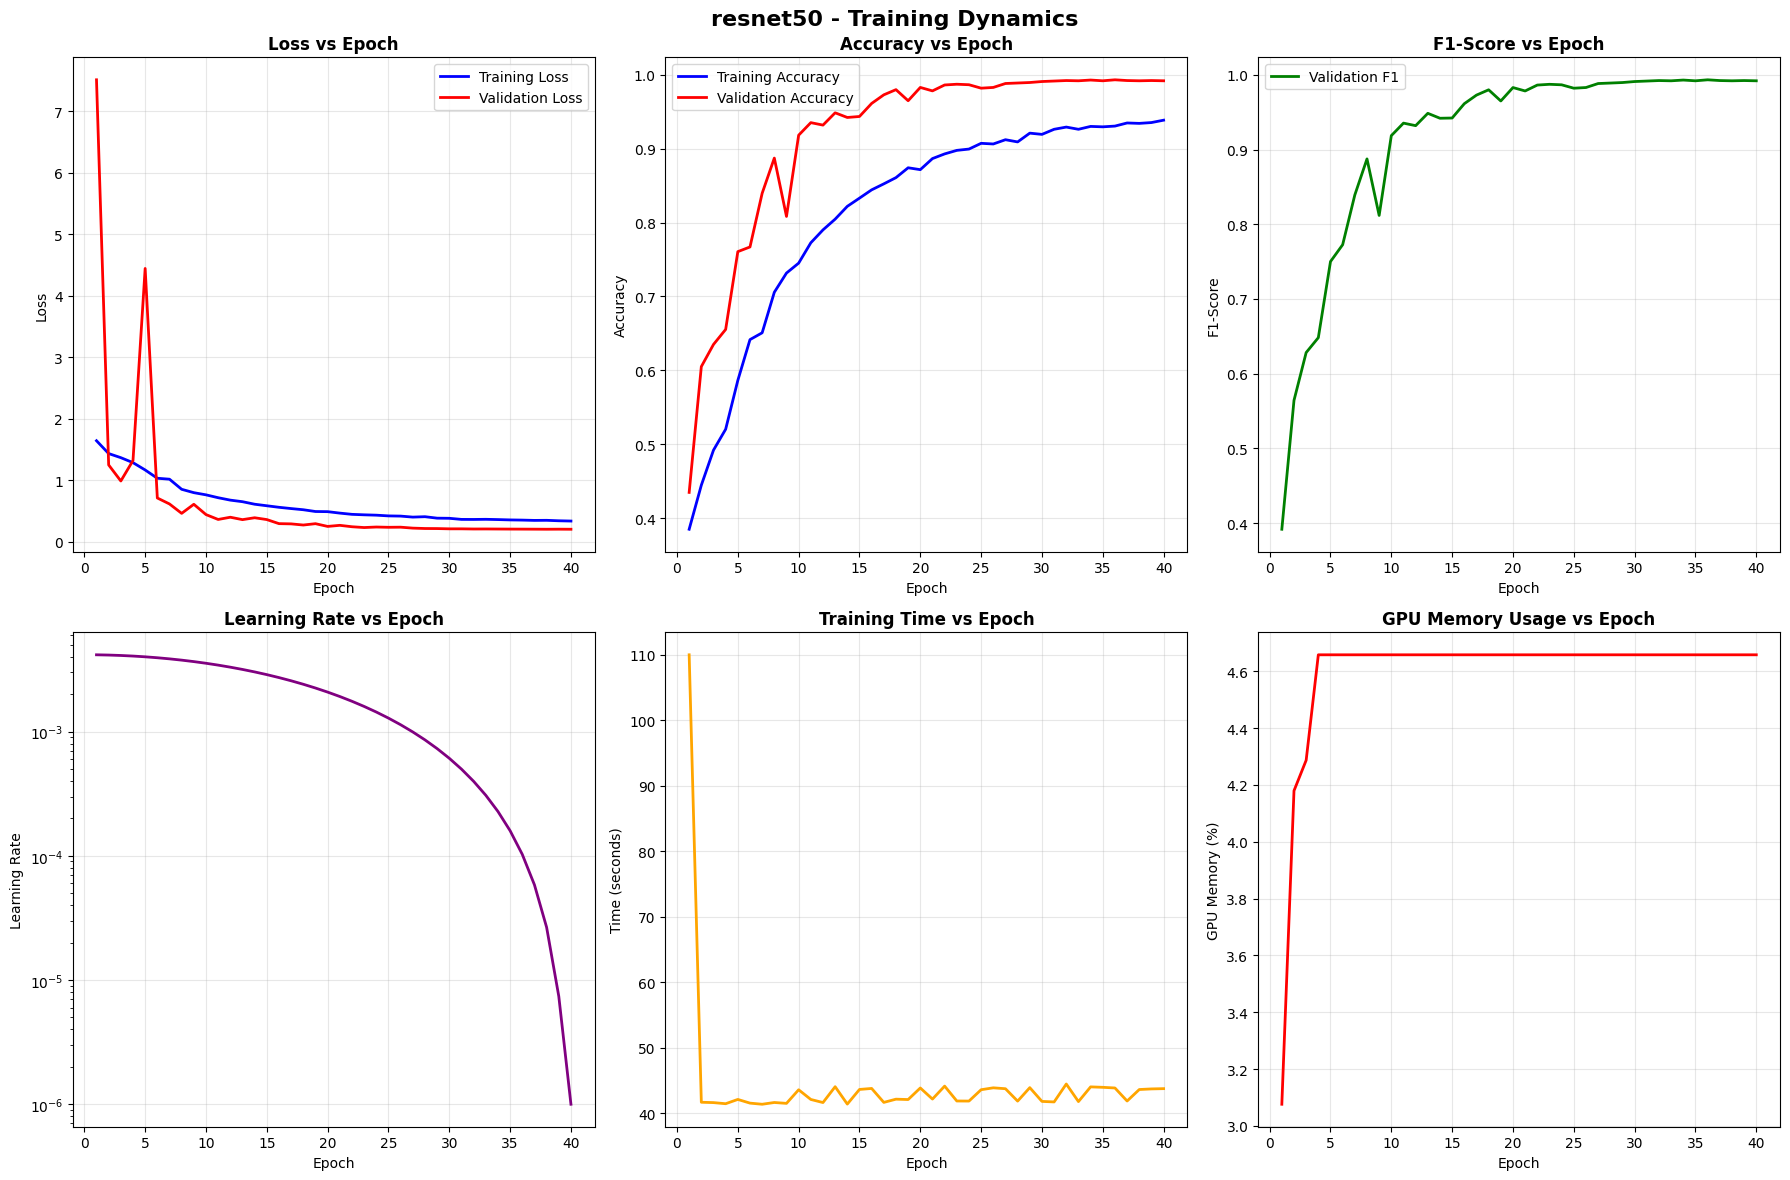

✅ Training dynamics saved: /content/drive/MyDrive/Hilsha/results/single_models/resnet50_training_dynamics.png
Evaluating resnet50 on test data...


Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Sample outputs (first batch): tensor([[10., 10., 10., 10., 10.],
        [10., 10., 10., 10., 10.]], device='cuda:0')
Labels (first batch): tensor([2, 1], dtype=torch.int32)
Batch 1/53 - Pred min/max: 0/0

Evaluation:   2%|▏         | 1/53 [00:00<00:12,  4.31it/s]

Batch 4/53 - Pred min/max: 0/0

Evaluation:   8%|▊         | 4/53 [00:00<00:03, 12.39it/s]

Batch 7/53 - Pred min/max: 0/0

Evaluation:  13%|█▎        | 7/53 [00:00<00:02, 16.14it/s]

Batch 10/53 - Pred min/max: 0/0

Evaluation:  19%|█▉        | 10/53 [00:00<00:02, 18.20it/s]

Batch 13/53 - Pred min/max: 0/0

Evaluation:  25%|██▍       | 13/53 [00:00<00:02, 19.43it/s]

Batch 16/53 - Pred min/max: 0/0

Evaluation:  30%|███       | 16/53 [00:00<00:01, 20.20it/s]

Batch 19/53 - Pred min/max: 0/0

Evaluation:  36%|███▌      | 19/53 [00:01<00:01, 20.62it/s]

Batch 22/53 - Pred min/max: 0/0

Evaluation:  42%|████▏     | 22/53 [00:01<00:01, 20.82it/s]

Batch 25/53 - Pred min/max: 0/0

Evaluation:  47%|████▋     | 25/53 [00:01<00:01, 21.00it/s]

Batch 28/53 - Pred min/max: 0/0

Evaluation:  53%|█████▎    | 28/53 [00:01<00:01, 21.17it/s]

Batch 31/53 - Pred min/max: 0/0

Evaluation:  58%|█████▊    | 31/53 [00:01<00:01, 21.36it/s]

Batch 34/53 - Pred min/max: 0/0

Evaluation:  64%|██████▍   | 34/53 [00:01<00:00, 21.48it/s]

Batch 37/53 - Pred min/max: 0/0

Evaluation:  70%|██████▉   | 37/53 [00:01<00:00, 21.55it/s]

Batch 40/53 - Pred min/max: 0/0

Evaluation:  75%|███████▌  | 40/53 [00:02<00:00, 21.57it/s]

Batch 43/53 - Pred min/max: 0/0

Evaluation:  81%|████████  | 43/53 [00:02<00:00, 21.53it/s]

Batch 46/53 - Pred min/max: 0/0

Evaluation:  87%|████████▋ | 46/53 [00:02<00:00, 21.52it/s]

Batch 49/53 - Pred min/max: 0/0

Evaluation:  92%|█████████▏| 49/53 [00:02<00:00, 21.49it/s]

Batch 52/53 - Pred min/max: 0/0

Evaluation:  98%|█████████▊| 52/53 [00:02<00:00, 21.59it/s]

Batch 53/53 - Pred min/max: 0/0

Valid samples: 1682, Invalid: 0


Computed test accuracy for resnet50: 0.3567 (labels unique: [0 1 2 3 4])
Classification report saved: /content/drive/MyDrive/Hilsha/results/single_models/resnet50_classification_report.csv
Class-wise metrics - Classes: ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']
Precision: [0.356718192627824, 0.0, 0.0, 0.0, 0.0]
Recall: [1.0, 0.0, 0.0, 0.0, 0.0]
F1: [0.5258545135845749, 0.0, 0.0, 0.0, 0.0]
Class-wise metrics plot generated
Per-class F1 - Classes: ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']
F1 scores: [0.5258545135845749, 0.0, 0.0, 0.0, 0.0]
Per-class F1 scores plot generated


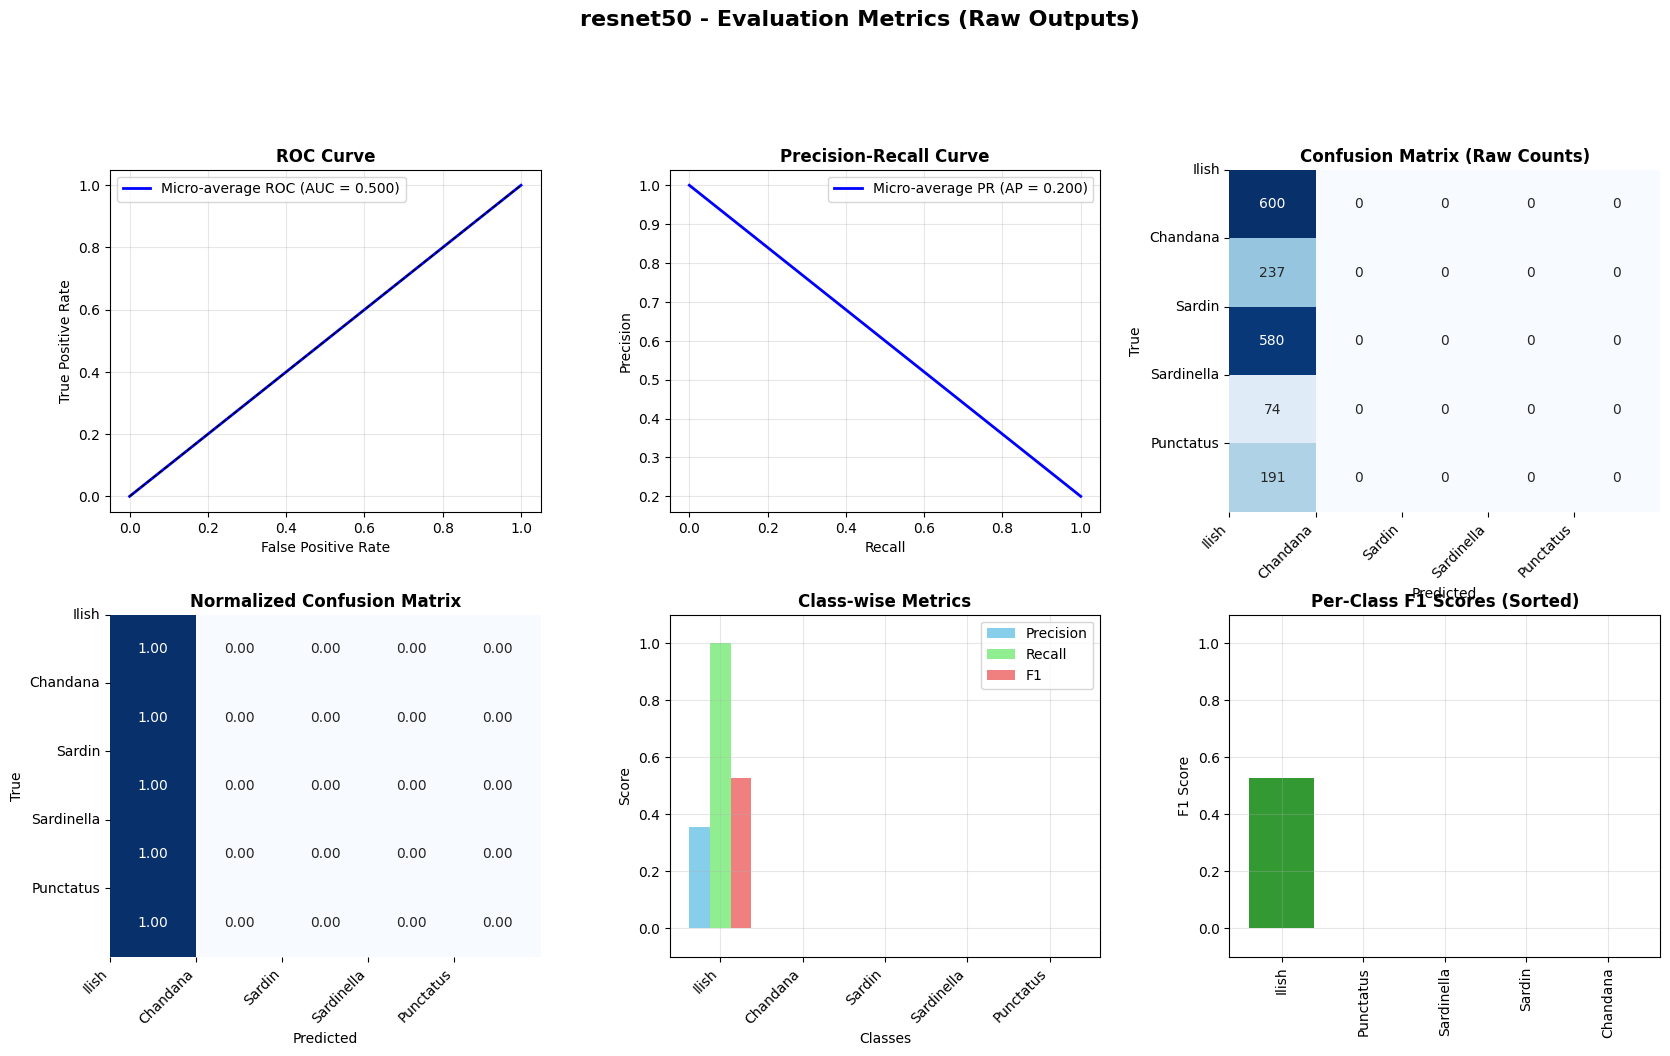

✅ Evaluation metrics saved: /content/drive/MyDrive/Hilsha/results/single_models/resnet50_evaluation_metrics.png


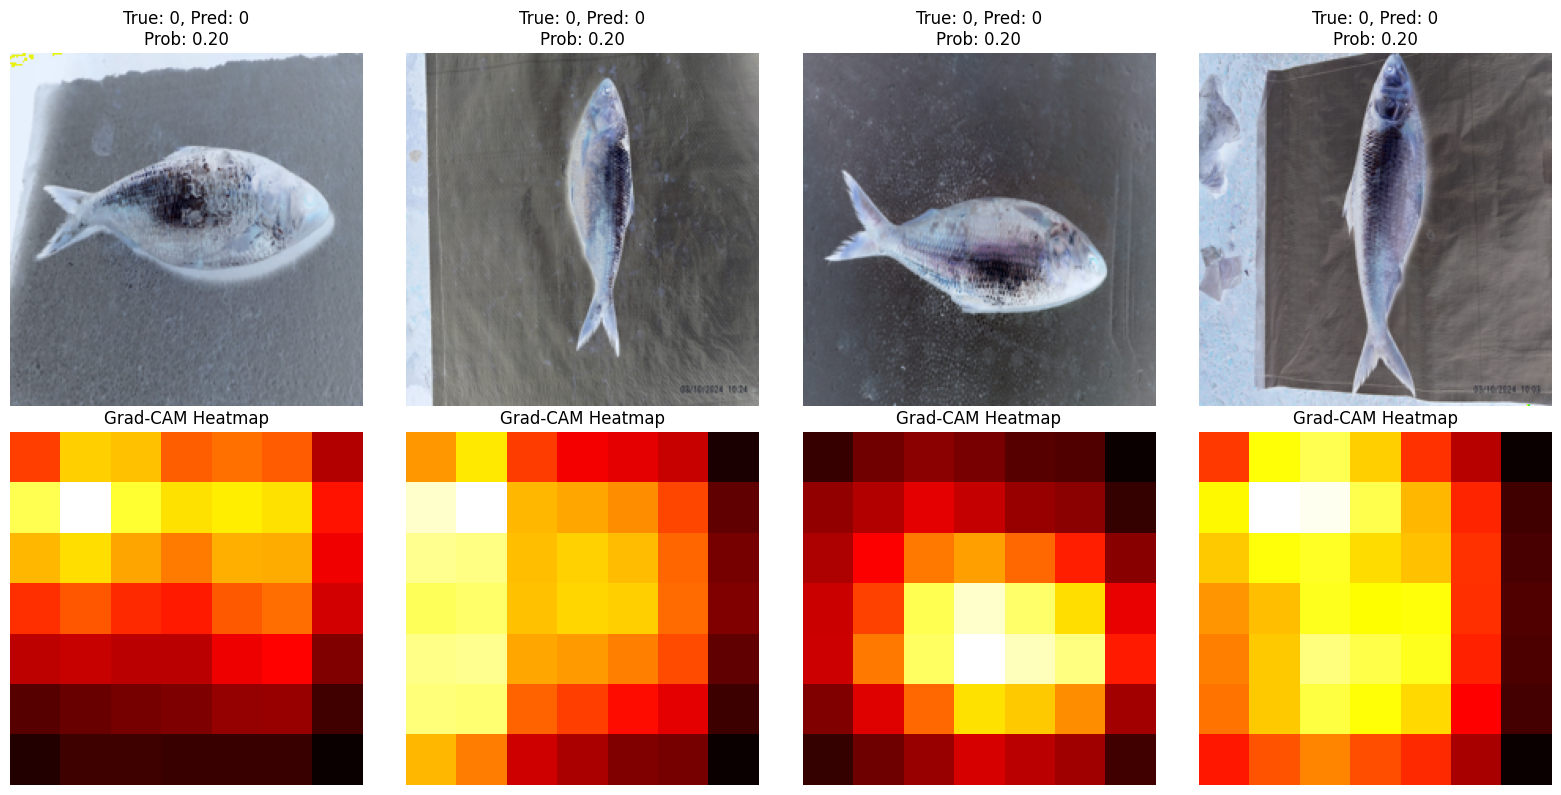

✅ XAI for correct saved: /content/drive/MyDrive/Hilsha/results/single_models/resnet50_xai_correct.png


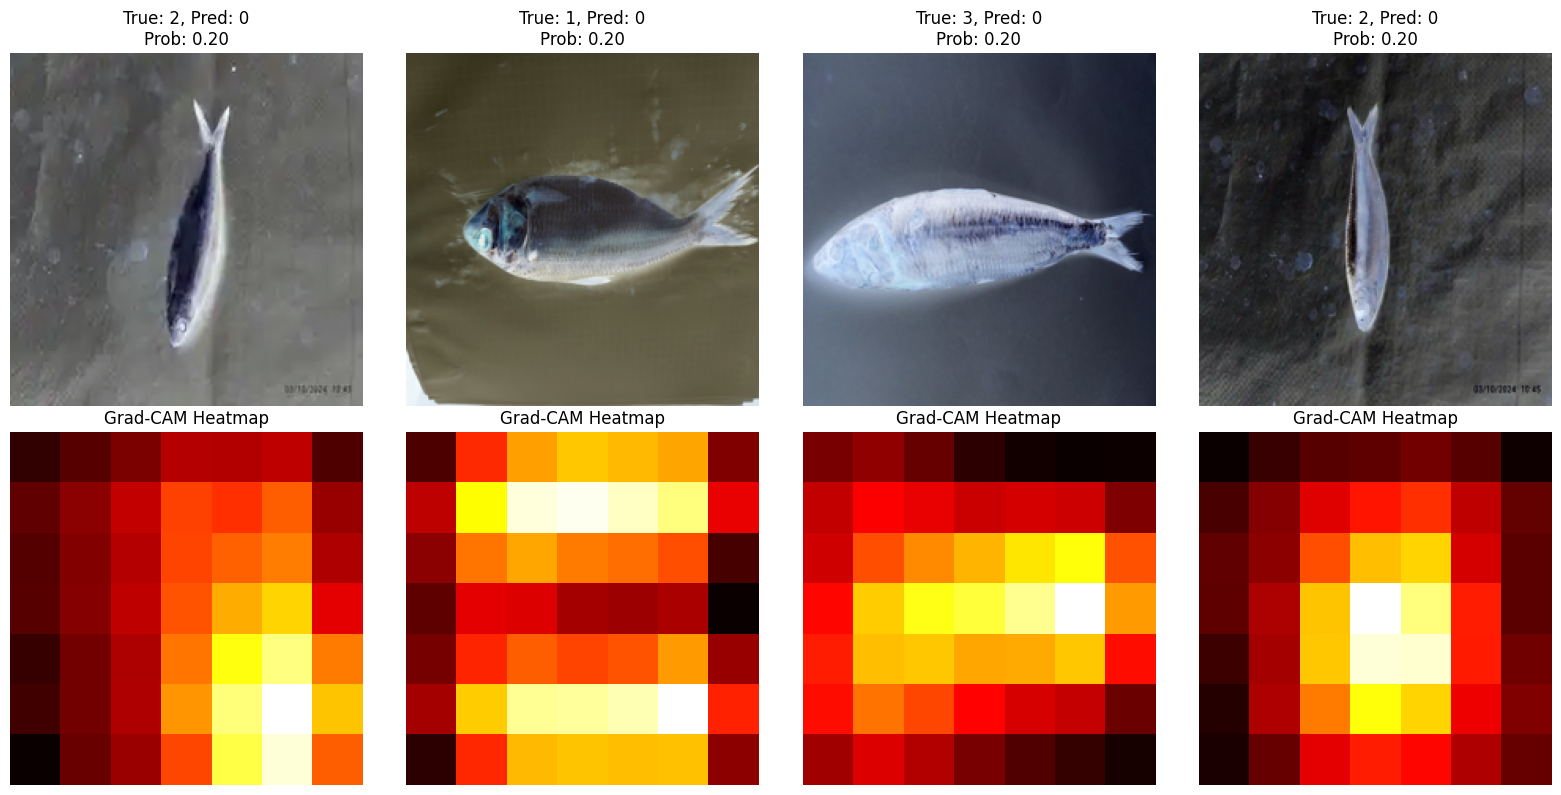

✅ XAI for incorrect saved: /content/drive/MyDrive/Hilsha/results/single_models/resnet50_xai_incorrect.png
Error grid saved: /content/drive/MyDrive/Hilsha/results/single_models/resnet50_validation_error_grid.png


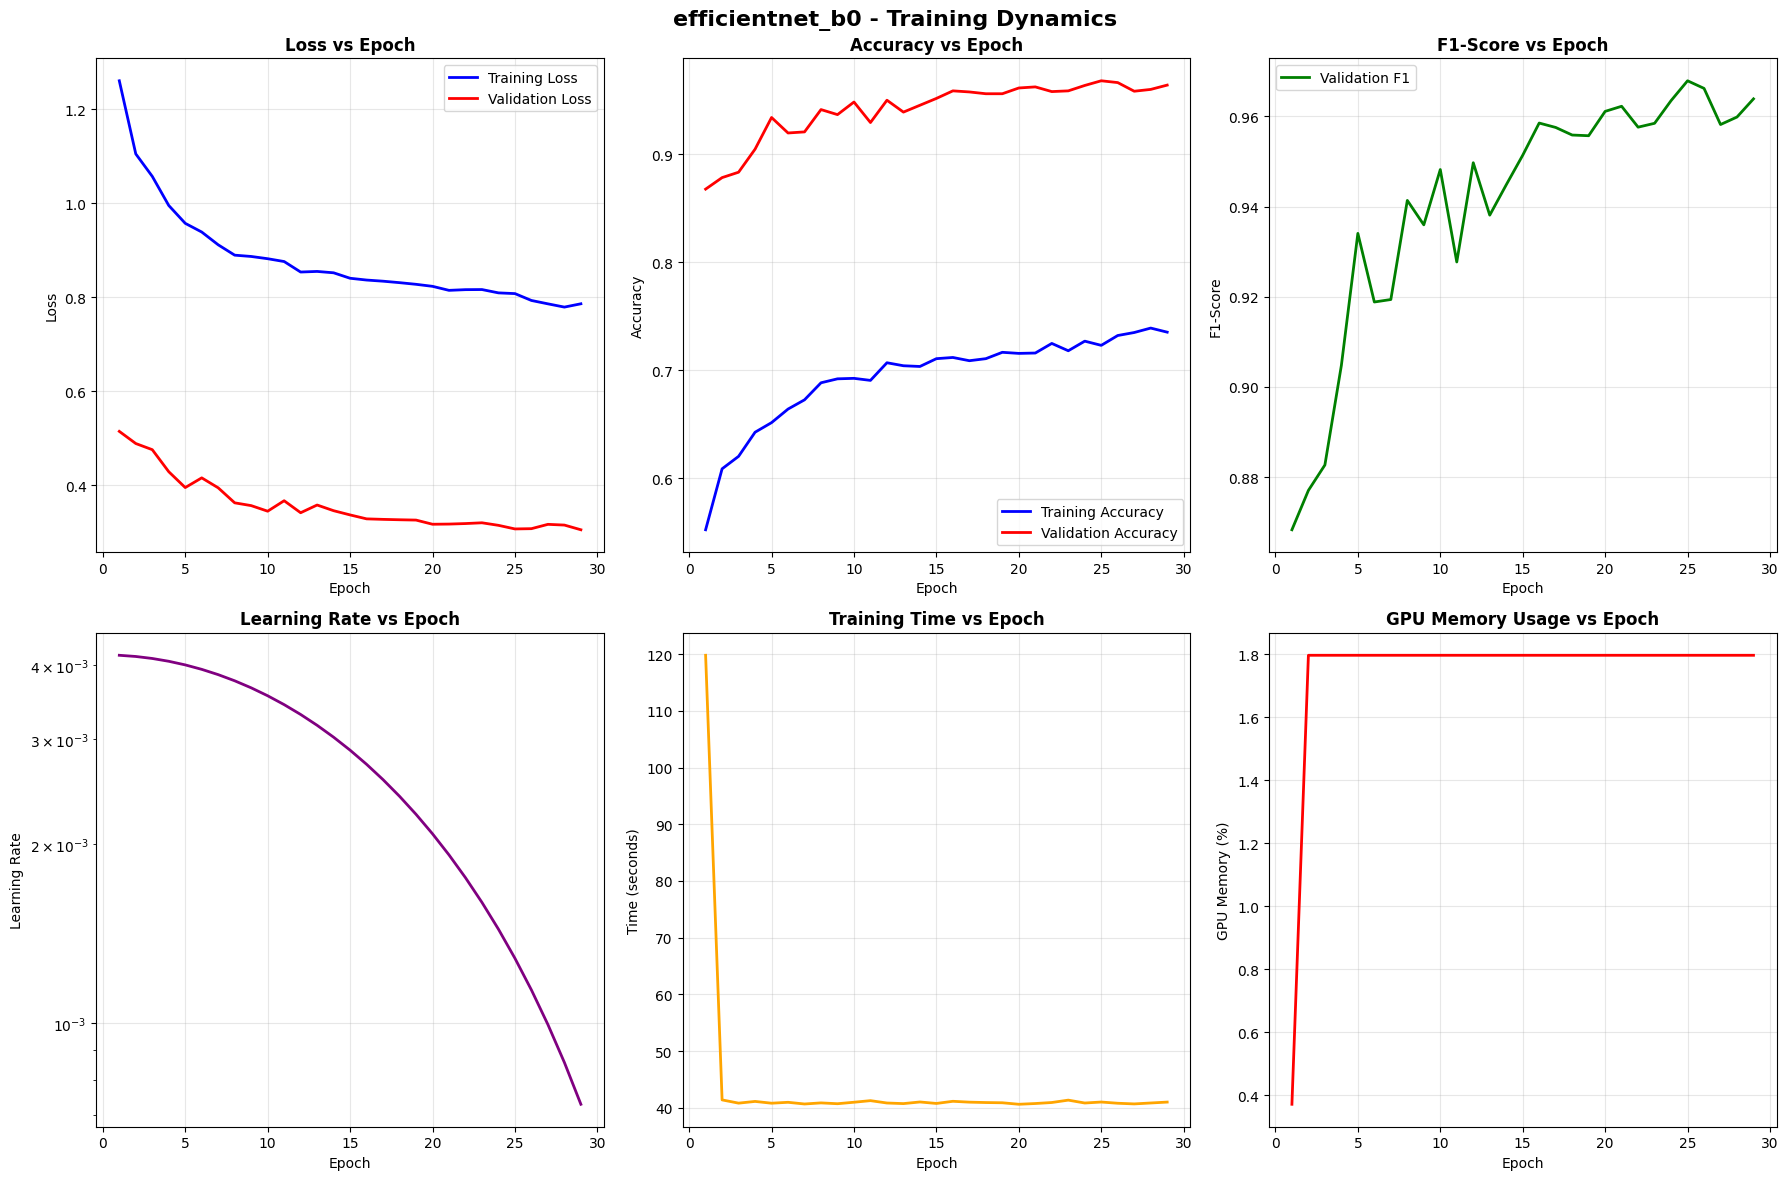

✅ Training dynamics saved: /content/drive/MyDrive/Hilsha/results/single_models/efficientnet_b0_training_dynamics.png
Evaluating efficientnet_b0 on test data...


Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Sample outputs (first batch): tensor([[-10.0000,   7.6751,  10.0000,   9.6391, -10.0000],
        [-10.0000,  10.0000, -10.0000, -10.0000,  10.0000]], device='cuda:0')
Labels (first batch): tensor([2, 1], dtype=torch.int32)
Batch 1/53 - Pred min/max: 0/4

Evaluation:   2%|▏         | 1/53 [00:00<00:11,  4.43it/s]

Batch 5/53 - Pred min/max: 0/3

Evaluation:   9%|▉         | 5/53 [00:00<00:03, 15.38it/s]

Batch 8/53 - Pred min/max: 0/4

Evaluation:  15%|█▌        | 8/53 [00:00<00:02, 19.24it/s]

Batch 11/53 - Pred min/max: 0/4

Evaluation:  21%|██        | 11/53 [00:00<00:02, 20.16it/s]

Batch 14/53 - Pred min/max: 0/4

Evaluation:  26%|██▋       | 14/53 [00:00<00:01, 21.97it/s]

Batch 17/53 - Pred min/max: 0/3

Evaluation:  32%|███▏      | 17/53 [00:00<00:01, 21.93it/s]

Batch 21/53 - Pred min/max: 0/4

Evaluation:  40%|███▉      | 21/53 [00:01<00:01, 23.44it/s]

Batch 24/53 - Pred min/max: 0/4

Evaluation:  45%|████▌     | 24/53 [00:01<00:01, 24.94it/s]

Batch 27/53 - Pred min/max: 0/3

Evaluation:  51%|█████     | 27/53 [00:01<00:01, 24.24it/s]

Batch 31/53 - Pred min/max: 0/4

Evaluation:  58%|█████▊    | 31/53 [00:01<00:00, 25.07it/s]

Batch 35/53 - Pred min/max: 0/4

Evaluation:  66%|██████▌   | 35/53 [00:01<00:00, 25.33it/s]

Batch 39/53 - Pred min/max: 0/4

Evaluation:  74%|███████▎  | 39/53 [00:01<00:00, 25.78it/s]

Batch 43/53 - Pred min/max: 0/4

Evaluation:  81%|████████  | 43/53 [00:01<00:00, 25.97it/s]

Batch 46/53 - Pred min/max: 0/4

Evaluation:  87%|████████▋ | 46/53 [00:01<00:00, 26.07it/s]

Batch 49/53 - Pred min/max: 0/4

Evaluation:  92%|█████████▏| 49/53 [00:02<00:00, 25.18it/s]

Batch 52/53 - Pred min/max: 0/4

Evaluation:  98%|█████████▊| 52/53 [00:02<00:00, 26.26it/s]

Batch 53/53 - Pred min/max: 0/3

Valid samples: 1682, Invalid: 0


Computed test accuracy for efficientnet_b0: 0.2057 (labels unique: [0 1 2 3 4])
Classification report saved: /content/drive/MyDrive/Hilsha/results/single_models/efficientnet_b0_classification_report.csv
Class-wise metrics - Classes: ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']
Precision: [0.3543956043956044, 0.12033195020746888, 0.3877551020408163, 0.03768844221105527, 0.11578947368421053]
Recall: [0.215, 0.24472573839662448, 0.2293103448275862, 0.20270270270270271, 0.05759162303664921]
F1: [0.2676348547717842, 0.16133518776077885, 0.28819068255687974, 0.0635593220338983, 0.07692307692307693]
Class-wise metrics plot generated
Per-class F1 - Classes: ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']
F1 scores: [0.2676348547717842, 0.16133518776077885, 0.28819068255687974, 0.0635593220338983, 0.07692307692307693]
Per-class F1 scores plot generated


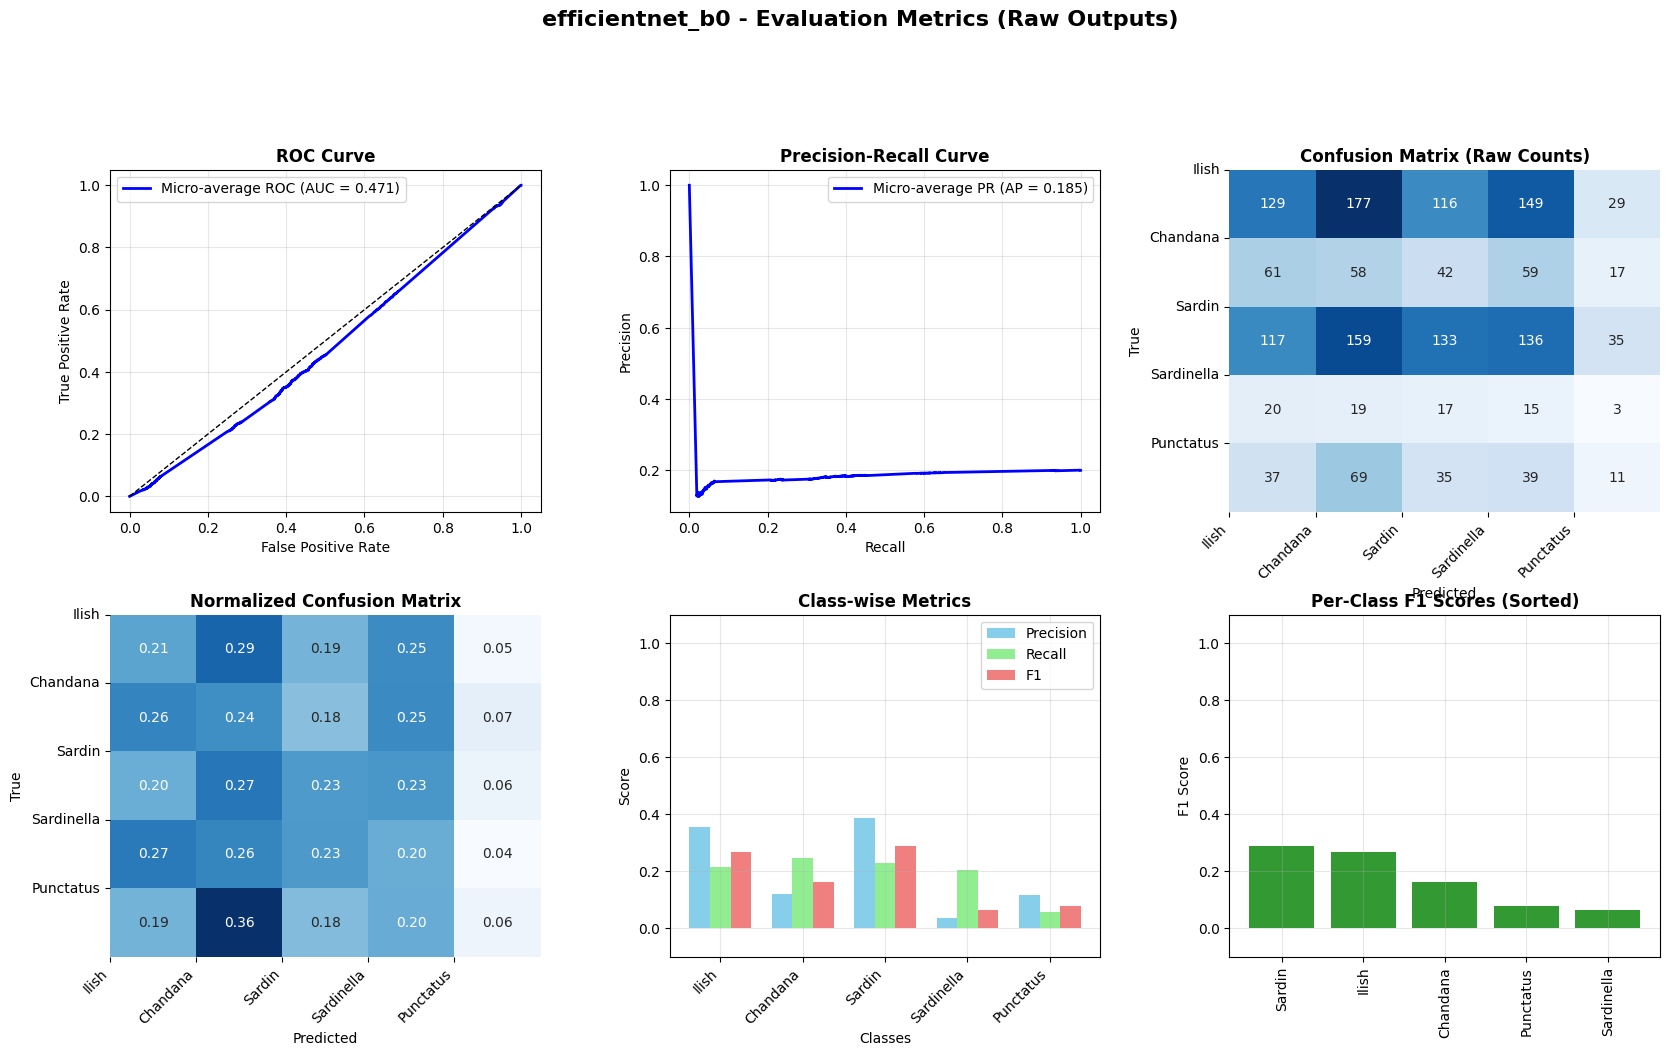

✅ Evaluation metrics saved: /content/drive/MyDrive/Hilsha/results/single_models/efficientnet_b0_evaluation_metrics.png


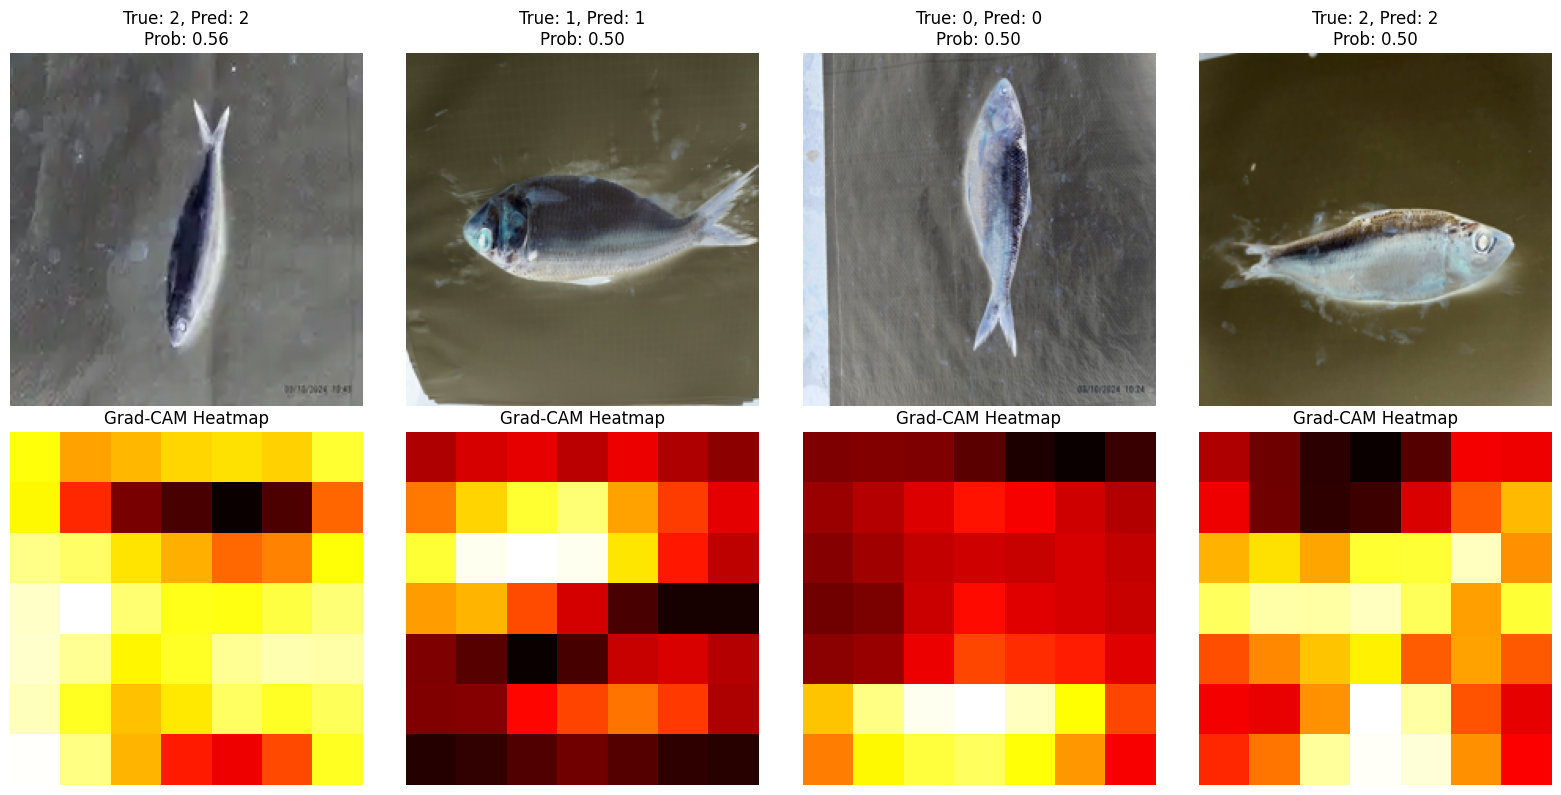

✅ XAI for correct saved: /content/drive/MyDrive/Hilsha/results/single_models/efficientnet_b0_xai_correct.png


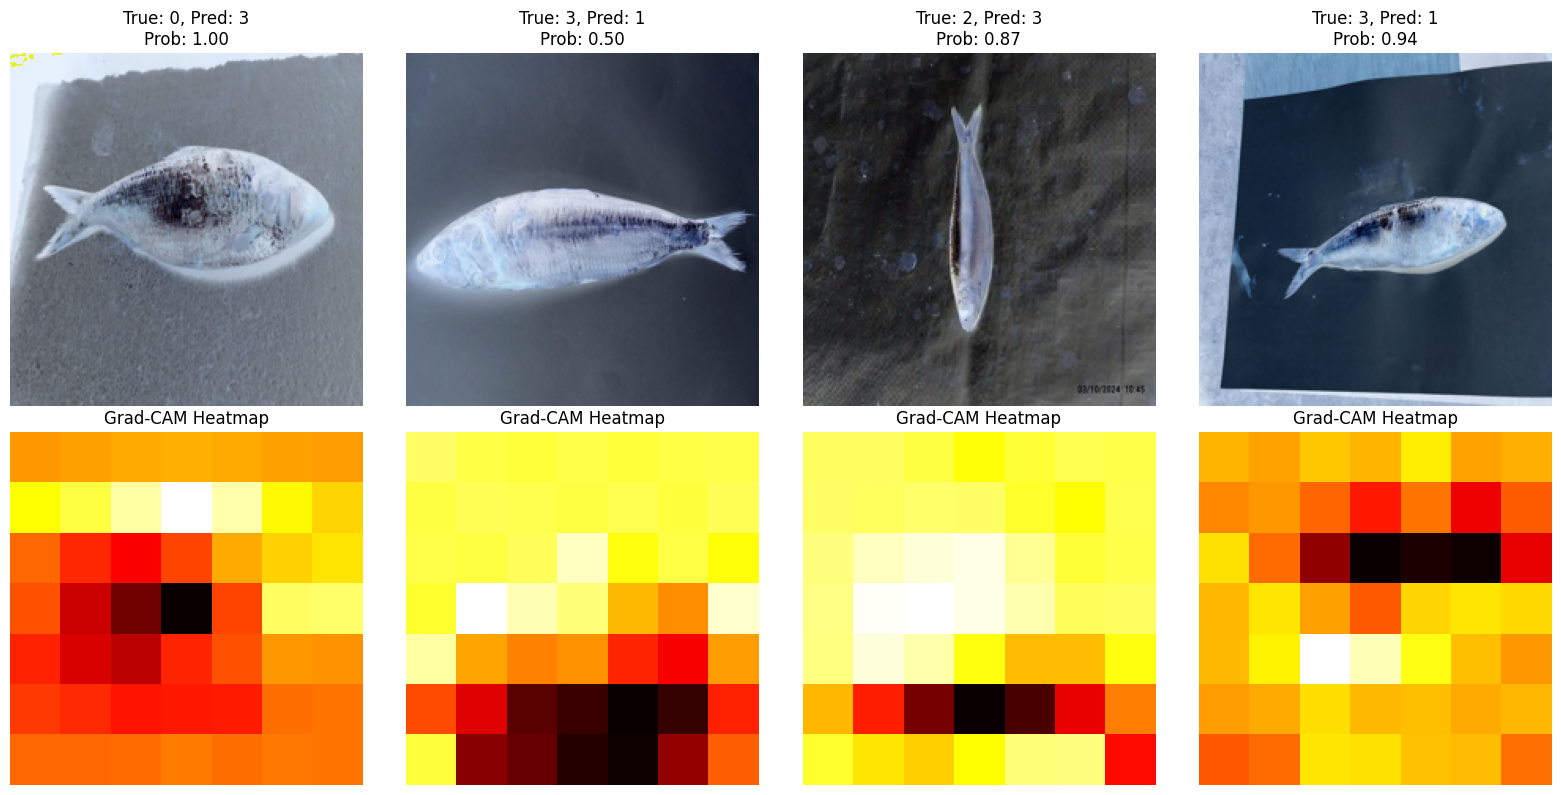

✅ XAI for incorrect saved: /content/drive/MyDrive/Hilsha/results/single_models/efficientnet_b0_xai_incorrect.png
Error grid saved: /content/drive/MyDrive/Hilsha/results/single_models/efficientnet_b0_validation_error_grid.png

=== SINGLE MODELS COMPARISON ===


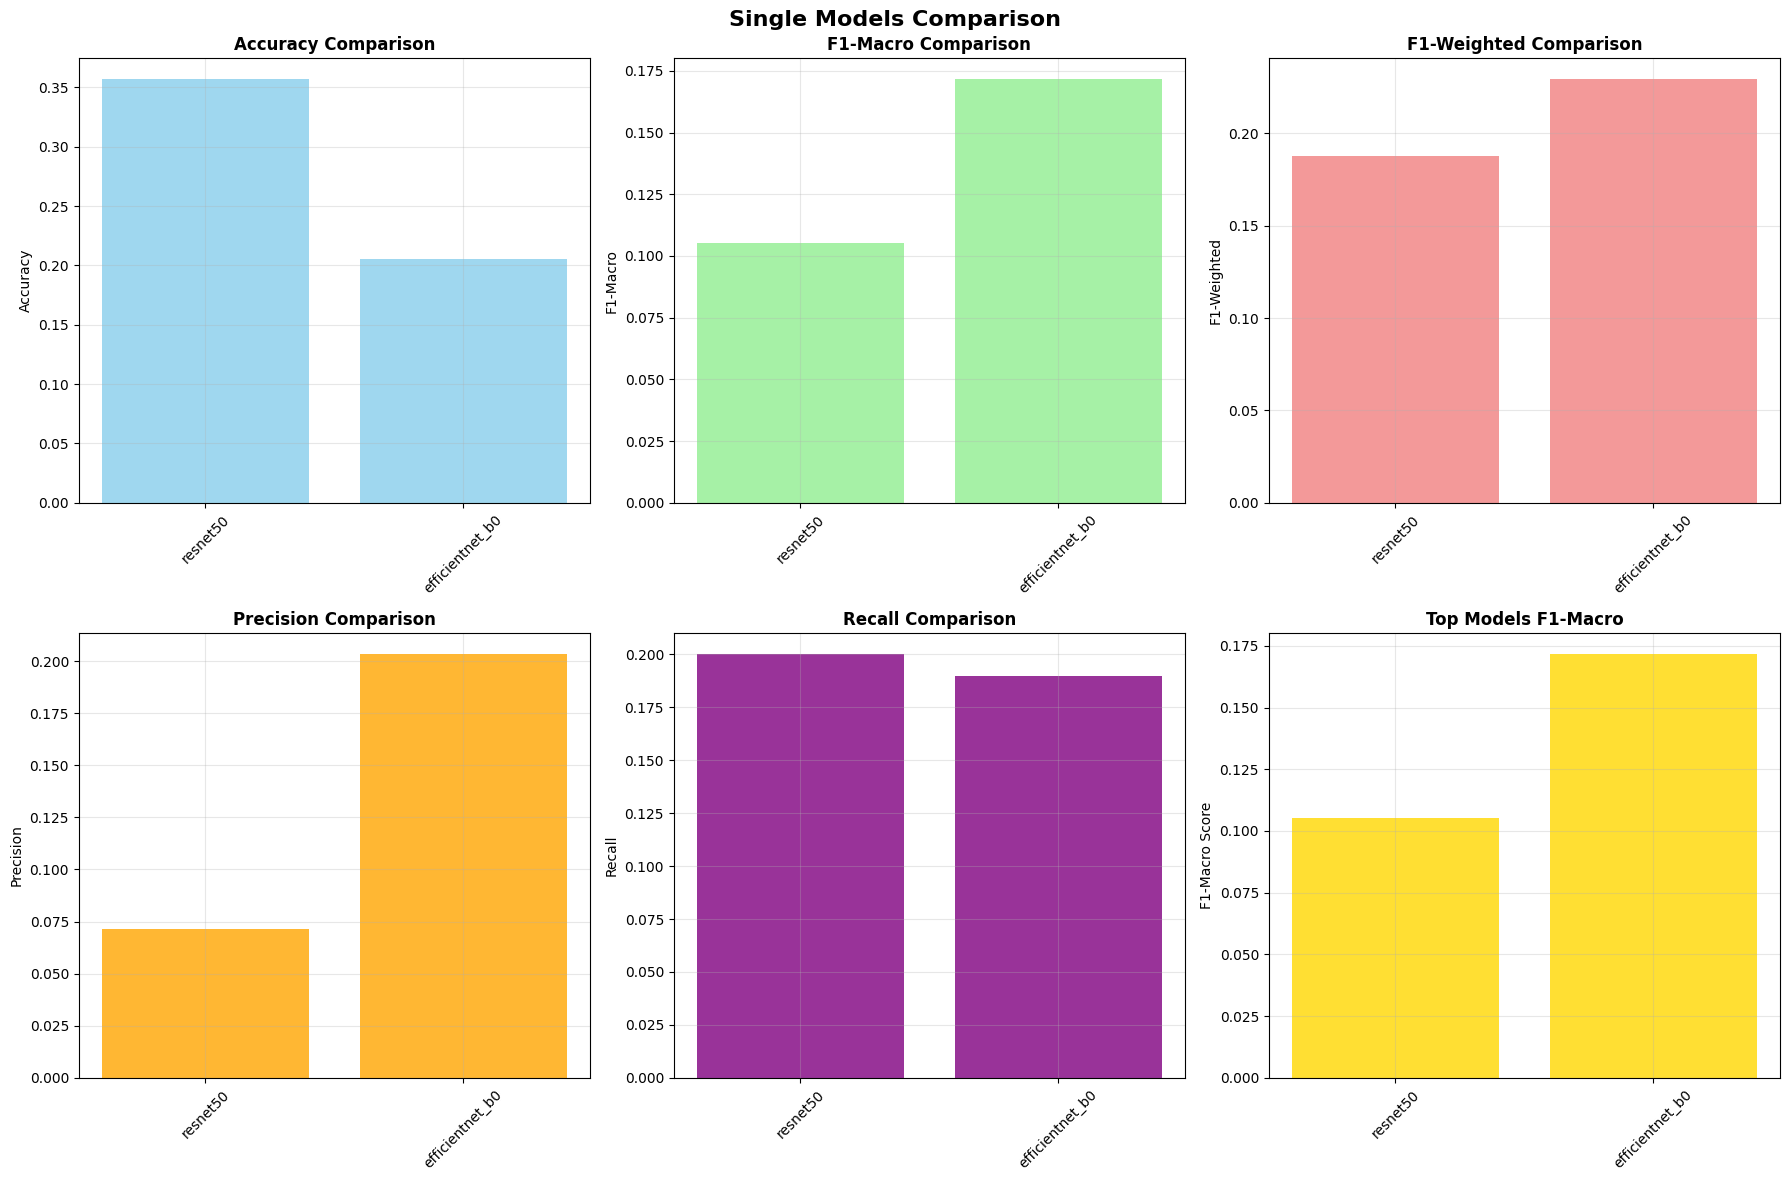

Single models comparison saved: /content/drive/MyDrive/Hilsha/results/comparisons/single_models_comparison.png
Best single model: efficientnet_b0 (F1-Macro: 0.1715)

SECTION 2: K-FOLD MODELS ANALYSIS
Evaluating fold: resnet50_fold_1
Evaluating resnet50_fold_1 on test data...


Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Sample outputs (first batch): tensor([[ 3.0863,  6.8864, -6.1449,  2.1687, 10.0000],
        [10.0000, 10.0000, 10.0000, 10.0000, 10.0000]], device='cuda:0')
Labels (first batch): tensor([2, 1], dtype=torch.int32)
Batch 1/53 - Pred min/max: 0/4

Evaluation:   2%|▏         | 1/53 [00:00<00:13,  3.98it/s]

Batch 4/53 - Pred min/max: 0/4

Evaluation:   8%|▊         | 4/53 [00:00<00:04, 11.78it/s]

Batch 7/53 - Pred min/max: 0/4

Evaluation:  13%|█▎        | 7/53 [00:00<00:02, 15.63it/s]

Batch 10/53 - Pred min/max: 0/4

Evaluation:  19%|█▉        | 10/53 [00:00<00:02, 17.78it/s]

Batch 13/53 - Pred min/max: 0/4

Evaluation:  25%|██▍       | 13/53 [00:00<00:02, 19.10it/s]

Batch 16/53 - Pred min/max: 0/4

Evaluation:  30%|███       | 16/53 [00:00<00:01, 19.96it/s]

Batch 19/53 - Pred min/max: 0/4

Evaluation:  36%|███▌      | 19/53 [00:01<00:01, 20.48it/s]

Batch 22/53 - Pred min/max: 0/4

Evaluation:  42%|████▏     | 22/53 [00:01<00:01, 20.74it/s]

Batch 25/53 - Pred min/max: 0/4

Evaluation:  47%|████▋     | 25/53 [00:01<00:01, 20.93it/s]

Batch 28/53 - Pred min/max: 0/4

Evaluation:  53%|█████▎    | 28/53 [00:01<00:01, 21.14it/s]

Batch 31/53 - Pred min/max: 0/4

Evaluation:  58%|█████▊    | 31/53 [00:01<00:01, 21.30it/s]

Batch 32/53 - Pred min/max: 0/4

In [ ]:
# ============================================================================
# Dataset
# ============================================================================
class FishDataset(Dataset):
    """Dataset for loading NumPy arrays"""
    def __init__(self, images: np.ndarray, labels: np.ndarray, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Ensure images are in (N, H, W, C) format
        if self.images.shape[-1] not in [3, 4]:  # Check if last dimension is channels
            if self.images.shape[1] in [3, 4]:  # Check if second dimension is channels
                self.images = np.transpose(self.images, (0, 2, 3, 1))  # Convert (N, C, H, W) to (N, H, W, C)
            else:
                raise ValueError(f"Unexpected image shape: {self.images.shape}")

        # Clean NaNs in images
        self.images = np.nan_to_num(self.images.astype(np.float32), nan=0.0)

        # Check label range
        if np.max(self.labels) >= Config.NUM_CLASSES or np.min(self.labels) < 0:
            raise ValueError(f"Labels out of range [0, {Config.NUM_CLASSES-1}]: min={np.min(self.labels)}, max={np.max(self.labels)}")

        print(f"Loaded {len(self.images)} samples")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label



# Define DataManager with get_transforms and create_data_loaders
class DataManager:
    @staticmethod
    def get_transforms(is_train, augmentation_strength='medium'):
        if is_train:
            if augmentation_strength == 'medium':
                return transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((224, 224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
            # Add other strengths if needed
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    @staticmethod
    def create_data_loaders(X, Y, test_size=0.2, batch_size=None, augmentation_strength='medium', persistent_workers=True):
        X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=test_size, random_state=Config.SEED, stratify=Y)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=Config.SEED, stratify=y_temp)

        print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
        print(f"Using optimized batch size: {batch_size}")

        train_dataset = FishDataset(X_train, y_train, DataManager.get_transforms(True, augmentation_strength))
        val_dataset = FishDataset(X_val, y_val, DataManager.get_transforms(False))
        test_dataset = FishDataset(X_test, y_test, DataManager.get_transforms(False))

        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        sample_weights = [class_weights[y] for y in y_train]
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

        prefetch_factor = 2 if Config.DATALOADER_NUM_WORKERS > 0 else None
        # pin_memory = Config.PIN_MEMORY if 'cuda' in Config.DEVICE else False
        pin_memory = Config.PIN_MEMORY if 'cuda' in str(Config.DEVICE) else False
        num_workers = Config.DATALOADER_NUM_WORKERS if torch.cuda.is_available() else 0
        use_prefetch = num_workers > 0

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            # sampler=sampler, #Imbalanced dataset → use sampler. Balanced dataset → use shuffle=True.
            shuffle=True,
            num_workers=num_workers,
            pin_memory=pin_memory,
            prefetch_factor=prefetch_factor if use_prefetch else None,
            persistent_workers=persistent_workers if num_workers > 0 else False,
            worker_init_fn=worker_init_fn
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory,
            prefetch_factor=prefetch_factor if use_prefetch else None,
            persistent_workers=persistent_workers if num_workers > 0 else False,
            worker_init_fn=worker_init_fn
        )
        fake_test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory,
            prefetch_factor=prefetch_factor if use_prefetch else None,
            persistent_workers=persistent_workers if num_workers > 0 else False,
            worker_init_fn=worker_init_fn
        )

        return train_loader, val_loader, fake_test_loader, (X_val, y_val), (X_test, y_test)





##############################################################################################################################################
# ============================================================================
# Main Execution
# ============================================================================
# Main execution block
if __name__ == "__main__":
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Verify model directory
    model_dir = Path(Config.MODELS_DIR)
    if model_dir.exists():
        print(f"Model directory found: {model_dir}")
        print(f"Files: {list(model_dir.glob('*'))}")
    else:
        print(f"Model directory not found: {model_dir}")
        print("Please verify the path or move model files to the correct location")

    # Initialize model manager
    model_manager = ModelManager()
    model_manager.load_all_models()

    # Load data
    X = np.load(Config.DATA_FILE)
    Y = np.load(Config.LABELS_FILE)

    train_loader, val_loader, fake_test_loader, val_data, test_data = DataManager.create_data_loaders(
        X, Y, test_size=0.2,
        batch_size=32       #Config.BATCH_SIZE,
    )

    fake_test_loader=val_loader

    # Clean test loader for evaluation
    test_dataset = fake_test_loader.dataset
    clean_images = np.nan_to_num(test_dataset.images.astype(np.float32), nan=0.0)  # Replace NaNs with 0.0
    clean_labels = test_dataset.labels.copy()
    clean_test_dataset = type(test_dataset)(clean_images, clean_labels, test_dataset.transform)
    clean_fake_test_loader = DataLoader(
        clean_test_dataset,
        batch_size=fake_test_loader.batch_size,
        shuffle=False,
        num_workers=fake_test_loader.num_workers,
        pin_memory=fake_test_loader.pin_memory
    )

    fake_test_loader = clean_fake_test_loader  # Use clean loader for all evaluations


    # === SECTION 1: SINGLE MODELS ANALYSIS ===
    print("\n" + "="*50)
    print("SECTION 1: SINGLE MODELS ANALYSIS")
    print("="*50)
    single_analyzer = SingleModelAnalyzer(model_manager)
    single_model_results = {}


    # Display single models performance summary first
    print("\nSingle Models Performance Summary (from training history & test eval):")
    performance_data = []
    for model_name, history in model_manager.training_histories.items():
        if 'training_history' in history:
            train_history = history['training_history']
            last_epoch = len(train_history.get('train_loss', [])) - 1
            if last_epoch >= 0:
                tl = train_history['train_loss'][last_epoch]
                vl = train_history['val_loss'][last_epoch]
                ta = train_history['train_acc'][last_epoch]
                va = train_history['val_acc'][last_epoch]
                tf1 = train_history.get('train_f1', [0.0] * (last_epoch + 1))[last_epoch]
                vf1 = train_history['val_f1'][last_epoch]
                # For test f1 and inference time, use eval_results on clean loader
                model = model_manager.models.get(model_name)
                if model:
                    eval_results = single_analyzer.evaluate_model_comprehensive(model_name, model, fake_test_loader)
                    test_f1 = eval_results['f1_macro']
                    inference_time = eval_results.get('inference_time_ms', 0.0)  # Use get with default
                else:
                    test_f1 = 0.0
                    inference_time = 0.0
                performance_data.append([model_name, tl, vl, ta, va, tf1, vf1, test_f1, inference_time])

    if performance_data:
        performance_df = pd.DataFrame(
            performance_data,
            columns=['Model', 'Train Loss', 'Val Loss', 'Train Acc', 'Val Acc', 'Train F1', 'Val F1', 'Test F1', 'Inference Time (ms)']
        )
        print(performance_df.to_string(index=False))
        csv_path = Path(Config.SINGLE_MODELS_DIR) / "single_models_performance_summary.csv"
        performance_df.to_csv(csv_path, index=False)
        print(f"Performance summary saved: {csv_path}")
        del performance_data
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Evaluate single models (non-fold)
    for model_name, model in model_manager.models.items():
        if '_fold_' not in model_name.lower():
            history = model_manager.training_histories.get(model_name)
            if history:
                single_analyzer.plot_training_dynamics(model_name, history)

            eval_results = single_analyzer.evaluate_model_comprehensive(model_name, model, fake_test_loader)
            single_analyzer.plot_evaluation_metrics(model_name, eval_results)
            single_analyzer.plot_xai_examples(model_name, model, eval_results)
            single_analyzer.plot_error_grid(model_name, eval_results)
            single_model_results[model_name] = eval_results

    # Compare single models
    comparative = ComparativeAnalyzer(model_manager)
    best_single = comparative.compare_single_models(single_model_results)



    # === SECTION 2: K-FOLD MODELS ANALYSIS ===
    print("\n" + "="*50)
    print("SECTION 2: K-FOLD MODELS ANALYSIS")
    print("="*50)
    fold_results = {}
    for model_name, model in model_manager.models.items():
        if '_fold_' in model_name.lower():
            base_model = model_name.split('_fold_')[0]
            if base_model in Config.MODELS:  # Only process folds for models in Config.MODELS
                if base_model not in fold_results:
                    fold_results[base_model] = {}
                print(f"Evaluating fold: {model_name}")
                eval_results = single_analyzer.evaluate_model_comprehensive(model_name, model, fake_test_loader)
                fold_results[base_model][model_name] = eval_results

    # Compare k-fold models
    fold_df = comparative.compare_kfold_models(fold_results)




    # SECTION 3: ENSEMBLES
    print("\n" + "="*50)
    print("SECTION 3: ENSEMBLE MODELS ANALYSIS")
    print("="*50)
    ensemble_analyzer = EnsembleAnalyzer()
    ensemble_results = {}

    # Get top 5 models
    single_df = pd.DataFrame({
        'Model': list(single_model_results.keys()),
        'F1_Macro': [res['f1_macro'] for res in single_model_results.values()]
    }).sort_values('F1_Macro', ascending=False)
    top_5_names = single_df.head(5)['Model'].tolist()
    model_manager.models = {name: model_manager.models[name] for name in top_5_names if name in model_manager.models}
    print(f"Retained top 5 models for ensembles: {top_5_names}")
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    top_5_models = [model_manager.models[name] for name in top_5_names if name in model_manager.models]
    print(f"Top 5 models for ensembles: {top_5_names}")

    ensemble_classes = [
        SimpleAverageEnsemble,
        ConfidenceBasedEnsemble,
        StackingEnsemble,
        LearnableWeightedEnsemble,
        SnapshotEnsemble
    ]

    # Evaluate combinations
    for k in range(2, min(4, len(top_5_models) + 1)):
        combos = list(itertools.combinations(range(len(top_5_models)), k))
        for combo_idx in combos[:5]:
            selected_models = [top_5_models[i] for i in combo_idx]
            selected_names = [top_5_names[i] for i in combo_idx]
            combo_name = f"Combo_k{k}_" + '_'.join(sorted(selected_names))

            print(f"Evaluating combination: {combo_name}")

            for ensemble_class in ensemble_classes:
                try:
                    ensemble = ensemble_class(selected_models, model_names=selected_names, num_classes=Config.NUM_CLASSES)

                    if hasattr(ensemble, 'train_meta_model'):
                        ensemble.train_meta_model(val_loader)
                    if hasattr(ensemble, 'train_weights'):
                        ensemble.train_weights(val_loader)

                    full_name = ensemble.get_name() + '_' + combo_name
                    eval_results = ensemble_analyzer.evaluate_ensemble_comprehensive(ensemble, fake_test_loader)
                    eval_results['ensemble_object'] = ensemble

                    # Save ensemble for future use
                    save_path = Path(Config.ENSEMBLES_DIR) / f"{full_name}_model.pt"
                    if hasattr(ensemble, 'state_dict'):
                        torch.save(ensemble.state_dict(), save_path)
                    else:
                        torch.save(ensemble, save_path)
                    print(f"Saved ensemble: {save_path}")

                    # Plot
                    ensemble_analyzer.plot_evaluation_metrics(full_name, eval_results)
                    ensemble_analyzer.plot_xai_examples(full_name, ensemble, eval_results)
                    ensemble_analyzer.plot_error_grid(full_name, eval_results)

                    ensemble_results[full_name] = eval_results

                    # Cleanup
                    del ensemble
                    gc.collect()
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                except Exception as e:
                    print(f"Error evaluating {ensemble_class.__name__} for {combo_name}: {str(e)}")
                    continue




        # Compare ensembles
        best_ensemble = comparative.compare_ensemble_models(ensemble_results)

        # Final comparison
        if best_single and best_ensemble:
            comparative.create_final_comparison(best_single, best_ensemble, single_model_results, ensemble_results, fake_test_loader)

        # Total comparison of all tried models
        all_results = {}
        for name, res in single_model_results.items():
            all_results[name] = {
                'Type': 'Single',
                'Accuracy': res['accuracy'],
                'F1_Macro': res['f1_macro'],
                'F1_Weighted': res['f1_weighted'],
                'Precision_Macro': res['precision_macro'],
                'Recall_Macro': res['recall_macro'],
                'ROC_AUC': res['roc_auc']
            }
        for name, res in ensemble_results.items():
            all_results[name] = {
                'Type': 'Ensemble',
                'Accuracy': res['accuracy'],
                'F1_Macro': res['f1_macro'],
                'F1_Weighted': res['f1_weighted'],
                'Precision_Macro': res['precision_macro'],
                'Recall_Macro': res['recall_macro'],
                'ROC_AUC': res['roc_auc']
            }

        all_df = pd.DataFrame.from_dict(all_results, orient='index')
        all_df = all_df.sort_values('F1_Macro', ascending=False)

        # Save as CSV
        all_csv_path = Path(Config.COMPARISONS_DIR) / "all_models_comparison.csv"
        all_df.to_csv(all_csv_path)

        # For professional table, plot as image
        fig, ax = plt.subplots(figsize=(12, len(all_df) * 0.3 + 2))
        ax.axis('off')
        table = ax.table(cellText=all_df.values, colLabels=all_df.columns, rowLabels=all_df.index, cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)
        plt.title('All Models Comparison', fontsize=16, fontweight='bold')
        table_output_path = Path(Config.COMPARISONS_DIR) / "all_models_comparison_table.png"
        plt.savefig(table_output_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"✅ All models comparison table saved: {table_output_path}")

    print("\n" + "="*50)
    print("ANALYSIS COMPLETE")
    print("="*50)

#🌍 Real-World Data Test


In [ ]:
#!/usr/bin/env python3
"""
Fish Classification System
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
import requests
from io import BytesIO
from google.colab import files
from pathlib import Path
import time

# ModelFactory from previous script (adapted for 5 classes)
class ModelFactory:
    """Factory for creating model architectures for loading weights"""

    @staticmethod
    def create_model(model_name, params=None, num_classes=5, dropout_rate=0.5, hidden_dim_multiplier=0.5):
        """Create model with configurable architecture"""
        if params is None:
            params = {}
        dropout_rate = params.get('dropout', dropout_rate)
        hidden_dim_multiplier = params.get('hidden_dim_multiplier', hidden_dim_multiplier)

        # Enhanced mapping for fold and ensemble models to base architectures
        original_model_name = model_name.lower()
        base_model_name = original_model_name
        if '_fold_' in base_model_name:
            base_model_name = base_model_name.split('_fold_')[0]
        elif '_for_ensemble' in base_model_name:
            base_model_name = base_model_name.split('_for_ensemble')[0]
        elif 'mobilenet_v3_large' in base_model_name:  # Explicit for MobileNet variants
            base_model_name = 'mobilenet_v3_large'
        elif 'vgg16' in base_model_name:
            base_model_name = 'vgg16'
        elif 'densenet121' in base_model_name:
            base_model_name = 'densenet121'
        elif 'inception_v3' in base_model_name:
            base_model_name = 'inception_v3'

        if base_model_name == 'resnet50':
            model = models.resnet50(weights='IMAGENET1K_V2')
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "layer3" in name or "layer4" in name or "fc" in name:
                    param.requires_grad = True

            num_features = model.fc.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.fc = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif base_model_name == 'efficientnet_b0':
            model = models.efficientnet_b0(weights='IMAGENET1K_V1')
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "_blocks.15" in name or "_blocks.16" in name or "classifier" in name:
                    param.requires_grad = True
            num_features = model.classifier[1].in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif base_model_name == 'mobilenet_v3_large':
            model = models.mobilenet_v3_large(weights='IMAGENET1K_V2')
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "features.12" in name or "features.13" in name or "classifier" in name:
                    param.requires_grad = True
            num_features = 960
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif base_model_name == 'vgg16':
            model = models.vgg16(weights='IMAGENET1K_V1')
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "classifier" in name or "features.28" in name:
                    param.requires_grad = True
            hidden_dim = int(4096 * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 4096),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(4096, hidden_dim),
                nn.ReLU(True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_dim, num_classes)
            )

        elif base_model_name == 'densenet121':
            model = models.densenet121(weights='IMAGENET1K_V1')
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "denseblock4" in name or "classifier" in name:
                    param.requires_grad = True
            num_features = model.classifier.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif base_model_name == 'inception_v3':
            # Use aux_logits=True to match saved weights
            model = models.inception_v3(weights='IMAGENET1K_V1', aux_logits=True)
            for name, param in model.named_parameters():
                param.requires_grad = False
                if any(layer in name for layer in ["Mixed_7a", "Mixed_7b", "Mixed_7c", "fc"]):
                    param.requires_grad = True
            num_features = model.fc.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.fc = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif base_model_name == 'vit_b_16':
            model = models.vit_b_16(weights='IMAGENET1K_V1')
            for name, param in model.named_parameters():
                param.requires_grad = False
                if any(layer in name for layer in ["encoder.layers.10", "encoder.layers.11", "heads"]):
                    param.requires_grad = True

            num_features = model.heads.head.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.heads.head = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif base_model_name == 'convnext_base':
            model = models.convnext_base(weights='IMAGENET1K_V1')
            for name, param in model.named_parameters():
                param.requires_grad = False
                if any(layer in name for layer in ["features.7", "classifier"]):
                    param.requires_grad = True

            num_features = model.classifier[2].in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                model.classifier[0],
                model.classifier[1],
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif base_model_name == 'regnet_y_32gf':
            model = models.regnet_y_32gf(weights='IMAGENET1K_V2')
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "trunk_output" in name or "fc" in name:
                    param.requires_grad = True

            num_features = model.fc.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.fc = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif base_model_name == 'cnn':
            class SimpleCNN(nn.Module):
                def __init__(self, num_classes=5, dropout_rate=0.3, hidden_dim_multiplier=0.3):
                    super(SimpleCNN, self).__init__()
                    self.features = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.Dropout2d(0.1),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.Dropout2d(0.15),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.Dropout2d(0.2),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.Dropout2d(0.25),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.Dropout2d(0.3),
                        nn.AdaptiveAvgPool2d((7, 7))
                    )
                    conv_output_size = 256 * 7 * 7
                    hidden_dim = int(conv_output_size * hidden_dim_multiplier)
                    hidden_dim = max(64, min(hidden_dim, 512))
                    self.classifier = nn.Sequential(
                        nn.Dropout(dropout_rate),
                        nn.Linear(conv_output_size, hidden_dim),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(hidden_dim),
                        nn.Dropout(dropout_rate * 0.5),
                        nn.Linear(hidden_dim, num_classes)
                    )
                    self._initialize_weights()

                def _initialize_weights(self):
                    for m in self.modules():
                        if isinstance(m, nn.Conv2d):
                            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                            if m.bias is not None:
                                nn.init.zeros_(m.bias)
                        elif isinstance(m, nn.Linear):
                            nn.init.xavier_uniform_(m.weight, gain=0.5)
                            if m.bias is not None:
                                nn.init.zeros_(m.bias)
                        elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                            if m.weight is not None:
                                nn.init.ones_(m.weight)
                            if m.bias is not None:
                                nn.init.zeros_(m.bias)

                def forward(self, x):
                    x = self.features(x)
                    x = torch.flatten(x, 1)
                    x = self.classifier(x)
                    x = torch.clamp(x, min=-10, max=10)
                    return x

            model = SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate, hidden_dim_multiplier=hidden_dim_multiplier)

        else:
            raise ValueError(f"Unsupported model: {original_model_name} (base: {base_model_name})")

        return model

# Configuration
@dataclass
class Config:
    BASE_MODEL_PATH: str = "/content/drive/MyDrive/Hilsha/best_model/{}_best.pt"
    CLASS_NAMES: List[str] = ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']
    NUM_CLASSES: int = 5
    DEVICE: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    IMG_SIZE: int = 224
    MEAN: List[float] = [0.485, 0.456, 0.406]
    STD: List[float] = [0.229, 0.224, 0.225]
    SUPPORTED_MODELS: List[str] = [
        'resnet50', 'efficientnet_b0', 'mobilenet_v3_large', 'vgg16',
        'densenet121', 'inception_v3', 'vit_b_16', 'convnext_base',
        'regnet_y_32gf', 'cnn'
    ]

# Global variables for control flow
app_state = {
    'running': True,
    'current_model': None,
    'model_name': None
}

# Image preprocessing
def preprocess_image(image):
    try:
        transform = transforms.Compose([
            transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=Config.MEAN, std=Config.STD)
        ])
        return transform(image).unsqueeze(0)
    except Exception as e:
        print(f"Error in preprocessing image: {e}")
        return None

# Load model function adapted from previous
def load_model(model_name: str):
    model_path = Config.BASE_MODEL_PATH.format(model_name)
    if not Path(model_path).exists():
        print(f"Model file not found for: {model_name}")
        return None

    try:
        checkpoint = torch.load(model_path, map_location=Config.DEVICE, weights_only=False)
        if isinstance(checkpoint, dict):
            model_state = checkpoint.get('model_state_dict', checkpoint.get('state_dict', checkpoint))
            hyperparams = checkpoint.get('hyperparameters', {})
            num_classes = checkpoint.get('num_classes', Config.NUM_CLASSES)
        else:
            model_state = checkpoint
            hyperparams = {}
            num_classes = Config.NUM_CLASSES

        model = ModelFactory.create_model(
            model_name,
            params=hyperparams,
            num_classes=num_classes,
            dropout_rate=hyperparams.get('dropout', 0.5),
            hidden_dim_multiplier=hyperparams.get('hidden_dim_multiplier', 0.5)
        )
        # Wrapper for InceptionV3
        if 'inception_v3' in model_name.lower():
            class InceptionWrapper(nn.Module):
                def __init__(self, model):
                    super().__init__()
                    self.model = model
                def forward(self, x):
                    output = self.model(x)
                    return output[0] if isinstance(output, tuple) else output
            model = InceptionWrapper(model)

        model.load_state_dict(model_state, strict=False)
        model = model.to(Config.DEVICE)
        model.eval()

        print(f"✅ Loaded {model_name}")
        return model

    except Exception as e:
        print(f"❌ Error loading model {model_name}: {e}")
        return None

# Predict image
def predict_image(model, image_tensor, device):
    try:
        with torch.no_grad():
            image_tensor = image_tensor.to(device)
            outputs = model(image_tensor)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Handle Inception
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            return predicted.item(), probabilities[0].cpu().numpy(), confidence.item()
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None, None

# Display image and prediction
def display_result(image, predicted_class, probabilities, class_names):
    if predicted_class is None:
        print("❌ Prediction failed. No output to display.")
        return

    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {probabilities[predicted_class]:.4f})",
              fontsize=14, fontweight='bold')
    plt.show()

    print("\n📊 Class Probabilities:")
    print("-" * 30)
    for i, prob in enumerate(probabilities):
        print(f"{class_names[i]}: {prob:.4f}")
    print("-" * 30)

# Upload image function
def predict_uploaded_image(model, device, class_names):
    print("📁 Please upload an image file (JPG or PNG):")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded.")
        return None, None, None, None

    file_name = list(uploaded.keys())[0]
    print(f"📥 Processing uploaded file: {file_name}")

    try:
        image = Image.open(BytesIO(uploaded[file_name])).convert('RGB')
        image_tensor = preprocess_image(image)
        if image_tensor is None:
            return None, None, None, None

        predicted_class, probabilities, confidence = predict_image(model, image_tensor, device)
        return image, predicted_class, probabilities, confidence
    except Exception as e:
        print(f"❌ Error processing uploaded image: {e}")
        return None, None, None, None

# URL image function
def predict_image_from_url(url, model, device, class_names):
    try:
        print(f"🌐 Downloading image from URL...")
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            print(f"❌ Failed to download image. Status code: {response.status_code}")
            return None, None, None, None

        image = Image.open(BytesIO(response.content)).convert('RGB')
        image_tensor = preprocess_image(image)
        if image_tensor is None:
            return None, None, None, None

        predicted_class, probabilities, confidence = predict_image(model, image_tensor, device)
        return image, predicted_class, probabilities, confidence
    except Exception as e:
        print(f"❌ Error processing image from URL: {e}")
        return None, None, None, None

# Main prediction interface
def run_prediction_interface():
    global app_state

    while app_state['running']:
        # Input method selection
        print("\n🎯 Choose input method:")
        print("1. Upload Image")
        print("2. Image from URL")
        print("3. Change Model")
        print("4. Quit")

        choice = input("\nEnter your choice (1-4): ").strip()

        if choice == '1':
            # Upload image
            if app_state['current_model'] is None:
                print("❌ No model loaded. Please select a model first.")
                continue

            image, predicted_class, probabilities, confidence = predict_uploaded_image(
                app_state['current_model'], Config.DEVICE, Config.CLASS_NAMES
            )

            if image is not None and predicted_class is not None:
                display_result(image, predicted_class, probabilities, Config.CLASS_NAMES)

        elif choice == '2':
            # URL image
            if app_state['current_model'] is None:
                print("❌ No model loaded. Please select a model first.")
                continue

            url = input("🔗 Enter image URL: ").strip()
            if url:
                image, predicted_class, probabilities, confidence = predict_image_from_url(
                    url, app_state['current_model'], Config.DEVICE, Config.CLASS_NAMES
                )

                if image is not None and predicted_class is not None:
                    display_result(image, predicted_class, probabilities, Config.CLASS_NAMES)
            else:
                print("❌ No URL provided.")

        elif choice == '3':
            # Change model
            select_model()

        elif choice == '4':
            # Quit
            print("👋 Goodbye! Thanks for using the Fish Classifier!")
            app_state['running'] = False
            break

        else:
            print("❌ Invalid choice. Please enter 1, 2, 3, or 4.")

# Model selection function
def select_model():
    global app_state

    print("\n🤖 Available Models:")
    for i, model_name in enumerate(Config.SUPPORTED_MODELS, 1):
        print(f"{i}. {model_name}")

    try:
        choice = input(f"\nSelect model (1-{len(Config.SUPPORTED_MODELS)}): ").strip()
        model_index = int(choice) - 1

        if 0 <= model_index < len(Config.SUPPORTED_MODELS):
            model_name = Config.SUPPORTED_MODELS[model_index]
            print(f"🔄 Loading {model_name} model...")
            model = load_model(model_name)
            if model is not None:
                app_state['current_model'] = model
                app_state['model_name'] = model_name
                print(f"✅ {model_name} model loaded successfully!")
            else:
                print(f"❌ Model '{model_name}' is not available. Please choose another model.")
        else:
            print("❌ Invalid selection.")

    except ValueError:
        print("❌ Please enter a valid number.")
    except Exception as e:
        print(f"❌ Error selecting model: {e}")

# Main function
def main():
    print("🐟 Welcome to Fish Classification System!")
    print("=" * 50)

    # Mount drive
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        print("✅ Google Drive mounted successfully!")
    except Exception as e:
        print(f"❌ Error mounting drive: {e}")
        return

    # Initial model selection
    print(f"\n🖥️  Device: {Config.DEVICE}")
    select_model()

    if app_state['current_model'] is None:
        print("❌ No model loaded. Exiting...")
        return

    # Start prediction interface
    run_prediction_interface()

if __name__ == "__main__":
    main()

#End